# DATASET

In [ ]:
import pandas as pd
import os

combined = []

for i in range(1, 11):  # dataset1 to dataset9
    csv_path = f"dataset{i}.csv"
    df = pd.read_csv(csv_path)

    if not df["image_path"].iloc[0].startswith(f"images{i}/"):
        df["image_path"] = df["image_path"].apply(lambda x: f"images{i}/{x}")

    combined.append(df)


final_df = pd.concat(combined, ignore_index=True)
final_df.to_csv("final.csv", index=False)
print("Combined CSV saved as final.csv")

Combined CSV saved as final.csv


In [ ]:
import os``
import pandas as pd
from PIL import Image

# Load your CSV that contains image paths and labels
df = pd.read_csv("datasept.csv")


def is_image_valid(img_path):
    try:
        with Image.open(img_path) as img:
            img.verify()  # Verify checks for file corruption
        return True
    except Exception as e:
        print(f"Corrupted or unreadable image: {img_path} - {e}")
        return False


# Filter out invalid images
valid_rows = []
for idx, row in df.iterrows():
    img_path = row["image_path"]
    if os.path.exists(img_path) and is_image_valid(img_path):
        valid_rows.append(row)
    else:
        print(f"Removing invalid image entry: {img_path}")

# Create cleaned dataframe
cleaned_df = pd.DataFrame(valid_rows)

# Save cleaned dataset CSV for training
cleaned_df.to_csv("final_datasept.csv", index=False)

print(
    f"Cleaned dataset saved. Original size: {len(df)}, Cleaned size: {len(cleaned_df)}"
)

Corrupted or unreadable image: images_sept/010036.png - truncated PNG file
Removing invalid image entry: images_sept/010036.png
Cleaned dataset saved. Original size: 10036, Cleaned size: 10035


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the cleaned dataset
df = pd.read_csv("final_datasept.csv")

# Split: 80% training, 20% test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Save them
train_df.to_csv("train.csv", index=False)
test_df.to_csv("test.csv", index=False)

print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 8028
Test set size: 2007


# TRAINING


# sun jul 13 - training


Train dataset size: 8028
Test dataset size: 2007
Epoch 1 training...
  Batch 1/251, Loss: 0.1565
  Batch 11/251, Loss: 0.0913
  Batch 21/251, Loss: 0.0891
  Batch 31/251, Loss: 0.1146
  Batch 41/251, Loss: 0.0788
  Batch 51/251, Loss: 0.0885
  Batch 61/251, Loss: 0.0814
  Batch 71/251, Loss: 0.0836
  Batch 81/251, Loss: 0.0727
  Batch 91/251, Loss: 0.0754
  Batch 101/251, Loss: 0.0762
  Batch 111/251, Loss: 0.1011
  Batch 121/251, Loss: 0.0986
  Batch 131/251, Loss: 0.0721
  Batch 141/251, Loss: 0.0692
  Batch 151/251, Loss: 0.0732
  Batch 161/251, Loss: 0.0807
  Batch 171/251, Loss: 0.0822
  Batch 181/251, Loss: 0.0729
  Batch 191/251, Loss: 0.0545
  Batch 201/251, Loss: 0.0889
  Batch 211/251, Loss: 0.0641
  Batch 221/251, Loss: 0.0705
  Batch 231/251, Loss: 0.0766
  Batch 241/251, Loss: 0.0783
  Batch 251/251, Loss: 0.0787
Epoch 1
Train - Steer: 0.0027, Throttle: 0.0627, Brake: 0.1852
Test  - Steer: 0.0024, Throttle: 0.0549, Brake: 0.1584
Epoch 2 training...
  Batch 1/251, Loss: 0.0

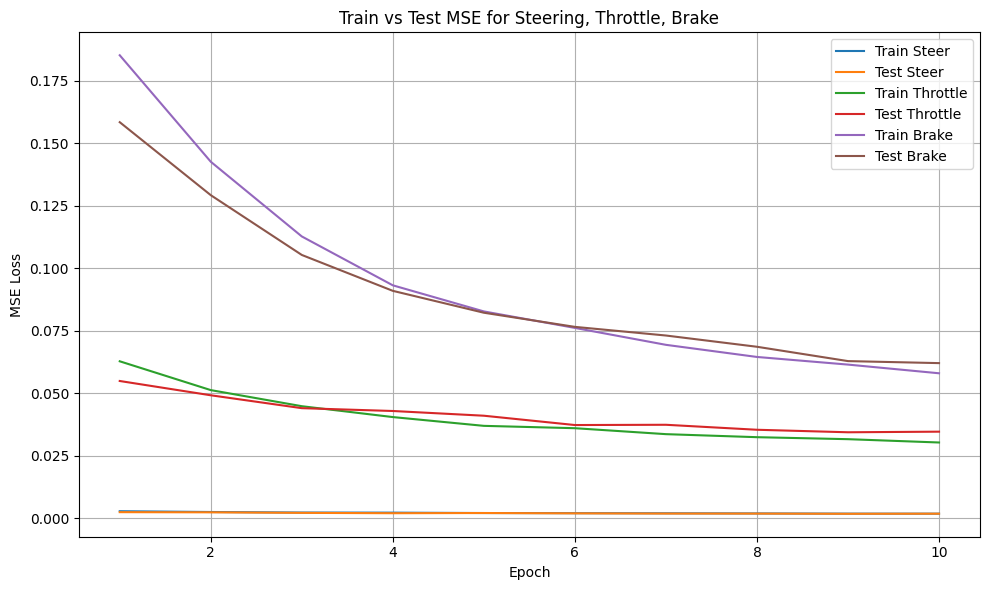

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt


# preprocessing the dataset
class DrivingDataset(Dataset):
    def __init__(self, csv_file, augment=False):
        self.data = pd.read_csv(csv_file)
        self.augment = augment
        self.transform = transforms.Compose(
            [
                transforms.Resize((120, 160)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
                ),  # Normalize to [-1,1]
            ]
        )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = row["image_path"]

        if not os.path.exists(img_path):
            print(f"Image not found: {img_path}. Using black image instead.")
            image = Image.new("RGB", (160, 120))
        else:
            try:
                image = Image.open(img_path).convert("RGB")
            except Exception as e:
                print(
                    f"Error loading image {img_path}: {e}. Using black image instead."
                )
                image = Image.new("RGB", (160, 120))

        if self.augment:
            # Random horizontal flip
            if torch.rand(1).item() > 0.5:
                image = transforms.functional.hflip(image)
                # Flip steering sign when flipped
                steer = -row["steer"]
            else:
                steer = row["steer"]
        else:
            steer = row["steer"]

        image = self.transform(image)

        label = torch.tensor(
            [steer, row["throttle"], row["brake"]], dtype=torch.float32
        )
        return image, label


class DrivingCNN(nn.Module):
    def __init__(self):
        super(DrivingCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 5, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, 5, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, 5, stride=2),
            nn.ReLU(),
        )
        self.fc1 = None
        self.fc2 = None

    def initialize(self, input_shape):
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            dummy_output = self.conv(dummy_input)
            fc_input_size = dummy_output.view(1, -1).shape[1]
        self.fc1 = nn.Linear(fc_input_size, 100)
        self.fc2 = nn.Linear(100, 3)

    def forward(self, x):
        if self.fc1 is None:
            raise RuntimeError("Call model.initialize((3, H, W)) first.")
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


def main():
    # Load datasets and print sizes
    train_set = DrivingDataset("train.csv", augment=True)
    test_set = DrivingDataset("val.csv", augment=False)
    print(f"Train dataset size: {len(train_set)}")
    print(f"Test dataset size: {len(test_set)}")

    # Use drop_last=False to avoid empty batches if dataset smaller than batch size
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True, drop_last=False)
    test_loader = DataLoader(test_set, batch_size=32, shuffle=False, drop_last=False)

    # Model setup
    model = DrivingCNN()
    model.initialize((3, 120, 160))
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    train_steer, train_throttle, train_brake = [], [], []
    test_steer, test_throttle, test_brake = [], [], []

    epochs = 10

    for epoch in range(epochs):
        model.train()
        t_steer, t_throttle, t_brake, t_count = 0, 0, 0, 0

        print(f"Epoch {epoch+1} training...")

        for batch_idx, (images, labels) in enumerate(train_loader):
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            t_count += images.size(0)
            t_steer += F.mse_loss(outputs[:, 0], labels[:, 0], reduction="sum").item()
            t_throttle += F.mse_loss(
                outputs[:, 1], labels[:, 1], reduction="sum"
            ).item()
            t_brake += F.mse_loss(outputs[:, 2], labels[:, 2], reduction="sum").item()

            if batch_idx % 10 == 0:
                print(
                    f"  Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}"
                )

        train_steer.append(t_steer / t_count)
        train_throttle.append(t_throttle / t_count)
        train_brake.append(t_brake / t_count)

        model.eval()
        te_steer, te_throttle, te_brake, te_count = 0, 0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                te_count += images.size(0)
                te_steer += F.mse_loss(
                    outputs[:, 0], labels[:, 0], reduction="sum"
                ).item()
                te_throttle += F.mse_loss(
                    outputs[:, 1], labels[:, 1], reduction="sum"
                ).item()
                te_brake += F.mse_loss(
                    outputs[:, 2], labels[:, 2], reduction="sum"
                ).item()

        test_steer.append(te_steer / te_count)
        test_throttle.append(te_throttle / te_count)
        test_brake.append(te_brake / te_count)

        print(f"Epoch {epoch+1}")
        print(
            f"Train - Steer: {train_steer[-1]:.4f}, Throttle: {train_throttle[-1]:.4f}, Brake: {train_brake[-1]:.4f}"
        )
        print(
            f"Test  - Steer: {test_steer[-1]:.4f}, Throttle: {test_throttle[-1]:.4f}, Brake: {test_brake[-1]:.4f}"
        )

    torch.save(model.state_dict(), "drive_sept_old.pth")

    # Plotting loss curves
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_range, train_steer, label="Train Steer")
    plt.plot(epochs_range, test_steer, label="Test Steer")
    plt.plot(epochs_range, train_throttle, label="Train Throttle")
    plt.plot(epochs_range, test_throttle, label="Test Throttle")
    plt.plot(epochs_range, train_brake, label="Train Brake")
    plt.plot(epochs_range, test_brake, label="Test Brake")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Train vs Test MSE for Steering, Throttle, Brake")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()

In our training process using CARLA's autopilot data, we found that steering predictions generalize well, but throttle and brake exhibited noisy and inconsistent behavior—especially during testing

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt

# -------------------------
# Dataset
# -------------------------
class DrivingDataset(Dataset):
    def __init__(self, csv_file, augment=False, use_speed=True):
        self.df = pd.read_csv(csv_file)
        self.augment = augment
        self.use_speed = use_speed
        self.transform = transforms.Compose([
            transforms.Resize((120,160)),
            transforms.ToTensor(),
            transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        ])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["image_path"]
        if not os.path.exists(img_path):
            image = Image.new("RGB", (160,120))
        else:
            image = Image.open(img_path).convert("RGB")
        
        if self.augment and torch.rand(1).item() > 0.5:
            image = transforms.functional.hflip(image)
            steer = -row["steer"]
        else:
            steer = row["steer"]

        image = self.transform(image)
        label = torch.tensor([steer, row["throttle"], row["brake"]], dtype=torch.float32)

        # FIXED: always return aux on CPU first, then move to device in training loop
        if self.use_speed and "speed" in row:
            aux = torch.tensor([row["speed"]], dtype=torch.float32)
        else:
            aux = torch.tensor([0.0], dtype=torch.float32)

        return image, aux, label



# -------------------------
# CNN Model with optional speed
# -------------------------
class DrivingNet(nn.Module):
    def __init__(self, use_speed=True):
        super().__init__()
        self.use_speed = use_speed
        self.conv = nn.Sequential(
            nn.Conv2d(3,16,5,stride=2), nn.ReLU(),
            nn.Conv2d(16,32,5,stride=2), nn.ReLU(),
            nn.Conv2d(32,64,5,stride=2), nn.ReLU()
        )
        self.fc = None
        self.speed_fc = nn.Sequential(nn.Linear(1,16), nn.ReLU()) if use_speed else None
        self.head = None

    def initialize(self, input_shape):
        device = next(self.parameters()).device
        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape, device=device)
            feat = self.conv(dummy).view(1,-1)
            feat_size = feat.shape[1] + (16 if self.use_speed else 0)
        self.fc = nn.Sequential(
            nn.Linear(feat_size,100), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(100,50), nn.ReLU()
        )
        self.head = nn.Linear(50,3)

    def forward(self, x, aux=None):
        device = next(self.parameters()).device
        x = x.to(device)

        x = self.conv(x)
        x = x.view(x.size(0), -1)

        if self.use_speed and aux is not None:
            aux = aux.to(device).float()  # move to same device
            if aux.dim() == 1:  # shape [batch] → [batch, 1]
                aux = aux.unsqueeze(1)
            aux = self.speed_fc(aux)
            x = torch.cat([x, aux], dim=1)

        x = self.fc(x)
        x = self.head(x)
        return x






# -------------------------
# Training functions
# -------------------------
def train_one_epoch(model, loader, optimizer, criterion, device, max_grad_norm=5.0):
    model.train()
    total_loss, total_samples = 0.0, 0
    for imgs, aux, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        aux = aux.to(device) if aux.nelement() != 0 else None
        optimizer.zero_grad()
        outputs = model(imgs, aux)
        loss = criterion(outputs, labels)
        loss.backward()
        if max_grad_norm:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        total_samples += imgs.size(0)
    return total_loss / total_samples

def validate(model, loader, criterion, device):
    model.eval()
    total_loss, total_samples = 0.0, 0
    with torch.no_grad():
        for imgs, aux, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            aux = aux.to(device) if aux.nelement() != 0 else None
            outputs = model(imgs, aux)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * imgs.size(0)
            total_samples += imgs.size(0)
    return total_loss / total_samples


# -------------------------
# Main
# -------------------------
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    train_set = DrivingDataset("train.csv", augment=True, use_speed=True)
    val_set = DrivingDataset("val.csv", augment=False, use_speed=True)

    train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=2)

    model = DrivingNet(use_speed=True)
    model.initialize((3,120,160))
    model = model.to(device)   # <-- move everything after building fc/head



    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, verbose=True)

    best_val = float("inf")
    epochs = 20

    for epoch in range(1, epochs+1):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss = validate(model, val_loader, criterion, device)
        scheduler.step(val_loss)

        print(f"[Epoch {epoch}] Train Loss: {train_loss:.6f}  Val Loss: {val_loss:.6f}")

        if val_loss < best_val:
            best_val = val_loss
            torch.save(model.state_dict(), "best_model.pth")
            print("  -> Saved best_model.pth")

if __name__ == "__main__":
    main()


Using device: cuda


[Epoch 1] Train Loss: 0.073299  Val Loss: 0.035406
  -> Saved best_model.pth
[Epoch 2] Train Loss: 0.023021  Val Loss: 0.014362
  -> Saved best_model.pth
[Epoch 3] Train Loss: 0.016191  Val Loss: 0.014020
  -> Saved best_model.pth
[Epoch 4] Train Loss: 0.015203  Val Loss: 0.014462
[Epoch 5] Train Loss: 0.014263  Val Loss: 0.013288
  -> Saved best_model.pth
[Epoch 6] Train Loss: 0.013642  Val Loss: 0.012544
  -> Saved best_model.pth
[Epoch 7] Train Loss: 0.012972  Val Loss: 0.012163
  -> Saved best_model.pth
[Epoch 8] Train Loss: 0.012512  Val Loss: 0.012456
[Epoch 9] Train Loss: 0.012135  Val Loss: 0.012302
[Epoch 10] Train Loss: 0.011578  Val Loss: 0.011714
  -> Saved best_model.pth
[Epoch 11] Train Loss: 0.011435  Val Loss: 0.011533
  -> Saved best_model.pth
[Epoch 12] Train Loss: 0.011088  Val Loss: 0.012085
[Epoch 13] Train Loss: 0.010614  Val Loss: 0.010936
  -> Saved best_model.pth
[Epoch 14] Train Loss: 0.010461  Val Loss: 0.011551
[Epoch 15] Train Loss: 0.010255  Val Loss: 0.01

# Success training code 

In [3]:
# train_fixed.py (enhanced for stability & reduced drift)
import os
import random
from collections import Counter
import numpy as np
import pandas as pd
from PIL import Image, ImageFilter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from torchvision.transforms import functional as TF
from torch.optim import AdamW
from torch.cuda.amp import GradScaler, autocast

# -------------------------
# Utilities & Config
# -------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

CFG = {
    "img_h": 120,
    "img_w": 160,
    "batch_size": 16,            # smaller often more stable
    "epochs": 20,
    "lr": 3e-4,
    "weight_decay": 1e-5,
    "n_stack": 3,
    "use_speed": True,
    "balance_bins": 25,
    "max_grad_norm": 5.0,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "pin_memory": True,
}

# -------------------------
# Dataset (robust + jitter)
# -------------------------
class DrivingDataset(Dataset):
    def __init__(self, csv_file, img_root="", n_stack=1, augment=False, use_speed=True):
        self.df = pd.read_csv(csv_file)
        self.df.columns = self.df.columns.str.strip()
        self.img_root = img_root
        self.n_stack = max(1, n_stack)
        self.augment = augment
        self.use_speed = use_speed

        self.transform = transforms.Compose([
            transforms.Resize((CFG["img_h"], CFG["img_w"])),
            transforms.ToTensor(),
            transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
        ])

        self.df = self.df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def _load(self, relpath):
        path = os.path.join(self.img_root, relpath) if self.img_root else relpath
        if not os.path.exists(path):
            return Image.new("RGB", (CFG["img_w"], CFG["img_h"]))
        return Image.open(path).convert("RGB")

    def _maybe_augment_single(self, img, steer):
        # brightness/contrast
        if torch.rand(1).item() < 0.5:
            img = TF.adjust_brightness(img, 0.8 + 0.4 * torch.rand(1).item())
            img = TF.adjust_contrast(img, 0.8 + 0.4 * torch.rand(1).item())
        # gamma (shadows)
        if torch.rand(1).item() < 0.3:
            img = TF.adjust_gamma(img, 0.7 + 0.6*torch.rand(1).item())
        # blur
        if torch.rand(1).item() < 0.2:
            img = img.filter(ImageFilter.GaussianBlur(radius=1))
        # translation
        if torch.rand(1).item() < 0.4:
            dx = int((torch.rand(1).item() * 2 - 1) * 8)
            img = TF.affine(img, angle=0.0, translate=(dx, 0), scale=1.0, shear=0.0)
            steer = float(steer) + (-dx / 8.0) * 0.12
        # flip
        if torch.rand(1).item() < 0.5:
            img = TF.hflip(img)
            steer = -float(steer)
        return img, float(steer)

    def __getitem__(self, idx):
        start = max(0, idx - (self.n_stack - 1))
        indices = list(range(start, idx + 1))
        while len(indices) < self.n_stack:
            indices.insert(0, indices[0])

        imgs = [ self._load(self.df.iloc[i]["image_path"]) for i in indices ]
        steer = float(self.df.iloc[idx]["steer"])
        throttle = float(self.df.iloc[idx]["throttle"]) if "throttle" in self.df.columns else 0.0
        brake = float(self.df.iloc[idx]["brake"]) if "brake" in self.df.columns else 0.0
        speed = float(self.df.iloc[idx]["speed"]) if "speed" in self.df.columns else 0.0

        if self.augment:
            imgs[0], steer = self._maybe_augment_single(imgs[0], steer)
            for j in range(1, len(imgs)):
                imgs[j] = imgs[0].copy()
            # inject steering noise (recovery training)
            if torch.rand(1).item() < 0.2:
                steer += np.random.normal(0, 0.05)

        tensors = [ self.transform(im) for im in imgs ]
        img_stack = torch.cat(tensors, dim=0)

        label = torch.tensor([steer, throttle, brake], dtype=torch.float32)
        # label smoothing / jitter
        if self.augment:
            label += 0.01*torch.randn_like(label)
            label = torch.clamp(label, min=-1.0, max=1.0)

        aux = torch.tensor([speed], dtype=torch.float32) if self.use_speed else torch.zeros(1, dtype=torch.float32)
        return img_stack, aux, label

# -------------------------
# Model
# -------------------------
class DrivingNet(nn.Module):
    def __init__(self, in_ch=3, n_stack=1, use_speed=True):
        super().__init__()
        C = in_ch * n_stack
        self.use_speed = use_speed
        self.conv = nn.Sequential(
            nn.Conv2d(C, 24, kernel_size=5, stride=2), nn.BatchNorm2d(24), nn.ReLU(),
            nn.Conv2d(24,36, kernel_size=5, stride=2), nn.BatchNorm2d(36), nn.ReLU(),
            nn.Conv2d(36,48, kernel_size=5, stride=2), nn.BatchNorm2d(48), nn.ReLU(),
            nn.Conv2d(48,64, kernel_size=3, stride=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64,64, kernel_size=3, stride=1), nn.BatchNorm2d(64), nn.ReLU()
        )
        self._feat = None
        self.fc = None
        self.speed_fc = nn.Sequential(nn.Linear(1, 16), nn.ReLU()) if use_speed else None

    def initialize(self, input_shape):
        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape, device=next(self.parameters()).device)
            out = self.conv(dummy)
            self._feat = int(out.view(1, -1).shape[1])
        fc_in = self._feat + (16 if self.use_speed else 0)
        self.fc = nn.Sequential(
            nn.Linear(fc_in, 100), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(100, 50), nn.ReLU()
        )
        self.steer_head = nn.Linear(50, 1)
        self.throttle_head = nn.Linear(50, 1)
        self.brake_head = nn.Linear(50, 1)

    def forward(self, x, aux=None):
        device = next(self.parameters()).device
        x = x.to(device)
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        if self.use_speed and aux is not None:
            aux = aux.to(device).float()
            if aux.dim() == 1:
                aux = aux.unsqueeze(1)
            aux = self.speed_fc(aux)
            x = torch.cat([x, aux], dim=1)
        x = self.fc(x)
        steer = torch.tanh(self.steer_head(x))
        throttle = torch.sigmoid(self.throttle_head(x))
        brake = torch.sigmoid(self.brake_head(x))
        return torch.cat([steer, throttle, brake], dim=1)

# -------------------------
# Helpers
# -------------------------
def make_steer_weights(df, n_bins=25):
    s = np.abs(df["steer"].values)
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    inds = np.digitize(s, bins) - 1
    counts = Counter(inds)
    weights = np.array([1.0 / counts[i] for i in inds], dtype=np.float32)
    weights = weights / weights.mean()
    return weights

def speed_consistency_loss(pred, labels):
    target_accel = labels[:,1] - labels[:,2]
    pred_accel = pred[:,1] - pred[:,2]
    return F.mse_loss(pred_accel, target_accel)

# -------------------------
# Train / Validate
# -------------------------
def train_one_epoch(model, loader, opt, device, scaler=None, max_grad_norm=5.0,
                    loss_weights=(1.0, 0.6, 0.6)):
    model.train()
    total_loss = 0.0
    total_samples = 0
    for imgs, aux, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        aux = aux.to(device) if aux.nelement() != 0 else None

        opt.zero_grad()
        if scaler is not None:
            with autocast():
                out = model(imgs, aux)
                loss = (loss_weights[0]*F.mse_loss(out[:,0], labels[:,0]) +
                        loss_weights[1]*F.mse_loss(out[:,1], labels[:,1]) +
                        loss_weights[2]*F.mse_loss(out[:,2], labels[:,2]))
                loss += 0.2 * speed_consistency_loss(out, labels)
            scaler.scale(loss).backward()
            scaler.unscale_(opt)
            if max_grad_norm: torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            scaler.step(opt)
            scaler.update()
        else:
            out = model(imgs, aux)
            loss = (loss_weights[0]*F.mse_loss(out[:,0], labels[:,0]) +
                    loss_weights[1]*F.mse_loss(out[:,1], labels[:,1]) +
                    loss_weights[2]*F.mse_loss(out[:,2], labels[:,2]))
            loss += 0.2 * speed_consistency_loss(out, labels)
            loss.backward()
            if max_grad_norm: torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            opt.step()

        total_loss += loss.item() * imgs.size(0)
        total_samples += imgs.size(0)
    return total_loss / total_samples

def validate(model, loader, device):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for imgs, aux, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            aux = aux.to(device) if aux.nelement() != 0 else None
            out = model(imgs, aux)
            loss = F.mse_loss(out, labels, reduction="mean")
            loss += 0.2 * speed_consistency_loss(out, labels)
            total_loss += loss.item() * imgs.size(0)
            total_samples += imgs.size(0)
    return total_loss / total_samples

# -------------------------
# Main
# -------------------------
def main(train_csv="train.csv", val_csv="val.csv", img_root=""):
    device = torch.device(CFG["device"])
    print("Device:", device)

    train_df = pd.read_csv(train_csv)
    weights = make_steer_weights(train_df, n_bins=CFG["balance_bins"])
    sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

    train_ds = DrivingDataset(train_csv, img_root=img_root, n_stack=CFG["n_stack"], augment=True, use_speed=CFG["use_speed"])
    val_ds = DrivingDataset(val_csv, img_root=img_root, n_stack=CFG["n_stack"], augment=False, use_speed=CFG["use_speed"])

    num_workers = 4 if device.type == "cuda" else 0
    pin_memory = True if device.type == "cuda" else False

    train_loader = DataLoader(train_ds, batch_size=CFG["batch_size"], sampler=sampler,
                              num_workers=num_workers, pin_memory=pin_memory)
    val_loader = DataLoader(val_ds, batch_size=CFG["batch_size"], shuffle=False,
                            num_workers=max(0, num_workers//2), pin_memory=pin_memory)

    model = DrivingNet(in_ch=3, n_stack=CFG["n_stack"], use_speed=CFG["use_speed"]).to(device)
    model.initialize((3*CFG["n_stack"], CFG["img_h"], CFG["img_w"]))
    model = model.to(device)   # <-- move everything after building fc/head

    opt = AdamW(model.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=3)
    scaler = GradScaler() if device.type == "cuda" else None

    best = float("inf")
    os.makedirs("checkpoints", exist_ok=True)

    for epoch in range(1, CFG["epochs"]+1):
        tr_loss = train_one_epoch(model, train_loader, opt, device, scaler=scaler,
                                  max_grad_norm=CFG["max_grad_norm"])
        val_loss = validate(model, val_loader, device)
        scheduler.step(val_loss)
        print(f"[{epoch}] train_loss={tr_loss:.6f}  val_loss={val_loss:.6f}")

        torch.save({"epoch": epoch, "state": model.state_dict(), "opt": opt.state_dict()},
                   f"checkpoints/ckpt_epoch{epoch:02d}.pth")
        if val_loss < best:
            best = val_loss
            torch.save(model.state_dict(), "checkpoints/new_best_model.pth")
            print(" -> saved new_best_model.pth")

    print("Done. best val:", best)

if __name__ == "__main__":
    main()


Device: cuda


/tmp/ipykernel_1802155/2445204095.py:275: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if device.type == "cuda" else None
/tmp/ipykernel_1802155/2445204095.py:206: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[1] train_loss=0.095254  val_loss=0.232630
 -> saved new_best_model.pth
[2] train_loss=0.077531  val_loss=0.185051
 -> saved new_best_model.pth
[3] train_loss=0.060128  val_loss=0.101060
 -> saved new_best_model.pth
[4] train_loss=0.044812  val_loss=0.032974
 -> saved new_best_model.pth
[5] train_loss=0.039390  val_loss=0.028983
 -> saved new_best_model.pth
[6] train_loss=0.034371  val_loss=0.028252
 -> saved new_best_model.pth
[7] train_loss=0.030072  val_loss=0.027490
 -> saved new_best_model.pth
[8] train_loss=0.028196  val_loss=0.027932
[9] train_loss=0.029121  val_loss=0.027449
 -> saved new_best_model.pth
[10] train_loss=0.026776  val_loss=0.027054
 -> saved new_best_model.pth
[11] train_loss=0.025818  val_loss=0.027276
[12] train_loss=0.026135  val_loss=0.026189
 -> saved new_best_model.pth
[13] train_loss=0.024012  val_loss=0.026162
 -> saved new_best_model.pth
[14] train_loss=0.023925  val_loss=0.025872
 -> saved new_best_model.pth
[15] train_loss=0.024480  val_loss=0.026174
[

# debugging with simple trained model

In [ ]:
# Your CNN model class (DrivingCNN) must be defined here or imported

import carla
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
from PIL import Image
import time
import os
import random
import imageio
import cv2

# Environment setup
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
torch.set_num_threads(1)


# ----------------- Model -----------------
class DrivingCNN(nn.Module):
    def __init__(self):
        super(DrivingCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 5, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, 5, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, 5, stride=2),
            nn.ReLU(),
        )
        self.fc1 = None
        self.fc2 = None

    def initialize(self, input_shape):
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            dummy_output = self.conv(dummy_input)
            fc_input_size = dummy_output.view(1, -1).shape[1]
        self.fc1 = nn.Linear(fc_input_size, 100)
        self.fc2 = nn.Linear(100, 3)

    def forward(self, x):
        if self.fc1 is None:
            raise RuntimeError("Call model.initialize((3, H, W)) first.")
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


def preprocess_image(image):
    transform = transforms.Compose(
        [
            transforms.Resize((120, 160)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3),
        ]
    )
    image = Image.fromarray(image)  # Convert numpy array (H,W,3) to PIL Image
    return transform(image).unsqueeze(0)  # Add batch dimension


def main():
    # Connect to CARLA
    client = carla.Client("localhost", 2000)
    client.set_timeout(10.0)
    world = client.get_world()

    _map = world.get_map()  # Get the map and waypoint

    blueprint_library = world.get_blueprint_library()
    vehicle_bp = blueprint_library.filter("model3")[0]  # Example Tesla Model 3

    # spawn_point = world.get_map().get_spawn_points()[0]

    spawn_points = world.get_map().get_spawn_points()
    spawn_point = random.choice(spawn_points)
    spawn_point.location.z += 0.5

    vehicle = world.spawn_actor(vehicle_bp, spawn_point)

    # Open a log file before the loop to write your trajectory
    log_filename = "trajectory_log_old.csv"
    with open(log_filename, "w") as f:
        f.write("timestamp,x,y,z,yaw,steer,throttle,brake,lane_offset\n")

    if not os.path.exists("modelimages"):
        os.makedirs("modelimages")

    # Setup camera sensor
    camera_bp = blueprint_library.find("sensor.camera.rgb")
    camera_bp.set_attribute("image_size_x", "160")
    camera_bp.set_attribute("image_size_y", "120")
    camera_bp.set_attribute("fov", "110")

    camera_transform = carla.Transform(carla.Location(x=1.5, z=2.4))
    camera = world.spawn_actor(camera_bp, camera_transform, attach_to=vehicle)

    # Setup collision sensor
    collision_bp = blueprint_library.find("sensor.other.collision")
    collision_sensor = world.spawn_actor(
        collision_bp, carla.Transform(), attach_to=vehicle
    )

    def on_collision(event):
        nonlocal collision_count, collision_occurred
        collision_count += 1
        collision_time = time.time()
        collision_times.append(collision_time)
        elapsed = collision_time - start_time
        print(f"Collision #{collision_count} detected at {elapsed:.2f} seconds")
        collision_occurred = True

    collision_sensor.listen(on_collision)

    spectator = world.get_spectator()

    collision_count = 0
    collision_times = []
    start_time = time.time()
    collision_occurred = False
    collision_time = None
    start_location = None

    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = DrivingCNN()
    model.initialize((3, 120, 160))
    model.load_state_dict(torch.load("best_model.pth", map_location=device))
    model.to(device)
    model.eval()

    control = carla.VehicleControl()

    # We use a variable to store latest image frame from camera sensor
    latest_image = None

    def camera_callback(image):
        nonlocal latest_image
        array = np.frombuffer(image.raw_data, dtype=np.uint8)
        array = array.reshape((image.height, image.width, 4))[:, :, :3]  # BGRA -> BGR
        array = array[:, :, ::-1]  # BGR -> RGB
        latest_image = array

    camera.listen(camera_callback)
    global deviations
    deviations = []
    frame_count = 0

    try:
        while True:
            if latest_image is not None:

                filename = f"modelimages/{frame_count:06d}.png"
                cv2.imwrite(filename, cv2.cvtColor(latest_image, cv2.COLOR_RGB2BGR))
                frame_count += 1

                # Preprocess image
                input_tensor = preprocess_image(latest_image).to(device)

                # Model inference
                with torch.no_grad():
                    output = model(input_tensor)
                steer, throttle, brake = output[0].cpu().numpy()

                # Clamp controls to valid ranges
                steer = float(np.clip(steer, -1.0, 1.0))
                throttle = float(np.clip(throttle, 0.0, 1.0))
                brake = float(np.clip(brake, 0.0, 1.0))

                # Apply controls
                control.steer = steer
                control.throttle = throttle
                control.brake = brake
                vehicle.apply_control(control)

                # Now update spectator to follow vehicle from behind
                transform = vehicle.get_transform()
                location = transform.location
                rotation = transform.rotation

                # Get vehicle velocity and compute speed
                velocity = vehicle.get_velocity()
                speed = (velocity.x**2 + velocity.y**2 + velocity.z**2) ** 0.5
                print(f"Speed: {speed:.3f} m/s")

                # Get lane center offset
                waypoint = _map.get_waypoint(location)
                lane_center = waypoint.transform.location
                lane_offset = location.distance(lane_center)

                # Log to file
                timestamp = time.time()
                with open(log_filename, "a") as f:
                    f.write(
                        f"{timestamp},{location.x},{location.y},{location.z},{rotation.yaw},"
                        f"{steer},{throttle},{brake},{lane_offset}\n"
                    )

                deviations.append(lane_offset)
                # Distance from start
                if start_location is None:
                    start_location = location
                distance_traveled = location.distance(start_location)

                # Print or log control values and vehicle position
                print(
                    f"Pos: ({location.x:.2f}, {location.y:.2f}, {location.z:.2f}), "
                    f"Yaw: {rotation.yaw:.2f}, "
                    f"Steer: {steer:.3f}, Throttle: {throttle:.3f}, Brake: {brake:.3f}"
                )
                print(f"Distance from lane center: {lane_offset:.2f} meters")

                # Update spectator position
                backward_vec = transform.get_forward_vector() * -6
                spectator_loc = location + backward_vec
                spectator_loc.z += 3

                spectator_rot = carla.Rotation(pitch=-15, yaw=rotation.yaw, roll=0)

                spectator.set_transform(carla.Transform(spectator_loc, spectator_rot))

                # Stop if collision
                if collision_occurred:
                    total_duration = time.time() - start_time
                    collision_rate = (
                        collision_count / total_duration if total_duration > 0 else 0
                    )
                    print(f"Total collisions: {collision_count}")
                    print(f"Total duration: {total_duration:.2f} seconds")
                    print(f"Collision rate: {collision_rate:.4f} collisions per second")
                    print(
                        f"Final distance before collision: {distance_traveled:.2f} meters"
                    )
                    break

                # time.sleep(0.05)

    finally:
        camera.stop()
        camera.destroy()
        collision_sensor.stop()
        collision_sensor.destroy()
        vehicle.destroy()
        print("All actors destroyed.")


if __name__ == "__main__":
    main()

# Sept-new training and debugging code

In [ ]:
import carla
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
from PIL import Image
import time
import os
import random
import imageio
import cv2

# Environment setup
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
torch.set_num_threads(1)


# ----------------- Model -----------------
class DrivingNet(nn.Module):
    def __init__(self, in_ch=3, n_stack=1, use_speed=True):
        super().__init__()
        C = in_ch * n_stack
        self.use_speed = use_speed
        self.conv = nn.Sequential(
            nn.Conv2d(C, 24, kernel_size=5, stride=2), nn.BatchNorm2d(24), nn.ReLU(),
            nn.Conv2d(24,36, kernel_size=5, stride=2), nn.BatchNorm2d(36), nn.ReLU(),
            nn.Conv2d(36,48, kernel_size=5, stride=2), nn.BatchNorm2d(48), nn.ReLU(),
            nn.Conv2d(48,64, kernel_size=3, stride=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64,64, kernel_size=3, stride=1), nn.BatchNorm2d(64), nn.ReLU()
        )
        self._feat = None
        self.fc = None
        self.speed_fc = nn.Sequential(nn.Linear(1, 16), nn.ReLU()) if use_speed else None

    def initialize(self, input_shape):
        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape, device=next(self.parameters()).device)
            out = self.conv(dummy)
            self._feat = int(out.view(1, -1).shape[1])
        fc_in = self._feat + (16 if self.use_speed else 0)
        self.fc = nn.Sequential(
            nn.Linear(fc_in, 100), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(100, 50), nn.ReLU()
        )
        self.steer_head = nn.Linear(50, 1)
        self.throttle_head = nn.Linear(50, 1)
        self.brake_head = nn.Linear(50, 1)

    def forward(self, x, aux=None):
        device = next(self.parameters()).device
        x = x.to(device)
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        if self.use_speed and aux is not None:
            aux = aux.to(device).float()
            if aux.dim() == 1:
                aux = aux.unsqueeze(1)
            aux = self.speed_fc(aux)
            x = torch.cat([x, aux], dim=1)
        x = self.fc(x)
        steer = torch.tanh(self.steer_head(x))
        throttle = torch.sigmoid(self.throttle_head(x))
        brake = torch.sigmoid(self.brake_head(x))
        return torch.cat([steer, throttle, brake], dim=1)


# Preprocessing function for stacked images
# Preprocessing function for stacked images
def preprocess_stacked_images(frame_stack):
    if len(frame_stack) == 3:  # Ensure that there are 3 frames stacked
        # Print the shape of each frame before stacking
        for idx, frame in enumerate(frame_stack):
            print(f"Shape of frame {idx}: {frame.shape}")
        
        # Stack the frames along the channel dimension (3 frames * 3 channels = 9 channels)
        stacked_image = np.concatenate(frame_stack, axis=2)  # Shape should become (120, 160, 9)
        
        # Check the shape of the stacked image before passing to PIL
        print(f"Stacked image shape: {stacked_image.shape}")  # Should be (120, 160, 9)
        
        # Ensure the stacked image is of the correct dtype (uint8)
        stacked_image = np.array(stacked_image, dtype=np.uint8)  # Ensure dtype is uint8
        
        # Preprocess the stacked image
        return preprocess_image(stacked_image)  # Return the processed image as a tensor
    return None  # If there are not enough frames, return None


# Preprocessing function for individual images
def preprocess_image(image):
    transform = transforms.Compose([
        transforms.Resize((120, 160)),  # Ensure the image is resized
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),  # Normalize as per model requirements
    ])
    
    # Check the shape and dtype before passing to PIL
    print(f"Image shape before PIL: {image.shape}, dtype: {image.dtype}")
    
    # Skip conversion to PIL Image for multi-channel input
    # Normalize the numpy array directly and convert to tensor
    image = np.transpose(image, (2, 0, 1))  # Change shape to (C, H, W)
    image = torch.tensor(image, dtype=torch.float32) / 255.0  # Scale pixel values to [0, 1]
    image = transforms.Normalize(mean=[0.5] * image.shape[0], std=[0.5] * image.shape[0])(image)
    return image.unsqueeze(0)  # Add batch dimension




def main():
    # Connect to CARLA
    client = carla.Client("localhost", 2000)
    client.set_timeout(10.0)
    world = client.get_world()

    _map = world.get_map()  # Get the map and waypoint

    blueprint_library = world.get_blueprint_library()
    vehicle_bp = blueprint_library.filter("vehicle.mercedes.coupe_2020")[0]  # Example Tesla Model 3

    spawn_points = world.get_map().get_spawn_points()
    spawn_point = random.choice(spawn_points)
    spawn_point.location.z += 0.5

    vehicle = world.spawn_actor(vehicle_bp, spawn_point)

    # Open a log file before the loop to write your trajectory
    log_filename = "trajectory_log.csv"
    with open(log_filename, "w") as f:
        f.write("timestamp,x,y,z,yaw,steer,throttle,brake,lane_offset\n")

    if not os.path.exists("modelimages"):
        os.makedirs("modelimages")

    # Setup camera sensor
    camera_bp = blueprint_library.find("sensor.camera.rgb")
    camera_bp.set_attribute("image_size_x", "160")
    camera_bp.set_attribute("image_size_y", "120")
    camera_bp.set_attribute("fov", "110")

    camera_transform = carla.Transform(carla.Location(x=1.5, z=2.4))
    camera = world.spawn_actor(camera_bp, camera_transform, attach_to=vehicle)

    # Setup collision sensor
    collision_bp = blueprint_library.find("sensor.other.collision")
    collision_sensor = world.spawn_actor(
        collision_bp, carla.Transform(), attach_to=vehicle
    )

    def on_collision(event):
        nonlocal collision_count, collision_occurred
        collision_count += 1
        collision_time = time.time()
        collision_times.append(collision_time)
        elapsed = collision_time - start_time
        print(f"Collision #{collision_count} detected at {elapsed:.2f} seconds")
        collision_occurred = True

    collision_sensor.listen(on_collision)

    spectator = world.get_spectator()

    collision_count = 0
    collision_times = []
    start_time = time.time()
    collision_occurred = False
    collision_time = None
    start_location = None

    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = DrivingNet(in_ch=3, n_stack=3, use_speed=True).to(device)
    model.initialize((9, 120, 160))
    model.load_state_dict(torch.load("/home/robotuser/carla_0.9.12/PythonAPI/examples/checkpoints/new_best_model.pth", map_location=device))
    model = model.to(device)
    model.eval()

    control = carla.VehicleControl()

    # We use a variable to store latest image frame from camera sensor
    latest_image = None
    frame_stack = []  # Stack to store the last 3 frames

    def camera_callback(image):
        nonlocal latest_image, frame_stack
        array = np.frombuffer(image.raw_data, dtype=np.uint8)
        array = array.reshape((image.height, image.width, 4))[:, :, :3]  # BGRA -> BGR
        array = array[:, :, ::-1]  # BGR -> RGB
        latest_image = array

        # Append the latest image to the frame stack
        frame_stack.append(latest_image)
        if len(frame_stack) > 3:
            frame_stack.pop(0)  # Keep only the last 3 frames

    camera.listen(camera_callback)

    global deviations
    deviations = []
    frame_count = 0

    try:
        while True:
            if len(frame_stack) == 3:  # Ensure 3 frames are available

                # Preprocess stacked image
                input_tensor = preprocess_stacked_images(frame_stack).to(device)

                # Model inference
                with torch.no_grad():
                    output = model(input_tensor, aux=torch.tensor([0.0], device=device))  # no speed info online
                steer, throttle, brake = output[0].cpu().numpy()

                # Clamp controls to valid ranges
                steer = float(np.clip(steer, -1.0, 1.0))
                throttle = float(np.clip(throttle, 0.0, 1.0))
                brake = float(np.clip(brake, 0.0, 1.0))

                # Apply controls
                control.steer = steer
                control.throttle = throttle
                control.brake = brake
                vehicle.apply_control(control)

                # Now update spectator to follow vehicle from behind
                transform = vehicle.get_transform()
                location = transform.location
                rotation = transform.rotation

                # Get vehicle velocity and compute speed
                velocity = vehicle.get_velocity()
                speed = (velocity.x**2 + velocity.y**2 + velocity.z**2) ** 0.5
                print(f"Speed: {speed:.3f} m/s")

                # Get lane center offset
                waypoint = _map.get_waypoint(location)
                lane_center = waypoint.transform.location
                lane_offset = location.distance(lane_center)

                # Log to file
                timestamp = time.time()
                with open(log_filename, "a") as f:
                    f.write(
                        f"{timestamp},{location.x},{location.y},{location.z},{rotation.yaw},"
                        f"{steer},{throttle},{brake},{lane_offset}\n"
                    )

                deviations.append(lane_offset)
                # Distance from start
                if start_location is None:
                    start_location = location
                distance_traveled = location.distance(start_location)

                # Print or log control values and vehicle position
                print(
                    f"Pos: ({location.x:.2f}, {location.y:.2f}, {location.z:.2f}), "
                    f"Yaw: {rotation.yaw:.2f}, "
                    f"Steer: {steer:.3f}, Throttle: {throttle:.3f}, Brake: {brake:.3f}"
                )
                print(f"Distance from lane center: {lane_offset:.2f} meters")

                # Update spectator position
                backward_vec = transform.get_forward_vector() * -6
                spectator_loc = location + backward_vec
                spectator_loc.z += 3

                spectator_rot = carla.Rotation(pitch=-15, yaw=rotation.yaw, roll=0)

                spectator.set_transform(carla.Transform(spectator_loc, spectator_rot))

                # Stop if collision
                if collision_occurred:
                    total_duration = time.time() - start_time
                    collision_rate = (
                        collision_count / total_duration if total_duration > 0 else 0
                    )
                    print(f"Total collisions: {collision_count}")
                    print(f"Total duration: {total_duration:.2f} seconds")
                    print(f"Collision rate: {collision_rate:.4f} collisions per second")
                    print(
                        f"Final distance before collision: {distance_traveled:.2f} meters"
                    )
                    break

    finally:
        camera.stop()
        camera.destroy()
        collision_sensor.stop()
        collision_sensor.destroy()
        vehicle.destroy()
        print("All actors destroyed.")


if __name__ == "__main__":
    main()


/tmp/ipykernel_1824046/1437103776.py:176: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/home/robotuser/carla_0.9.12/PythonAPI/examples/che

Shape of frame 0: (120, 160, 3)
Shape of frame 1: (120, 160, 3)
Shape of frame 2: (120, 160, 3)
Stacked image shape: (120, 160, 9)
Image shape before PIL: (120, 160, 9), dtype: uint8
Speed: 1.386 m/s
Pos: (-82.60, 2.75, -0.05), Yaw: -0.14, Steer: 0.029, Throttle: 0.007, Brake: 0.985
Distance from lane center: 0.05 meters
Shape of frame 0: (120, 160, 3)
Shape of frame 1: (120, 160, 3)
Shape of frame 2: (120, 160, 3)
Stacked image shape: (120, 160, 9)
Image shape before PIL: (120, 160, 9), dtype: uint8
Speed: 1.386 m/s
Pos: (-82.60, 2.75, -0.05), Yaw: -0.14, Steer: 0.030, Throttle: 0.007, Brake: 0.986
Distance from lane center: 0.05 meters
Shape of frame 0: (120, 160, 3)
Shape of frame 1: (120, 160, 3)
Shape of frame 2: (120, 160, 3)
Stacked image shape: (120, 160, 9)
Image shape before PIL: (120, 160, 9), dtype: uint8
Speed: 1.386 m/s
Pos: (-82.60, 2.75, -0.05), Yaw: -0.14, Steer: 0.030, Throttle: 0.007, Brake: 0.986
Distance from lane center: 0.05 meters
Shape of frame 0: (120, 160, 3)

KeyboardInterrupt: 

In [ ]:
import carla
import torch
import torch.nn as nn
import numpy as np
import time
import os
import random
import cv2
import signal

# Environment setup
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
torch.set_num_threads(1)


# ----------------- Model -----------------
class DrivingNet(nn.Module):
    def __init__(self, in_ch=3, n_stack=1, use_speed=True):
        super().__init__()
        C = in_ch * n_stack
        self.use_speed = use_speed
        self.conv = nn.Sequential(
            nn.Conv2d(C, 24, kernel_size=5, stride=2), nn.BatchNorm2d(24), nn.ReLU(),
            nn.Conv2d(24,36, kernel_size=5, stride=2), nn.BatchNorm2d(36), nn.ReLU(),
            nn.Conv2d(36,48, kernel_size=5, stride=2), nn.BatchNorm2d(48), nn.ReLU(),
            nn.Conv2d(48,64, kernel_size=3, stride=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64,64, kernel_size=3, stride=1), nn.BatchNorm2d(64), nn.ReLU()
        )
        self._feat = None
        self.fc = None
        self.speed_fc = nn.Sequential(nn.Linear(1, 16), nn.ReLU()) if use_speed else None

    def initialize(self, input_shape):
        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape, device=next(self.parameters()).device)
            out = self.conv(dummy)
            self._feat = int(out.view(1, -1).shape[1])
        fc_in = self._feat + (16 if self.use_speed else 0)
        self.fc = nn.Sequential(
            nn.Linear(fc_in, 100), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(100, 50), nn.ReLU()
        )
        self.steer_head = nn.Linear(50, 1)
        self.throttle_head = nn.Linear(50, 1)
        self.brake_head = nn.Linear(50, 1)

    def forward(self, x, aux=None):
        device = next(self.parameters()).device
        x = x.to(device)
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        if self.use_speed and aux is not None:
            aux = aux.to(device).float()
            if aux.dim() == 1:
                aux = aux.unsqueeze(1)
            aux = self.speed_fc(aux)
            x = torch.cat([x, aux], dim=1)
        x = self.fc(x)
        steer = torch.tanh(self.steer_head(x))
        throttle = torch.sigmoid(self.throttle_head(x))
        brake = torch.sigmoid(self.brake_head(x))
        return torch.cat([steer, throttle, brake], dim=1)


def preprocess_image_stack(frame_stack, device):
    """
    Preprocess a stack of 3 RGB frames for the model.
    Matches the exact preprocessing used during training.
    """
    if len(frame_stack) != 3:
        return None
    
    processed_frames = []
    
    # Process each frame individually first (as they would be during training)
    for frame in frame_stack:
        # Resize if needed (should already be 120x160)
        if frame.shape[:2] != (120, 160):
            frame = cv2.resize(frame, (160, 120))
        
        # Convert to float32 and normalize to [0, 1]
        frame = frame.astype(np.float32) / 255.0
        
        # Normalize to [-1, 1] range (standard ImageNet-style normalization)
        frame = (frame - 0.5) / 0.5
        
        processed_frames.append(frame)
    
    # Stack the processed frames along channel dimension
    # This creates a (120, 160, 9) array
    stacked = np.concatenate(processed_frames, axis=2)
    
    # Convert to CHW format for PyTorch (9, 120, 160)
    stacked = np.transpose(stacked, (2, 0, 1))
    
    # Convert to tensor and add batch dimension
    tensor = torch.from_numpy(stacked).float().unsqueeze(0)  # (1, 9, 120, 160)
    
    return tensor.to(device)

class ClosedLoopEvaluator:
    def __init__(self, model_path, host="localhost", port=2000):
        self.model_path = model_path
        self.host = host
        self.port = port
        self.running = True
        
        # Statistics
        self.collision_count = 0
        self.collision_times = []
        self.deviations = []
        self.controls_history = []
        self.trajectory = []
        
        # Setup signal handler for graceful shutdown
        signal.signal(signal.SIGINT, self.signal_handler)
        
    def signal_handler(self, sig, frame):
        print("\nGraceful shutdown initiated...")
        self.running = False
        
    def connect_carla(self):
        """Connect to CARLA simulator"""
        self.client = carla.Client(self.host, self.port)
        self.client.set_timeout(10.0)
        self.world = self.client.get_world()
        self.map = self.world.get_map()
        
        # Set synchronous mode for stable evaluation
        settings = self.world.get_settings()
        settings.synchronous_mode = True
        settings.fixed_delta_seconds = 0.05  # 20 FPS
        self.world.apply_settings(settings)
        
    def spawn_vehicle(self):
        """Spawn vehicle at random location"""
        blueprint_library = self.world.get_blueprint_library()
        
        # Use a standard vehicle
        vehicle_bp = blueprint_library.filter("vehicle.mercedes.coupe_2020")[0]
        if not vehicle_bp:
            vehicle_bp = blueprint_library.filter("vehicle.*")[0]
        
        # Get spawn point
        spawn_points = self.map.get_spawn_points()
        spawn_point = random.choice(spawn_points)
        spawn_point.location.z += 0.5
        
        self.vehicle = self.world.spawn_actor(vehicle_bp, spawn_point)
        print(f"Spawned vehicle at: ({spawn_point.location.x:.2f}, {spawn_point.location.y:.2f})")
        
        return spawn_point.location
        
    def setup_sensors(self):
        """Setup camera and collision sensors"""
        blueprint_library = self.world.get_blueprint_library()
        
        # Camera sensor
        camera_bp = blueprint_library.find("sensor.camera.rgb")
        camera_bp.set_attribute("image_size_x", "160")
        camera_bp.set_attribute("image_size_y", "120")
        camera_bp.set_attribute("fov", "110")
        
        camera_transform = carla.Transform(carla.Location(x=1.5, z=2.4))
        self.camera = self.world.spawn_actor(camera_bp, camera_transform, attach_to=self.vehicle)
        
        # Collision sensor
        collision_bp = blueprint_library.find("sensor.other.collision")
        self.collision_sensor = self.world.spawn_actor(
            collision_bp, carla.Transform(), attach_to=self.vehicle
        )
        
        # Setup callbacks
        self.latest_image = None
        self.new_image_available = False
        self.collision_occurred = False
        
        self.camera.listen(self.camera_callback)
        self.collision_sensor.listen(self.collision_callback)
        
    def camera_callback(self, image):
        """Process camera images"""
        array = np.frombuffer(image.raw_data, dtype=np.uint8)
        array = array.reshape((image.height, image.width, 4))[:, :, :3]  # BGRA -> BGR
        array = array[:, :, ::-1]  # BGR -> RGB
        self.latest_image = array
        self.new_image_available = True
        
    def collision_callback(self, event):
        """Handle collision events"""
        self.collision_count += 1
        collision_time = time.time() - self.start_time
        self.collision_times.append(collision_time)
        print(f"\n*** Collision #{self.collision_count} at {collision_time:.2f}s ***")
        print(f"    Impact with: {event.other_actor.type_id}")
        self.collision_occurred = True

        if self.collision_occurred:
            # Reset speed to 0 to stop the vehicle
            self.vehicle.set_velocity(carla.Vector3D(0, 0, 0))
            
            # Optionally reset steering to neutral
            control = carla.VehicleControl()  # Create a new control object
            control.steer = 0.0  # Neutralize steering for recovery
            self.vehicle.apply_control(control)
            
            # Optional: Wait before continuing the simulation or reset the vehicle position
            time.sleep(1)  # Pause for 1 second before continuing the simulation
            self.collision_occurred = False  # Reset collision flag

        
    def load_model(self):
        """Load the trained model"""
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        # Initialize model
        self.model = DrivingNet(in_ch=3, n_stack=3, use_speed=True).to(self.device)
        self.model.initialize((9, 120, 160))
        self.model = self.model.to(self.device) 
        
        # Load weights
        if os.path.exists(self.model_path):
            checkpoint = torch.load(self.model_path, map_location=self.device, weights_only=False)
            self.model.load_state_dict(checkpoint)
            print(f"Model loaded successfully from {self.model_path}")
        else:
            raise FileNotFoundError(f"Model checkpoint not found at {self.model_path}")
            
        self.model.eval()
        
    def run_evaluation(self):
        """Main evaluation loop"""
        print("\n" + "="*60)
        print("CLOSED-LOOP EVALUATION STARTED")
        print("="*60)
        print("Press Ctrl+C to stop evaluation gracefully\n")
        
        # Initialize
        self.connect_carla()
        start_location = self.spawn_vehicle()
        self.setup_sensors()
        self.load_model()
        
        # Setup spectator
        spectator = self.world.get_spectator()
        
        # Initialize control
        control = carla.VehicleControl()
        control.manual_gear_shift = False
        
        # Wait for initial frames
        print("Warming up sensors...")
        for _ in range(10):
            self.world.tick()
            time.sleep(0.05)
        
        # Initialize variables
        frame_stack = []
        frame_count = 0
        self.start_time = time.time()
        last_log_time = time.time()
        
        # Open log file
        log_filename = f"evaluation_log_{int(self.start_time)}.csv"
        log_file = open(log_filename, "w")
        log_file.write("timestamp,frame,x,y,z,yaw,speed_mps,speed_kmh,steer,throttle,lane_offset,distance_traveled\n")
        
        print("Starting autonomous driving...\n")
        
        try:
            while self.running and not self.collision_occurred:
                # Update frame stack
                if self.new_image_available and self.latest_image is not None:
                    frame_stack.append(self.latest_image.copy())
                    if len(frame_stack) > 3:
                        frame_stack.pop(0)
                    self.new_image_available = False
                
                # Process when we have 3 frames
                if len(frame_stack) == 3:
                    # Get vehicle state
                    transform = self.vehicle.get_transform()
                    location = transform.location
                    rotation = transform.rotation
                    
                    # Calculate speed
                    velocity = self.vehicle.get_velocity()
                    speed_mps = np.sqrt(velocity.x**2 + velocity.y**2 + velocity.z**2)
                    speed_kmh = speed_mps * 3.6
                    
                    # Preprocess frames for model
                    input_tensor = preprocess_image_stack(frame_stack, self.device)
                    
                    if input_tensor is not None:
                        # Prepare speed input (normalize based on expected range)
                        speed_normalized = min(speed_mps / 30.0, 1.0)
                        speed_tensor = torch.tensor([[speed_normalized]], dtype=torch.float32, device=self.device)
                        
                        # Model inference
                        with torch.no_grad():
                            output = self.model(input_tensor, aux=speed_tensor)
                        
                        # Extract controls (remove brake)
                        steer, throttle, brake = output[0].cpu().numpy()
                        steer = np.clip(steer, -0.8, 0.8)
                        
                        # # Apply safety clipping
                        # steer = float(np.clip(steer, -1.0, 1.0))
                        # throttle = float(np.clip(throttle, 0.0, 1.0))
                        # brake = 0.0  # Set brake to 0 since it's not needed
                        # Apply safety clipping
                        steer = float(np.clip(steer, -1.0, 1.0))
                        throttle = float(np.clip(throttle, 0.0, 1.0))

                        # Smooth throttle control (gradually adjust throttle)
                        if throttle < 0.1:
                            throttle = 0.3  # Prevent stalling, give a minimum throttle
                        elif throttle > 0.8:
                            throttle = 0.8  # Cap throttle to avoid high jumps

                        brake = 0.0  # Set brake to 0 since it's not needed

                        
                        # Smooth throttle control (gradually adjust throttle)
                        if throttle < 0.1:
                            throttle = 0.3  # Prevent stalling
                        elif throttle > 0.8:
                            throttle = 0.8  # Cap throttle to avoid high jumps

                        # Apply controls
                        control.steer = steer
                        control.throttle = throttle
                        control.brake = brake  # Brake is not used
                        control.hand_brake = False
                        self.vehicle.apply_control(control)
                        
                        # Calculate metrics
                        waypoint = self.map.get_waypoint(location)
                        lane_center = waypoint.transform.location
                        lane_offset = location.distance(lane_center)
                        distance_traveled = location.distance(start_location)
                        
                        # Store data
                        self.deviations.append(lane_offset)
                        self.controls_history.append({
                            'frame': frame_count,
                            'steer': steer,
                            'throttle': throttle,
                            'brake': brake,
                            'speed': speed_mps
                        })
                        self.trajectory.append({
                            'x': location.x,
                            'y': location.y,
                            'z': location.z,
                            'yaw': rotation.yaw
                        })
                        
                        # Log to file
                        timestamp = time.time() - self.start_time
                        log_file.write(
                            f"{timestamp:.3f},{frame_count},{location.x:.2f},{location.y:.2f},{location.z:.2f},"
                            f"{rotation.yaw:.2f},{speed_mps:.3f},{speed_kmh:.1f},{steer:.4f},{throttle:.4f},"
                            f"{lane_offset:.3f},{distance_traveled:.2f}\n"
                        )
                        log_file.flush()
                        
                        # Update spectator view
                        backward_vec = transform.get_forward_vector() * -8
                        spectator_loc = location + backward_vec
                        spectator_loc.z += 4
                        spectator_rot = carla.Rotation(pitch=-20, yaw=rotation.yaw, roll=0)
                        spectator.set_transform(carla.Transform(spectator_loc, spectator_rot))
                        
                        # Print status every second
                        current_time = time.time()
                        if current_time - last_log_time >= 1.0:
                            print(f"[{timestamp:6.1f}s] Frame {frame_count:5d} | "
                                  f"Speed: {speed_kmh:5.1f} km/h | "
                                  f"Distance: {distance_traveled:6.1f}m | "
                                  f"Lane offset: {lane_offset:4.2f}m | "
                                  f"Controls (S/T): {steer:+.3f}/{throttle:.3f}")
                            
                            last_log_time = current_time
                        
                        frame_count += 1
                
                # Tick the simulation
                self.world.tick()
                
        except Exception as e:
            print(f"\nError during evaluation: {e}")
            
        finally:
            # Close log file
            log_file.close()
            
            # Print final statistics
            self.print_statistics(frame_count)
            
            # Cleanup
            self.cleanup()

            
    def print_statistics(self, frame_count):
        """Print evaluation statistics"""
        elapsed_time = time.time() - self.start_time
        
        print("\n" + "="*60)
        print("EVALUATION STATISTICS")
        print("="*60)
        
        print(f"Total frames processed: {frame_count}")
        print(f"Total time: {elapsed_time:.2f} seconds")
        print(f"Average FPS: {frame_count/elapsed_time:.2f}")
        print(f"Total collisions: {self.collision_count}")
        
        if len(self.deviations) > 0:
            print(f"\nLane keeping performance:")
            print(f"  Average offset: {np.mean(self.deviations):.3f} meters")
            print(f"  Std deviation: {np.std(self.deviations):.3f} meters")
            print(f"  Max offset: {np.max(self.deviations):.3f} meters")
            print(f"  Min offset: {np.min(self.deviations):.3f} meters")
            
        if len(self.trajectory) > 0:
            first_pos = self.trajectory[0]
            last_pos = self.trajectory[-1]
            total_distance = np.sqrt(
                (last_pos['x'] - first_pos['x'])**2 + 
                (last_pos['y'] - first_pos['y'])**2
            )
            print(f"\nTotal distance traveled: {total_distance:.2f} meters")
            
        if len(self.controls_history) > 0:
            all_speeds = [c['speed'] for c in self.controls_history]
            print(f"\nSpeed statistics:")
            print(f"  Average speed: {np.mean(all_speeds)*3.6:.2f} km/h")
            print(f"  Max speed: {np.max(all_speeds)*3.6:.2f} km/h")
            
        if self.collision_occurred:
            print(f"\nCollision details:")
            for i, collision_time in enumerate(self.collision_times):
                print(f"  Collision {i+1} at {collision_time:.2f} seconds")
                
        print("="*60)
        
    def cleanup(self):
        """Clean up CARLA actors and reset settings"""
        print("\nCleaning up...")
        
        # Reset to asynchronous mode
        if hasattr(self, 'world'):
            settings = self.world.get_settings()
            settings.synchronous_mode = False
            self.world.apply_settings(settings)
        
        # Destroy actors
        actors_to_destroy = []
        if hasattr(self, 'camera'):
            self.camera.stop()
            actors_to_destroy.append(self.camera)
        if hasattr(self, 'collision_sensor'):
            self.collision_sensor.stop()
            actors_to_destroy.append(self.collision_sensor)
        if hasattr(self, 'vehicle'):
            actors_to_destroy.append(self.vehicle)
            
        for actor in actors_to_destroy:
            if actor is not None:
                actor.destroy()
                
        print("Cleanup complete.")


def main():
    # Path to your trained model
    MODEL_PATH = "/home/robotuser/carla_0.9.12/PythonAPI/examples/checkpoints/new_best_model.pth"
    
    # Create evaluator and run
    evaluator = ClosedLoopEvaluator(model_path=MODEL_PATH)
    evaluator.run_evaluation()


if __name__ == "__main__":
    main() 


CLOSED-LOOP EVALUATION STARTED
Press Ctrl+C to stop evaluation gracefully

Spawned vehicle at: (61.60, 66.36)
Using device: cuda
Model loaded successfully from /home/robotuser/carla_0.9.12/PythonAPI/examples/checkpoints/new_best_model.pth
Warming up sensors...
Starting autonomous driving...

[   1.0s] Frame    28 | Speed:   0.0 km/h | Distance:    1.1m | Lane offset: 0.03m | Controls (S/T): +0.001/0.300
[   2.0s] Frame    58 | Speed:   4.1 km/h | Distance:    1.6m | Lane offset: 0.03m | Controls (S/T): +0.003/0.300
[   3.0s] Frame    88 | Speed:   4.3 km/h | Distance:    3.1m | Lane offset: 0.02m | Controls (S/T): +0.012/0.300
[   4.0s] Frame   118 | Speed:   4.3 km/h | Distance:    4.8m | Lane offset: 0.10m | Controls (S/T): +0.014/0.300
[   5.1s] Frame   149 | Speed:   4.3 km/h | Distance:    6.6m | Lane offset: 0.19m | Controls (S/T): +0.018/0.300
[   6.1s] Frame   178 | Speed:   4.2 km/h | Distance:    8.3m | Lane offset: 0.09m | Controls (S/T): +0.007/0.300
[   7.1s] Frame   208 

In [7]:
import carla
import torch
import torch.nn as nn
import numpy as np
import time
import os
import random
import cv2
import signal

# Environment setup
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
torch.set_num_threads(1)


# ----------------- Model -----------------
class DrivingNet(nn.Module):
    def __init__(self, in_ch=3, n_stack=1, use_speed=True):
        super().__init__()
        C = in_ch * n_stack
        self.use_speed = use_speed
        self.conv = nn.Sequential(
            nn.Conv2d(C, 24, kernel_size=5, stride=2), nn.BatchNorm2d(24), nn.ReLU(),
            nn.Conv2d(24,36, kernel_size=5, stride=2), nn.BatchNorm2d(36), nn.ReLU(),
            nn.Conv2d(36,48, kernel_size=5, stride=2), nn.BatchNorm2d(48), nn.ReLU(),
            nn.Conv2d(48,64, kernel_size=3, stride=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64,64, kernel_size=3, stride=1), nn.BatchNorm2d(64), nn.ReLU()
        )
        self._feat = None
        self.fc = None
        self.speed_fc = nn.Sequential(nn.Linear(1, 16), nn.ReLU()) if use_speed else None

    def initialize(self, input_shape):
        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape, device=next(self.parameters()).device)
            out = self.conv(dummy)
            self._feat = int(out.view(1, -1).shape[1])
        fc_in = self._feat + (16 if self.use_speed else 0)
        self.fc = nn.Sequential(
            nn.Linear(fc_in, 100), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(100, 50), nn.ReLU()
        )
        self.steer_head = nn.Linear(50, 1)
        self.throttle_head = nn.Linear(50, 1)
        self.brake_head = nn.Linear(50, 1)

    def forward(self, x, aux=None):
        device = next(self.parameters()).device
        x = x.to(device)
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        if self.use_speed and aux is not None:
            aux = aux.to(device).float()
            if aux.dim() == 1:
                aux = aux.unsqueeze(1)
            aux = self.speed_fc(aux)
            x = torch.cat([x, aux], dim=1)
        x = self.fc(x)
        steer = torch.tanh(self.steer_head(x))
        throttle = torch.sigmoid(self.throttle_head(x))
        brake = torch.sigmoid(self.brake_head(x))
        return torch.cat([steer, throttle, brake], dim=1)


def preprocess_image_stack(frame_stack, device):
    """
    Preprocess a stack of 3 RGB frames for the model.
    Matches the exact preprocessing used during training.
    """
    if len(frame_stack) != 3:
        return None
    
    processed_frames = []
    
    # Process each frame individually first (as they would be during training)
    for frame in frame_stack:
        # Resize if needed (should already be 120x160)
        if frame.shape[:2] != (120, 160):
            frame = cv2.resize(frame, (160, 120))
        
        # Convert to float32 and normalize to [0, 1]
        frame = frame.astype(np.float32) / 255.0
        
        # Normalize to [-1, 1] range (standard ImageNet-style normalization)
        frame = (frame - 0.5) / 0.5
        
        processed_frames.append(frame)
    
    # Stack the processed frames along channel dimension
    # This creates a (120, 160, 9) array
    stacked = np.concatenate(processed_frames, axis=2)
    
    # Convert to CHW format for PyTorch (9, 120, 160)
    stacked = np.transpose(stacked, (2, 0, 1))
    
    # Convert to tensor and add batch dimension
    tensor = torch.from_numpy(stacked).float().unsqueeze(0)  # (1, 9, 120, 160)
    
    return tensor.to(device)

class ClosedLoopEvaluator:
    def __init__(self, model_path, host="localhost", port=2000):
        self.model_path = model_path
        self.host = host
        self.port = port
        self.running = True
        
        # Statistics
        self.collision_count = 0
        self.collision_times = []
        self.deviations = []
        self.controls_history = []
        self.trajectory = []
        
        # Setup signal handler for graceful shutdown
        signal.signal(signal.SIGINT, self.signal_handler)
        
    def signal_handler(self, sig, frame):
        print("\nGraceful shutdown initiated...")
        self.running = False
        
    def connect_carla(self):
        """Connect to CARLA simulator"""
        self.client = carla.Client(self.host, self.port)
        self.client.set_timeout(10.0)
        self.world = self.client.get_world()
        self.map = self.world.get_map()
        
        # Set synchronous mode for stable evaluation
        settings = self.world.get_settings()
        settings.synchronous_mode = True
        settings.fixed_delta_seconds = 0.05  # 20 FPS
        self.world.apply_settings(settings)
        
    def spawn_vehicle(self):
        """Spawn vehicle at random location"""
        blueprint_library = self.world.get_blueprint_library()
        
        # Use a standard vehicle
        vehicle_bp = blueprint_library.filter("vehicle.mercedes.coupe_2020")[0]
        if not vehicle_bp:
            vehicle_bp = blueprint_library.filter("vehicle.*")[0]
        
        # Get spawn point
        spawn_points = self.map.get_spawn_points()
        spawn_point = random.choice(spawn_points)
        spawn_point.location.z += 0.5
        
        self.vehicle = self.world.spawn_actor(vehicle_bp, spawn_point)
        print(f"Spawned vehicle at: ({spawn_point.location.x:.2f}, {spawn_point.location.y:.2f})")
        
        return spawn_point.location
        
    def setup_sensors(self):
        """Setup camera and collision sensors"""
        blueprint_library = self.world.get_blueprint_library()
        
        # Camera sensor
        camera_bp = blueprint_library.find("sensor.camera.rgb")
        camera_bp.set_attribute("image_size_x", "160")
        camera_bp.set_attribute("image_size_y", "120")
        camera_bp.set_attribute("fov", "110")
        
        camera_transform = carla.Transform(carla.Location(x=1.5, z=2.4))
        self.camera = self.world.spawn_actor(camera_bp, camera_transform, attach_to=self.vehicle)
        
        # Collision sensor
        collision_bp = blueprint_library.find("sensor.other.collision")
        self.collision_sensor = self.world.spawn_actor(
            collision_bp, carla.Transform(), attach_to=self.vehicle
        )
        
        # Setup callbacks
        self.latest_image = None
        self.new_image_available = False
        self.collision_occurred = False
        
        self.camera.listen(self.camera_callback)
        self.collision_sensor.listen(self.collision_callback)
        
    def camera_callback(self, image):
        """Process camera images"""
        array = np.frombuffer(image.raw_data, dtype=np.uint8)
        array = array.reshape((image.height, image.width, 4))[:, :, :3]  # BGRA -> BGR
        array = array[:, :, ::-1]  # BGR -> RGB
        self.latest_image = array
        self.new_image_available = True
        
    def collision_callback(self, event):
        """Handle collision events"""
        self.collision_count += 1
        collision_time = time.time() - self.start_time
        self.collision_times.append(collision_time)
        print(f"\n*** Collision #{self.collision_count} at {collision_time:.2f}s ***")
        print(f"    Impact with: {event.other_actor.type_id}")
        self.collision_occurred = True

        if self.collision_occurred:
            # Reset speed to 0 to stop the vehicle
            self.vehicle.set_velocity(carla.Vector3D(0, 0, 0))
            
            # Optionally reset steering to neutral
            control = carla.VehicleControl()  # Create a new control object
            control.steer = 0.0  # Neutralize steering for recovery
            self.vehicle.apply_control(control)
            
            # Optional: Wait before continuing the simulation or reset the vehicle position
            time.sleep(1)  # Pause for 1 second before continuing the simulation
            self.collision_occurred = False  # Reset collision flag

        
    def load_model(self):
        """Load the trained model"""
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        # Initialize model
        self.model = DrivingNet(in_ch=3, n_stack=3, use_speed=True).to(self.device)
        self.model.initialize((9, 120, 160))
        self.model = self.model.to(self.device) 
        
        # Load weights
        if os.path.exists(self.model_path):
            checkpoint = torch.load(self.model_path, map_location=self.device, weights_only=False)
            self.model.load_state_dict(checkpoint)
            print(f"Model loaded successfully from {self.model_path}")
        else:
            raise FileNotFoundError(f"Model checkpoint not found at {self.model_path}")
            
        self.model.eval()
        
    def run_evaluation(self):
        """Main evaluation loop"""
        print("\n" + "="*60)
        print("CLOSED-LOOP EVALUATION STARTED")
        print("="*60)
        print("Press Ctrl+C to stop evaluation gracefully\n")
        
        # Initialize
        self.connect_carla()
        start_location = self.spawn_vehicle()
        self.setup_sensors()
        self.load_model()
        
        # Setup spectator
        spectator = self.world.get_spectator()
        
        # Initialize control
        control = carla.VehicleControl()
        control.manual_gear_shift = False
        
        # Wait for initial frames
        print("Warming up sensors...")
        for _ in range(10):
            self.world.tick()
            time.sleep(0.05)
        
        # Initialize variables
        frame_stack = []
        frame_count = 0
        self.start_time = time.time()
        last_log_time = time.time()
        
        # Open log file
        log_filename = f"evaluation_log_{int(self.start_time)}.csv"
        log_file = open(log_filename, "w")
        log_file.write("timestamp,frame,x,y,z,yaw,speed_mps,speed_kmh,steer,throttle,lane_offset,distance_traveled\n")
        
        print("Starting autonomous driving...\n")
        
        try:
            while self.running and not self.collision_occurred:
                # Update frame stack
                if self.new_image_available and self.latest_image is not None:
                    frame_stack.append(self.latest_image.copy())
                    if len(frame_stack) > 3:
                        frame_stack.pop(0)
                    self.new_image_available = False
                
                # Process when we have 3 frames
                if len(frame_stack) == 3:
                    # Get vehicle state
                    transform = self.vehicle.get_transform()
                    location = transform.location
                    rotation = transform.rotation
                    
                    # Calculate speed
                    velocity = self.vehicle.get_velocity()
                    speed_mps = np.sqrt(velocity.x**2 + velocity.y**2 + velocity.z**2)
                    speed_kmh = speed_mps * 3.6
                    
                    # Preprocess frames for model
                    input_tensor = preprocess_image_stack(frame_stack, self.device)
                    
                    if input_tensor is not None:
                        # Prepare speed input (normalize based on expected range)
                        speed_normalized = min(speed_mps / 30.0, 1.0)
                        speed_tensor = torch.tensor([[speed_normalized]], dtype=torch.float32, device=self.device)
                        
                        # Model inference
                        with torch.no_grad():
                            output = self.model(input_tensor, aux=speed_tensor)
                        
                        # Extract controls (remove brake)
                        steer, throttle, brake = output[0].cpu().numpy()
                        steer = np.clip(steer, -0.5, 0.5)
                        
                        # # Apply safety clipping
                        # steer = float(np.clip(steer, -1.0, 1.0))
                        # throttle = float(np.clip(throttle, 0.0, 1.0))
                        # brake = 0.0  # Set brake to 0 since it's not needed
                        # Apply safety clipping
                        steer = float(np.clip(steer, -1.0, 1.0))
                        throttle = float(np.clip(throttle, 0.0, 1.0))

                        # Smooth throttle control (gradually adjust throttle)
                        if throttle < 0.1:
                            throttle = 0.3  # Prevent stalling, give a minimum throttle
                        elif throttle > 0.8:
                            throttle = 0.8  # Cap throttle to avoid high jumps

                        brake = 0.0  # Set brake to 0 since it's not needed

                        
                        # Smooth throttle control (gradually adjust throttle)
                        if throttle < 0.1:
                            throttle = 0.3  # Prevent stalling
                        elif throttle > 0.8:
                            throttle = 0.8  # Cap throttle to avoid high jumps

                        # Apply controls
                        control.steer = steer
                        control.throttle = throttle
                        control.brake = brake  # Brake is not used
                        control.hand_brake = False
                        self.vehicle.apply_control(control)
                        
                        # Calculate metrics
                        waypoint = self.map.get_waypoint(location)
                        lane_center = waypoint.transform.location
                        lane_offset = location.distance(lane_center)
                        distance_traveled = location.distance(start_location)
                        
                        # Store data
                        self.deviations.append(lane_offset)
                        self.controls_history.append({
                            'frame': frame_count,
                            'steer': steer,
                            'throttle': throttle,
                            'brake': brake,
                            'speed': speed_mps
                        })
                        self.trajectory.append({
                            'x': location.x,
                            'y': location.y,
                            'z': location.z,
                            'yaw': rotation.yaw
                        })
                        
                        # Log to file
                        timestamp = time.time() - self.start_time
                        log_file.write(
                            f"{timestamp:.3f},{frame_count},{location.x:.2f},{location.y:.2f},{location.z:.2f},"
                            f"{rotation.yaw:.2f},{speed_mps:.3f},{speed_kmh:.1f},{steer:.4f},{throttle:.4f},"
                            f"{lane_offset:.3f},{distance_traveled:.2f}\n"
                        )
                        log_file.flush()
                        
                        # Update spectator view
                        backward_vec = transform.get_forward_vector() * -8
                        spectator_loc = location + backward_vec
                        spectator_loc.z += 4
                        spectator_rot = carla.Rotation(pitch=-20, yaw=rotation.yaw, roll=0)
                        spectator.set_transform(carla.Transform(spectator_loc, spectator_rot))
                        
                        # Print status every second
                        current_time = time.time()
                        if current_time - last_log_time >= 1.0:
                            print(f"[{timestamp:6.1f}s] Frame {frame_count:5d} | "
                                  f"Speed: {speed_kmh:5.1f} km/h | "
                                  f"Distance: {distance_traveled:6.1f}m | "
                                  f"Lane offset: {lane_offset:4.2f}m | "
                                  f"Controls (S/T): {steer:+.3f}/{throttle:.3f}")
                            
                            last_log_time = current_time
                        
                        frame_count += 1
                
                # Tick the simulation
                self.world.tick()
                
        except Exception as e:
            print(f"\nError during evaluation: {e}")
            
        finally:
            # Close log file
            log_file.close()
            
            # Print final statistics
            self.print_statistics(frame_count)
            
            # Cleanup
            self.cleanup()

            
    def print_statistics(self, frame_count):
        """Print evaluation statistics"""
        elapsed_time = time.time() - self.start_time
        
        print("\n" + "="*60)
        print("EVALUATION STATISTICS")
        print("="*60)
        
        print(f"Total frames processed: {frame_count}")
        print(f"Total time: {elapsed_time:.2f} seconds")
        print(f"Average FPS: {frame_count/elapsed_time:.2f}")
        print(f"Total collisions: {self.collision_count}")
        
        if len(self.deviations) > 0:
            print(f"\nLane keeping performance:")
            print(f"  Average offset: {np.mean(self.deviations):.3f} meters")
            print(f"  Std deviation: {np.std(self.deviations):.3f} meters")
            print(f"  Max offset: {np.max(self.deviations):.3f} meters")
            print(f"  Min offset: {np.min(self.deviations):.3f} meters")
            
        if len(self.trajectory) > 0:
            first_pos = self.trajectory[0]
            last_pos = self.trajectory[-1]
            total_distance = np.sqrt(
                (last_pos['x'] - first_pos['x'])**2 + 
                (last_pos['y'] - first_pos['y'])**2
            )
            print(f"\nTotal distance traveled: {total_distance:.2f} meters")
            
        if len(self.controls_history) > 0:
            all_speeds = [c['speed'] for c in self.controls_history]
            print(f"\nSpeed statistics:")
            print(f"  Average speed: {np.mean(all_speeds)*3.6:.2f} km/h")
            print(f"  Max speed: {np.max(all_speeds)*3.6:.2f} km/h")
            
        if self.collision_occurred:
            print(f"\nCollision details:")
            for i, collision_time in enumerate(self.collision_times):
                print(f"  Collision {i+1} at {collision_time:.2f} seconds")
                
        print("="*60)
        
    def cleanup(self):
        """Clean up CARLA actors and reset settings"""
        print("\nCleaning up...")
        
        # Reset to asynchronous mode
        if hasattr(self, 'world'):
            settings = self.world.get_settings()
            settings.synchronous_mode = False
            self.world.apply_settings(settings)
        
        # Destroy actors
        actors_to_destroy = []
        if hasattr(self, 'camera'):
            self.camera.stop()
            actors_to_destroy.append(self.camera)
        if hasattr(self, 'collision_sensor'):
            self.collision_sensor.stop()
            actors_to_destroy.append(self.collision_sensor)
        if hasattr(self, 'vehicle'):
            actors_to_destroy.append(self.vehicle)
            
        for actor in actors_to_destroy:
            if actor is not None:
                actor.destroy()
                
        print("Cleanup complete.")


def main():
    # Path to your trained model
    MODEL_PATH = "/home/robotuser/carla_0.9.12/PythonAPI/examples/checkpoints/new_best_model.pth"
    
    # Create evaluator and run
    evaluator = ClosedLoopEvaluator(model_path=MODEL_PATH)
    evaluator.run_evaluation()


if __name__ == "__main__":
    main()


CLOSED-LOOP EVALUATION STARTED
Press Ctrl+C to stop evaluation gracefully

Spawned vehicle at: (-89.89, 27.93)
Using device: cuda
Model loaded successfully from /home/robotuser/carla_0.9.12/PythonAPI/examples/checkpoints/new_best_model.pth
Warming up sensors...
Starting autonomous driving...

[   1.0s] Frame    27 | Speed:   0.0 km/h | Distance:    1.1m | Lane offset: 0.05m | Controls (S/T): +0.012/0.300
[   2.0s] Frame    56 | Speed:   4.1 km/h | Distance:    1.5m | Lane offset: 0.04m | Controls (S/T): +0.020/0.300
[   3.1s] Frame    85 | Speed:   4.3 km/h | Distance:    2.9m | Lane offset: 0.01m | Controls (S/T): +0.007/0.300
[   4.1s] Frame   114 | Speed:   4.2 km/h | Distance:    4.6m | Lane offset: 0.01m | Controls (S/T): +0.012/0.300
[   5.1s] Frame   142 | Speed:   4.2 km/h | Distance:    6.2m | Lane offset: 0.05m | Controls (S/T): +0.015/0.300
[   6.1s] Frame   171 | Speed:   4.3 km/h | Distance:    7.9m | Lane offset: 0.10m | Controls (S/T): +0.009/0.300
[   7.1s] Frame   200

AttributeError: 'Vehicle' object has no attribute 'set_velocity'

Cleanup complete.


#new now;

In [6]:
import carla
import torch
import torch.nn as nn
import numpy as np
import time
import os
import random
import cv2
import signal

# Environment setup
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
torch.set_num_threads(1)


# ----------------- Model -----------------
class DrivingNet(nn.Module):
    def __init__(self, in_ch=3, n_stack=1, use_speed=True):
        super().__init__()
        C = in_ch * n_stack
        self.use_speed = use_speed
        self.conv = nn.Sequential(
            nn.Conv2d(C, 24, kernel_size=5, stride=2), nn.BatchNorm2d(24), nn.ReLU(),
            nn.Conv2d(24,36, kernel_size=5, stride=2), nn.BatchNorm2d(36), nn.ReLU(),
            nn.Conv2d(36,48, kernel_size=5, stride=2), nn.BatchNorm2d(48), nn.ReLU(),
            nn.Conv2d(48,64, kernel_size=3, stride=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64,64, kernel_size=3, stride=1), nn.BatchNorm2d(64), nn.ReLU()
        )
        self._feat = None
        self.fc = None
        self.speed_fc = nn.Sequential(nn.Linear(1, 16), nn.ReLU()) if use_speed else None

    def initialize(self, input_shape):
        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape, device=next(self.parameters()).device)
            out = self.conv(dummy)
            self._feat = int(out.view(1, -1).shape[1])
        fc_in = self._feat + (16 if self.use_speed else 0)
        self.fc = nn.Sequential(
            nn.Linear(fc_in, 100), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(100, 50), nn.ReLU()
        )
        self.steer_head = nn.Linear(50, 1)
        self.throttle_head = nn.Linear(50, 1)
        self.brake_head = nn.Linear(50, 1)

    def forward(self, x, aux=None):
        device = next(self.parameters()).device
        x = x.to(device)
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        if self.use_speed and aux is not None:
            aux = aux.to(device).float()
            if aux.dim() == 1:
                aux = aux.unsqueeze(1)
            aux = self.speed_fc(aux)
            x = torch.cat([x, aux], dim=1)
        x = self.fc(x)
        steer = torch.tanh(self.steer_head(x))
        throttle = torch.sigmoid(self.throttle_head(x))
        brake = torch.sigmoid(self.brake_head(x))
        return torch.cat([steer, throttle, brake], dim=1)


def preprocess_image_stack(frame_stack, device):
    """
    Preprocess a stack of 3 RGB frames for the model.
    Matches the exact preprocessing used during training.
    """
    if len(frame_stack) != 3:
        return None
    
    processed_frames = []
    
    # Process each frame individually first (as they would be during training)
    for frame in frame_stack:
        # Resize if needed (should already be 120x160)
        if frame.shape[:2] != (120, 160):
            frame = cv2.resize(frame, (160, 120))
        
        # Convert to float32 and normalize to [0, 1]
        frame = frame.astype(np.float32) / 255.0
        
        # Normalize to [-1, 1] range (standard ImageNet-style normalization)
        frame = (frame - 0.5) / 0.5
        
        processed_frames.append(frame)
    
    # Stack the processed frames along channel dimension
    # This creates a (120, 160, 9) array
    stacked = np.concatenate(processed_frames, axis=2)
    
    # Convert to CHW format for PyTorch (9, 120, 160)
    stacked = np.transpose(stacked, (2, 0, 1))
    
    # Convert to tensor and add batch dimension
    tensor = torch.from_numpy(stacked).float().unsqueeze(0)  # (1, 9, 120, 160)
    
    return tensor.to(device)

class ClosedLoopEvaluator:
    def __init__(self, model_path, host="localhost", port=2000):
        self.model_path = model_path
        self.host = host
        self.port = port
        self.running = True

        self.steer_integral = 0.0  # PID integral term for steering
        self.steer_previous_error = 0.0  # Previous error for PID derivative term
        self.throttle_smooth = 0.3  # Initialize throttle smoothing variable

        
        # Statistics
        self.collision_count = 0
        self.collision_times = []
        self.deviations = []
        self.controls_history = []
        self.trajectory = []
        
        # Setup signal handler for graceful shutdown
        signal.signal(signal.SIGINT, self.signal_handler)



    def pid_steering_control(self, error, dt):
        """
        PID controller for steering to reduce drifting and make the car stay in the lane.
        """
        Kp = 0.5  # Proportional gain
        Ki = 0.05  # Integral gain
        Kd = 0.1  # Derivative gain

        # Calculate proportional term
        steer_p = Kp * error

        # Calculate integral term with anti-windup to prevent runaway values
        self.steer_integral += error * dt
        self.steer_integral = np.clip(self.steer_integral, -1.0, 1.0)  # Limit integral term
        steer_i = Ki * self.steer_integral

        # Calculate derivative term
        steer_d = Kd * (error - self.steer_previous_error) / dt

        # Update previous error
        self.steer_previous_error = error

        # Combine all terms and clamp the steering value
        steer_output = steer_p + steer_i + steer_d
        steer_output = np.clip(steer_output, -1.0, 1.0)  # Clamp to [-1.0, 1.0]

        return steer_output

        
    def signal_handler(self, sig, frame):
        print("\nGraceful shutdown initiated...")
        self.running = False
        
    def connect_carla(self):
        """Connect to CARLA simulator"""
        self.client = carla.Client(self.host, self.port)
        self.client.set_timeout(10.0)
        self.world = self.client.get_world()
        self.map = self.world.get_map()
        
        # Set synchronous mode for stable evaluation
        settings = self.world.get_settings()
        settings.synchronous_mode = True
        settings.fixed_delta_seconds = 0.05  # 20 FPS
        self.world.apply_settings(settings)
        
    def spawn_vehicle(self):
        """Spawn vehicle at random location"""
        blueprint_library = self.world.get_blueprint_library()
        
        # Use a standard vehicle
        vehicle_bp = blueprint_library.filter("vehicle.mercedes.coupe_2020")[0]
        if not vehicle_bp:
            vehicle_bp = blueprint_library.filter("vehicle.*")[0]
        
        # Get spawn point
        spawn_points = self.map.get_spawn_points()
        spawn_point = random.choice(spawn_points)
        spawn_point.location.z += 0.5
        
        self.vehicle = self.world.spawn_actor(vehicle_bp, spawn_point)
        print(f"Spawned vehicle at: ({spawn_point.location.x:.2f}, {spawn_point.location.y:.2f})")
        
        return spawn_point.location
        
    def setup_sensors(self):
        """Setup camera and collision sensors"""
        blueprint_library = self.world.get_blueprint_library()
        
        # Camera sensor
        camera_bp = blueprint_library.find("sensor.camera.rgb")
        camera_bp.set_attribute("image_size_x", "160")
        camera_bp.set_attribute("image_size_y", "120")
        camera_bp.set_attribute("fov", "110")
        
        camera_transform = carla.Transform(carla.Location(x=1.5, z=2.4))
        self.camera = self.world.spawn_actor(camera_bp, camera_transform, attach_to=self.vehicle)
        
        # Collision sensor
        collision_bp = blueprint_library.find("sensor.other.collision")
        self.collision_sensor = self.world.spawn_actor(
            collision_bp, carla.Transform(), attach_to=self.vehicle
        )
        
        # Setup callbacks
        self.latest_image = None
        self.new_image_available = False
        self.collision_occurred = False
        
        self.camera.listen(self.camera_callback)
        self.collision_sensor.listen(self.collision_callback)
        
    def camera_callback(self, image):
        """Process camera images"""
        array = np.frombuffer(image.raw_data, dtype=np.uint8)
        array = array.reshape((image.height, image.width, 4))[:, :, :3]  # BGRA -> BGR
        array = array[:, :, ::-1]  # BGR -> RGB
        self.latest_image = array
        self.new_image_available = True
        
    def collision_callback(self, event):
        """Handle collision events"""
        self.collision_count += 1
        collision_time = time.time() - self.start_time
        self.collision_times.append(collision_time)
        print(f"\n*** Collision #{self.collision_count} at {collision_time:.2f}s ***")
        print(f"    Impact with: {event.other_actor.type_id}")
        self.collision_occurred = True

        if self.collision_occurred:
            # Reset speed to 0 to stop the vehicle
            self.vehicle.set_velocity(carla.Vector3D(0, 0, 0))
            
            # Optionally reset steering to neutral
            control = carla.VehicleControl()  # Create a new control object
            control.steer = 0.0  # Neutralize steering for recovery
            self.vehicle.apply_control(control)
            
            # Optional: Wait before continuing the simulation or reset the vehicle position
            time.sleep(1)  # Pause for 1 second before continuing the simulation
            self.collision_occurred = False  # Reset collision flag

        
    def load_model(self):
        """Load the trained model"""
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        # Initialize model
        self.model = DrivingNet(in_ch=3, n_stack=3, use_speed=True).to(self.device)
        self.model.initialize((9, 120, 160))
        self.model = self.model.to(self.device) 
        
        # Load weights
        if os.path.exists(self.model_path):
            checkpoint = torch.load(self.model_path, map_location=self.device, weights_only=False)
            self.model.load_state_dict(checkpoint)
            print(f"Model loaded successfully from {self.model_path}")
        else:
            raise FileNotFoundError(f"Model checkpoint not found at {self.model_path}")
            
        self.model.eval()
        
    
    def run_evaluation(self):
        """Main evaluation loop with additional adjustments for steering and throttle."""
        print("\n" + "="*60)
        print("CLOSED-LOOP EVALUATION STARTED")
        print("="*60)
        print("Press Ctrl+C to stop evaluation gracefully\n")
        
        # Initialize
        self.connect_carla()
        start_location = self.spawn_vehicle()
        self.setup_sensors()
        self.load_model()
        
        # Setup spectator
        spectator = self.world.get_spectator()
        
        # Initialize control
        control = carla.VehicleControl()
        control.manual_gear_shift = False
        
        # Wait for initial frames
        print("Warming up sensors...")
        for _ in range(10):
            self.world.tick()
            time.sleep(0.05)
        
        # Initialize variables
        frame_stack = []
        frame_count = 0
        self.start_time = time.time()
        last_log_time = time.time()
        
        # Open log file
        log_filename = f"evaluation_log_{int(self.start_time)}.csv"
        log_file = open(log_filename, "w")
        log_file.write("timestamp,frame,x,y,z,yaw,speed_mps,speed_kmh,steer,throttle,lane_offset,distance_traveled\n")
        
        print("Starting autonomous driving...\n")
        
        try:
            while self.running and not self.collision_occurred:
                # Update frame stack
                if self.new_image_available and self.latest_image is not None:
                    frame_stack.append(self.latest_image.copy())
                    if len(frame_stack) > 3:
                        frame_stack.pop(0)
                    self.new_image_available = False
                
                # Process when we have 3 frames
                if len(frame_stack) == 3:
                    # Get vehicle state
                    transform = self.vehicle.get_transform()
                    location = transform.location
                    rotation = transform.rotation
                    
                    # Calculate speed
                    velocity = self.vehicle.get_velocity()
                    speed_mps = np.sqrt(velocity.x**2 + velocity.y**2 + velocity.z**2)
                    speed_kmh = speed_mps * 3.6
                    
                    # Preprocess frames for model
                    input_tensor = preprocess_image_stack(frame_stack, self.device)
                    
                    if input_tensor is not None:
                        # Prepare speed input (normalize based on expected range)
                        speed_normalized = min(speed_mps / 30.0, 1.0)
                        speed_tensor = torch.tensor([[speed_normalized]], dtype=torch.float32, device=self.device)
                        
                        # Model inference
                        with torch.no_grad():
                            output = self.model(input_tensor, aux=speed_tensor)
                        
                        # Extract controls (remove brake)
                        steer, throttle, brake = output[0].cpu().numpy()
                        steer = np.clip(steer, -0.8, 0.8)  # Clip steering to prevent drifting

                        # **Apply PID Control for Steering**
                        dt = time.time() - self.start_time  # Calculate time delta
                        steer = self.pid_steering_control(steer, dt)

                        # Apply safety clipping for throttle
                        throttle = float(np.clip(throttle, 0.0, 1.0))  # Clip throttle between [0, 1]
                        if throttle < 0.1:
                            throttle = 0.3  # Prevent stalling, give a minimum throttle
                        elif throttle > 0.8:
                            throttle = 0.8  # Cap throttle to avoid high jumps

                        # **Throttle Smoothing**
                        alpha = 0.1  # Smoothing factor
                        throttle = alpha * throttle + (1 - alpha) * self.throttle_smooth
                        self.throttle_smooth = throttle

                        # Apply brake to 0 (no braking in this case)
                        brake = 0.0

                        # Apply the controls to the vehicle
                        control.steer = steer
                        control.throttle = throttle
                        control.brake = brake
                        control.hand_brake = False
                        self.vehicle.apply_control(control)
                    
                        # Calculate metrics
                        waypoint = self.map.get_waypoint(location)
                        lane_center = waypoint.transform.location
                        lane_offset = location.distance(lane_center)
                        distance_traveled = location.distance(start_location)
                        
                        # Store data
                        self.deviations.append(lane_offset)
                        self.controls_history.append({
                            'frame': frame_count,
                            'steer': steer,
                            'throttle': throttle,
                            'brake': brake,
                            'speed': speed_mps
                        })
                        self.trajectory.append({
                            'x': location.x,
                            'y': location.y,
                            'z': location.z,
                            'yaw': rotation.yaw
                        })
                        
                        # Log to file
                        timestamp = time.time() - self.start_time
                        log_file.write(
                            f"{timestamp:.3f},{frame_count},{location.x:.2f},{location.y:.2f},{location.z:.2f},"
                            f"{rotation.yaw:.2f},{speed_mps:.3f},{speed_kmh:.1f},{steer:.4f},{throttle:.4f},"
                            f"{lane_offset:.3f},{distance_traveled:.2f}\n"
                        )
                        log_file.flush()
                        
                        # Update spectator view
                        backward_vec = transform.get_forward_vector() * -8
                        spectator_loc = location + backward_vec
                        spectator_loc.z += 4
                        spectator_rot = carla.Rotation(pitch=-20, yaw=rotation.yaw, roll=0)
                        spectator.set_transform(carla.Transform(spectator_loc, spectator_rot))
                        
                        # Print status every second
                        current_time = time.time()
                        if current_time - last_log_time >= 1.0:
                            print(f"[{timestamp:6.1f}s] Frame {frame_count:5d} | "
                                  f"Speed: {speed_kmh:5.1f} km/h | "
                                  f"Distance: {distance_traveled:6.1f}m | "
                                  f"Lane offset: {lane_offset:4.2f}m | "
                                  f"Controls (S/T): {steer:+.3f}/{throttle:.3f}")
                        
                            last_log_time = current_time
                    
                    frame_count += 1
                
                # Tick the simulation
                self.world.tick()

        except Exception as e:
            print(f"\nError during evaluation: {e}")
            
        finally:
            # Close log file
            log_file.close()
            
            # Print final statistics
            self.print_statistics(frame_count)
            
            # Cleanup
            self.cleanup()

            
    def print_statistics(self, frame_count):
        """Print evaluation statistics"""
        elapsed_time = time.time() - self.start_time
        
        print("\n" + "="*60)
        print("EVALUATION STATISTICS")
        print("="*60)
        
        print(f"Total frames processed: {frame_count}")
        print(f"Total time: {elapsed_time:.2f} seconds")
        print(f"Average FPS: {frame_count/elapsed_time:.2f}")
        print(f"Total collisions: {self.collision_count}")
        
        if len(self.deviations) > 0:
            print(f"\nLane keeping performance:")
            print(f"  Average offset: {np.mean(self.deviations):.3f} meters")
            print(f"  Std deviation: {np.std(self.deviations):.3f} meters")
            print(f"  Max offset: {np.max(self.deviations):.3f} meters")
            print(f"  Min offset: {np.min(self.deviations):.3f} meters")
            
        if len(self.trajectory) > 0:
            first_pos = self.trajectory[0]
            last_pos = self.trajectory[-1]
            total_distance = np.sqrt(
                (last_pos['x'] - first_pos['x'])**2 + 
                (last_pos['y'] - first_pos['y'])**2
            )
            print(f"\nTotal distance traveled: {total_distance:.2f} meters")
            
        if len(self.controls_history) > 0:
            all_speeds = [c['speed'] for c in self.controls_history]
            print(f"\nSpeed statistics:")
            print(f"  Average speed: {np.mean(all_speeds)*3.6:.2f} km/h")
            print(f"  Max speed: {np.max(all_speeds)*3.6:.2f} km/h")
            
        if self.collision_occurred:
            print(f"\nCollision details:")
            for i, collision_time in enumerate(self.collision_times):
                print(f"  Collision {i+1} at {collision_time:.2f} seconds")
                
        print("="*60)
        
    def cleanup(self):
        """Clean up CARLA actors and reset settings"""
        print("\nCleaning up...")
        
        # Reset to asynchronous mode
        if hasattr(self, 'world'):
            settings = self.world.get_settings()
            settings.synchronous_mode = False
            self.world.apply_settings(settings)
        
        # Destroy actors
        actors_to_destroy = []
        if hasattr(self, 'camera'):
            self.camera.stop()
            actors_to_destroy.append(self.camera)
        if hasattr(self, 'collision_sensor'):
            self.collision_sensor.stop()
            actors_to_destroy.append(self.collision_sensor)
        if hasattr(self, 'vehicle'):
            actors_to_destroy.append(self.vehicle)
            
        for actor in actors_to_destroy:
            if actor is not None:
                actor.destroy()
                
        print("Cleanup complete.")


def main():
    # Path to your trained model
    MODEL_PATH = "/home/robotuser/carla_0.9.12/PythonAPI/examples/checkpoints/new_best_model.pth"
    
    # Create evaluator and run
    evaluator = ClosedLoopEvaluator(model_path=MODEL_PATH)
    evaluator.run_evaluation()


if __name__ == "__main__":
    main()


CLOSED-LOOP EVALUATION STARTED
Press Ctrl+C to stop evaluation gracefully

Spawned vehicle at: (-52.07, 82.65)
Using device: cuda
Model loaded successfully from /home/robotuser/carla_0.9.12/PythonAPI/examples/checkpoints/new_best_model.pth
Warming up sensors...
Starting autonomous driving...

[   1.0s] Frame    83 | Speed:   3.3 km/h | Distance:    2.5m | Lane offset: 0.01m | Controls (S/T): -0.001/0.300
[   2.0s] Frame   168 | Speed:   3.2 km/h | Distance:    6.2m | Lane offset: 0.11m | Controls (S/T): +0.040/0.300
[   3.0s] Frame   253 | Speed:   3.2 km/h | Distance:   10.0m | Lane offset: 0.31m | Controls (S/T): -0.020/0.300
[   4.0s] Frame   339 | Speed:   3.2 km/h | Distance:   13.8m | Lane offset: 0.41m | Controls (S/T): +0.057/0.300
[   5.0s] Frame   429 | Speed:   3.2 km/h | Distance:   17.8m | Lane offset: 0.81m | Controls (S/T): +0.035/0.300
[   6.0s] Frame   519 | Speed:   2.4 km/h | Distance:   21.6m | Lane offset: 1.22m | Controls (S/T): +0.000/0.295
[   7.0s] Frame   609

AttributeError: 'Vehicle' object has no attribute 'set_velocity'


*** Collision #2 at 9.59s ***
    Impact with: static.sidewalk


AttributeError: 'Vehicle' object has no attribute 'set_velocity'


*** Collision #3 at 9.60s ***
    Impact with: static.sidewalk


AttributeError: 'Vehicle' object has no attribute 'set_velocity'

Cleanup complete.


# SUCCESS DRIFT CODE

In [2]:
import carla
import torch
import torch.nn as nn
import numpy as np
import time
import os
import random
import cv2
import signal
import math

# Environment setup
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
torch.set_num_threads(1)


# ----------------- Model -----------------
class DrivingNet(nn.Module):
    def __init__(self, in_ch=3, n_stack=1, use_speed=True):
        super().__init__()
        C = in_ch * n_stack
        self.use_speed = use_speed
        self.conv = nn.Sequential(
            nn.Conv2d(C, 24, kernel_size=5, stride=2), nn.BatchNorm2d(24), nn.ReLU(),
            nn.Conv2d(24,36, kernel_size=5, stride=2), nn.BatchNorm2d(36), nn.ReLU(),
            nn.Conv2d(36,48, kernel_size=5, stride=2), nn.BatchNorm2d(48), nn.ReLU(),
            nn.Conv2d(48,64, kernel_size=3, stride=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64,64, kernel_size=3, stride=1), nn.BatchNorm2d(64), nn.ReLU()
        )
        self._feat = None
        self.fc = None
        self.speed_fc = nn.Sequential(nn.Linear(1, 16), nn.ReLU()) if use_speed else None

    def initialize(self, input_shape):
        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape, device=next(self.parameters()).device)
            out = self.conv(dummy)
            self._feat = int(out.view(1, -1).shape[1])
        fc_in = self._feat + (16 if self.use_speed else 0)
        self.fc = nn.Sequential(
            nn.Linear(fc_in, 100), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(100, 50), nn.ReLU()
        )
        self.steer_head = nn.Linear(50, 1)
        self.throttle_head = nn.Linear(50, 1)
        self.brake_head = nn.Linear(50, 1)

    def forward(self, x, aux=None):
        device = next(self.parameters()).device
        x = x.to(device)
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        if self.use_speed and aux is not None:
            aux = aux.to(device).float()
            if aux.dim() == 1:
                aux = aux.unsqueeze(1)
            aux = self.speed_fc(aux)
            x = torch.cat([x, aux], dim=1)
        x = self.fc(x)
        steer = torch.tanh(self.steer_head(x))
        throttle = torch.sigmoid(self.throttle_head(x))
        brake = torch.sigmoid(self.brake_head(x))
        return torch.cat([steer, throttle, brake], dim=1)


def preprocess_image_stack(frame_stack, device):
    """
    Preprocess a stack of 3 RGB frames for the model.
    Matches the exact preprocessing used during training.
    """
    if len(frame_stack) != 3:
        return None
    
    processed_frames = []
    
    # Process each frame individually first (as they would be during training)
    for frame in frame_stack:
        # Resize if needed (should already be 120x160)
        if frame.shape[:2] != (120, 160):
            frame = cv2.resize(frame, (160, 120))
        
        # Convert to float32 and normalize to [0, 1]
        frame = frame.astype(np.float32) / 255.0
        
        # Normalize to [-1, 1] range (standard ImageNet-style normalization)
        frame = (frame - 0.5) / 0.5
        
        processed_frames.append(frame)
    
    # Stack the processed frames along channel dimension
    # This creates a (120, 160, 9) array
    stacked = np.concatenate(processed_frames, axis=2)
    
    # Convert to CHW format for PyTorch (9, 120, 160)
    stacked = np.transpose(stacked, (2, 0, 1))
    
    # Convert to tensor and add batch dimension
    tensor = torch.from_numpy(stacked).float().unsqueeze(0)  # (1, 9, 120, 160)
    
    return tensor.to(device)


class ImprovedPIDController:
    """Enhanced PID controller with better tuning and safeguards"""
    
    def __init__(self):
        # PID gains - tuned for better lane keeping
        self.Kp = 0.8  # Increased proportional gain
        self.Ki = 0.02  # Reduced integral gain to prevent windup
        self.Kd = 0.15  # Increased derivative gain for stability
        
        # State variables
        self.integral = 0.0
        self.prev_error = 0.0
        self.prev_time = None
        
        # Anti-windup limits
        self.integral_limit = 0.5
        self.output_limit = 0.6  # Reduced steering limit
        
    def update(self, error, current_time):
        """Update PID controller with current error"""
        if self.prev_time is None:
            self.prev_time = current_time
            dt = 0.05  # Default dt
        else:
            dt = max(current_time - self.prev_time, 0.001)  # Prevent division by zero
            self.prev_time = current_time
        
        # Proportional term
        P = self.Kp * error
        
        # Integral term with anti-windup
        self.integral += error * dt
        self.integral = np.clip(self.integral, -self.integral_limit, self.integral_limit)
        I = self.Ki * self.integral
        
        # Derivative term with smoothing
        if dt > 0:
            derivative = (error - self.prev_error) / dt
            D = self.Kd * derivative
        else:
            D = 0.0
        
        self.prev_error = error
        
        # Combine and limit output
        output = P + I + D
        return np.clip(output, -self.output_limit, self.output_limit)
    
    def reset(self):
        """Reset PID controller state"""
        self.integral = 0.0
        self.prev_error = 0.0
        self.prev_time = None


class ClosedLoopEvaluator:
    def __init__(self, model_path, host="localhost", port=2000):
        self.model_path = model_path
        self.host = host
        self.port = port
        self.running = True

        # Enhanced control system
        self.pid_controller = ImprovedPIDController()
        self.throttle_smooth = 0.3
        self.steer_smooth = 0.0
        
        # Control smoothing parameters
        self.steer_alpha = 0.3  # Steering smoothing factor
        self.throttle_alpha = 0.2  # Throttle smoothing factor
        
        # Lane keeping parameters
        self.target_speed_kmh = 30  # Target speed in km/h
        self.max_lane_offset = 2.0  # Maximum allowed lane offset before correction
        
        # Statistics
        self.collision_count = 0
        self.collision_times = []
        self.deviations = []
        self.controls_history = []
        self.trajectory = []
        
        # Setup signal handler for graceful shutdown
        signal.signal(signal.SIGINT, self.signal_handler)

    def calculate_lane_error(self, vehicle_location, vehicle_rotation):
        """Calculate lateral error from lane center using CARLA waypoints"""
        try:
            # Get the nearest waypoint
            waypoint = self.map.get_waypoint(vehicle_location, project_to_road=True, lane_type=carla.LaneType.Driving)
            
            if waypoint is None:
                return 0.0
            
            # Calculate lateral offset
            lane_center = waypoint.transform.location
            
            # Vector from lane center to vehicle
            dx = vehicle_location.x - lane_center.x
            dy = vehicle_location.y - lane_center.y
            
            # Get lane direction (perpendicular to road direction)
            lane_yaw = math.radians(waypoint.transform.rotation.yaw)
            
            # Calculate cross-track error (positive = right of center, negative = left)
            cross_track_error = dx * math.sin(lane_yaw) - dy * math.cos(lane_yaw)
            
            # Calculate heading error (difference between vehicle and lane heading)
            vehicle_yaw = math.radians(vehicle_rotation.yaw)
            heading_error = vehicle_yaw - lane_yaw
            
            # Normalize heading error to [-pi, pi]
            while heading_error > math.pi:
                heading_error -= 2 * math.pi
            while heading_error < -math.pi:
                heading_error += 2 * math.pi
            
            # Combine cross-track and heading errors
            # Weight heading error more heavily for better stability
            total_error = cross_track_error + 0.5 * heading_error
            
            return total_error
            
        except Exception as e:
            print(f"Error calculating lane error: {e}")
            return 0.0

    def adaptive_speed_control(self, current_speed_mps, lane_offset, steering_magnitude):
        """Adaptive speed control based on lane position and steering input"""
        target_speed_mps = self.target_speed_kmh / 3.6
        
        # Reduce speed when far from lane center or steering heavily
        offset_factor = max(0.7, 1.0 - abs(lane_offset) / 3.0)  # Slow down if offset > 1.5m
        steering_factor = max(0.8, 1.0 - abs(steering_magnitude) / 0.5)  # Slow down during sharp turns
        
        adjusted_target = target_speed_mps * offset_factor * steering_factor
        
        # Simple speed controller
        speed_error = adjusted_target - current_speed_mps
        
        if speed_error > 0:
            throttle = min(0.7, 0.4 + speed_error * 0.3)
        else:
            throttle = max(0.2, 0.4 + speed_error * 0.2)
            
        return throttle

    def signal_handler(self, sig, frame):
        print("\nGraceful shutdown initiated...")
        self.running = False
        
    def connect_carla(self):
        """Connect to CARLA simulator"""
        self.client = carla.Client(self.host, self.port)
        self.client.set_timeout(10.0)
        self.world = self.client.get_world()
        self.map = self.world.get_map()
        
        # Set synchronous mode for stable evaluation
        settings = self.world.get_settings()
        settings.synchronous_mode = True
        settings.fixed_delta_seconds = 0.05  # 20 FPS
        self.world.apply_settings(settings)
        
    def spawn_vehicle(self):
        """Spawn vehicle at random location"""
        blueprint_library = self.world.get_blueprint_library()
        
        # Use a standard vehicle
        vehicle_bp = blueprint_library.filter("vehicle.mercedes.coupe_2020")[0]
        if not vehicle_bp:
            vehicle_bp = blueprint_library.filter("vehicle.*")[0]
        
        # Get spawn point
        spawn_points = self.map.get_spawn_points()
        spawn_point = random.choice(spawn_points)
        spawn_point.location.z += 0.5
        
        self.vehicle = self.world.spawn_actor(vehicle_bp, spawn_point)
        print(f"Spawned vehicle at: ({spawn_point.location.x:.2f}, {spawn_point.location.y:.2f})")
        
        return spawn_point.location
        
    def setup_sensors(self):
        """Setup camera and collision sensors"""
        blueprint_library = self.world.get_blueprint_library()
        
        # Camera sensor
        camera_bp = blueprint_library.find("sensor.camera.rgb")
        camera_bp.set_attribute("image_size_x", "160")
        camera_bp.set_attribute("image_size_y", "120")
        camera_bp.set_attribute("fov", "110")
        
        camera_transform = carla.Transform(carla.Location(x=1.5, z=2.4))
        self.camera = self.world.spawn_actor(camera_bp, camera_transform, attach_to=self.vehicle)
        
        # Collision sensor
        collision_bp = blueprint_library.find("sensor.other.collision")
        self.collision_sensor = self.world.spawn_actor(
            collision_bp, carla.Transform(), attach_to=self.vehicle
        )
        
        # Setup callbacks
        self.latest_image = None
        self.new_image_available = False
        self.collision_occurred = False
        
        self.camera.listen(self.camera_callback)
        self.collision_sensor.listen(self.collision_callback)
        
    def camera_callback(self, image):
        """Process camera images"""
        array = np.frombuffer(image.raw_data, dtype=np.uint8)
        array = array.reshape((image.height, image.width, 4))[:, :, :3]  # BGRA -> BGR
        array = array[:, :, ::-1]  # BGR -> RGB
        self.latest_image = array
        self.new_image_available = True
        
    def collision_callback(self, event):
        """Handle collision events"""
        self.collision_count += 1
        collision_time = time.time() - self.start_time
        self.collision_times.append(collision_time)
        print(f"\n*** Collision #{self.collision_count} at {collision_time:.2f}s ***")
        print(f"    Impact with: {event.other_actor.type_id}")
        self.collision_occurred = True

        if self.collision_occurred:
            # Reset speed to 0 to stop the vehicle
            self.vehicle.set_velocity(carla.Vector3D(0, 0, 0))
            
            # Reset PID controller
            self.pid_controller.reset()
            
            # Neutralize steering for recovery
            control = carla.VehicleControl()
            control.steer = 0.0
            self.vehicle.apply_control(control)
            
            # Wait before continuing
            time.sleep(1)
            self.collision_occurred = False

    def load_model(self):
        """Load the trained model"""
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        # Initialize model
        self.model = DrivingNet(in_ch=3, n_stack=3, use_speed=True).to(self.device)
        self.model.initialize((9, 120, 160))
        self.model = self.model.to(self.device) 
        
        # Load weights
        if os.path.exists(self.model_path):
            checkpoint = torch.load(self.model_path, map_location=self.device, weights_only=False)
            self.model.load_state_dict(checkpoint)
            print(f"Model loaded successfully from {self.model_path}")
        else:
            raise FileNotFoundError(f"Model checkpoint not found at {self.model_path}")
            
        self.model.eval()
        
    def run_evaluation(self):
        """Main evaluation loop with enhanced lane keeping"""
        print("\n" + "="*60)
        print("ENHANCED CLOSED-LOOP EVALUATION STARTED")
        print("="*60)
        print("Press Ctrl+C to stop evaluation gracefully\n")
        
        # Initialize
        self.connect_carla()
        start_location = self.spawn_vehicle()
        self.setup_sensors()
        self.load_model()
        
        # Setup spectator
        spectator = self.world.get_spectator()
        
        # Initialize control
        control = carla.VehicleControl()
        control.manual_gear_shift = False
        
        # Wait for initial frames
        print("Warming up sensors...")
        for _ in range(10):
            self.world.tick()
            time.sleep(0.05)
        
        # Initialize variables
        frame_stack = []
        frame_count = 0
        self.start_time = time.time()
        last_log_time = time.time()
        
        # Open log file
        log_filename = f"enhanced_evaluation_log_{int(self.start_time)}.csv"
        log_file = open(log_filename, "w")
        log_file.write("timestamp,frame,x,y,z,yaw,speed_mps,speed_kmh,model_steer,final_steer,throttle,lane_error,distance_traveled\n")
        
        print("Starting enhanced autonomous driving...\n")
        
        try:
            while self.running and not self.collision_occurred:
                # Update frame stack
                if self.new_image_available and self.latest_image is not None:
                    frame_stack.append(self.latest_image.copy())
                    if len(frame_stack) > 3:
                        frame_stack.pop(0)
                    self.new_image_available = False
                
                # Process when we have 3 frames
                if len(frame_stack) == 3:
                    # Get vehicle state
                    transform = self.vehicle.get_transform()
                    location = transform.location
                    rotation = transform.rotation
                    
                    # Calculate speed
                    velocity = self.vehicle.get_velocity()
                    speed_mps = np.sqrt(velocity.x**2 + velocity.y**2 + velocity.z**2)
                    speed_kmh = speed_mps * 3.6
                    
                    # Calculate lane error
                    lane_error = self.calculate_lane_error(location, rotation)
                    
                    # Preprocess frames for model
                    input_tensor = preprocess_image_stack(frame_stack, self.device)
                    
                    if input_tensor is not None:
                        # Prepare speed input
                        speed_normalized = min(speed_mps / 30.0, 1.0)
                        speed_tensor = torch.tensor([[speed_normalized]], dtype=torch.float32, device=self.device)
                        
                        # Model inference
                        with torch.no_grad():
                            output = self.model(input_tensor, aux=speed_tensor)
                        
                        # Extract model outputs
                        model_steer, model_throttle, model_brake = output[0].cpu().numpy()
                        
                        # Enhanced steering control combining model output and lane keeping
                        current_time = time.time()
                        
                        # Use PID controller to correct lane error
                        pid_correction = self.pid_controller.update(lane_error, current_time)
                        
                        # Combine model steering with PID correction
                        # Give more weight to PID when lane error is large
                        error_weight = min(abs(lane_error) / 1.0, 0.8)  # Max 80% PID weight
                        combined_steer = (1 - error_weight) * model_steer + error_weight * pid_correction
                        
                        # Apply steering smoothing
                        final_steer = (self.steer_alpha * combined_steer + 
                                     (1 - self.steer_alpha) * self.steer_smooth)
                        self.steer_smooth = final_steer
                        
                        # Clamp steering to safe limits
                        final_steer = np.clip(final_steer, -0.6, 0.6)
                        
                        # Adaptive throttle control
                        adaptive_throttle = self.adaptive_speed_control(speed_mps, lane_error, abs(final_steer))
                        
                        # Apply throttle smoothing
                        final_throttle = (self.throttle_alpha * adaptive_throttle + 
                                        (1 - self.throttle_alpha) * self.throttle_smooth)
                        self.throttle_smooth = final_throttle
                        
                        # Ensure minimum throttle to prevent stalling
                        final_throttle = max(final_throttle, 0.2)
                        final_throttle = min(final_throttle, 0.8)
                        
                        # Apply controls
                        control.steer = float(final_steer)
                        control.throttle = float(final_throttle)
                        control.brake = 0.0
                        control.hand_brake = False
                        self.vehicle.apply_control(control)
                    
                        # Calculate metrics
                        distance_traveled = location.distance(start_location)
                        
                        # Store data
                        self.deviations.append(abs(lane_error))
                        self.controls_history.append({
                            'frame': frame_count,
                            'model_steer': model_steer,
                            'final_steer': final_steer,
                            'throttle': final_throttle,
                            'speed': speed_mps,
                            'lane_error': lane_error
                        })
                        self.trajectory.append({
                            'x': location.x,
                            'y': location.y,
                            'z': location.z,
                            'yaw': rotation.yaw
                        })
                        
                        # Log to file
                        timestamp = time.time() - self.start_time
                        log_file.write(
                            f"{timestamp:.3f},{frame_count},{location.x:.2f},{location.y:.2f},{location.z:.2f},"
                            f"{rotation.yaw:.2f},{speed_mps:.3f},{speed_kmh:.1f},{model_steer:.4f},"
                            f"{final_steer:.4f},{final_throttle:.4f},{lane_error:.4f},{distance_traveled:.2f}\n"
                        )
                        log_file.flush()
                        
                        # Update spectator view
                        backward_vec = transform.get_forward_vector() * -8
                        spectator_loc = location + backward_vec
                        spectator_loc.z += 4
                        spectator_rot = carla.Rotation(pitch=-20, yaw=rotation.yaw, roll=0)
                        spectator.set_transform(carla.Transform(spectator_loc, spectator_rot))
                        
                        # Print status every second
                        current_time = time.time()
                        if current_time - last_log_time >= 1.0:
                            print(f"[{timestamp:6.1f}s] Frame {frame_count:5d} | "
                                  f"Speed: {speed_kmh:5.1f} km/h | "
                                  f"Distance: {distance_traveled:6.1f}m | "
                                  f"Lane error: {lane_error:+.3f}m | "
                                  f"Steering (M/F): {model_steer:+.3f}/{final_steer:+.3f}")
                            last_log_time = current_time
                    
                    frame_count += 1
                
                # Tick the simulation
                self.world.tick()

        except Exception as e:
            print(f"\nError during evaluation: {e}")
            
        finally:
            # Close log file
            log_file.close()
            
            # Print final statistics
            self.print_statistics(frame_count)
            
            # Cleanup
            self.cleanup()

    def print_statistics(self, frame_count):
        """Print enhanced evaluation statistics"""
        elapsed_time = time.time() - self.start_time
        
        print("\n" + "="*60)
        print("ENHANCED EVALUATION STATISTICS")
        print("="*60)
        
        print(f"Total frames processed: {frame_count}")
        print(f"Total time: {elapsed_time:.2f} seconds")
        print(f"Average FPS: {frame_count/elapsed_time:.2f}")
        print(f"Total collisions: {self.collision_count}")
        
        if len(self.deviations) > 0:
            print(f"\nLane keeping performance:")
            print(f"  Average offset: {np.mean(self.deviations):.3f} meters")
            print(f"  Std deviation: {np.std(self.deviations):.3f} meters")
            print(f"  Max offset: {np.max(self.deviations):.3f} meters")
            print(f"  95th percentile: {np.percentile(self.deviations, 95):.3f} meters")
            
            # Calculate percentage of time within lane bounds
            within_lane = np.sum(np.array(self.deviations) <= 1.5) / len(self.deviations) * 100
            print(f"  Time within 1.5m of lane center: {within_lane:.1f}%")
            
        if len(self.trajectory) > 0:
            first_pos = self.trajectory[0]
            last_pos = self.trajectory[-1]
            total_distance = np.sqrt(
                (last_pos['x'] - first_pos['x'])**2 + 
                (last_pos['y'] - first_pos['y'])**2
            )
            print(f"\nTotal distance traveled: {total_distance:.2f} meters")
            
        if len(self.controls_history) > 0:
            all_speeds = [c['speed'] for c in self.controls_history]
            all_lane_errors = [c['lane_error'] for c in self.controls_history]
            
            print(f"\nSpeed statistics:")
            print(f"  Average speed: {np.mean(all_speeds)*3.6:.2f} km/h")
            print(f"  Max speed: {np.max(all_speeds)*3.6:.2f} km/h")
            
            print(f"\nLane error statistics:")
            print(f"  Mean absolute error: {np.mean(np.abs(all_lane_errors)):.3f} meters")
            print(f"  RMS error: {np.sqrt(np.mean(np.array(all_lane_errors)**2)):.3f} meters")
                
        print("="*60)
        
    def cleanup(self):
        """Clean up CARLA actors and reset settings"""
        print("\nCleaning up...")
        
        # Reset to asynchronous mode
        if hasattr(self, 'world'):
            settings = self.world.get_settings()
            settings.synchronous_mode = False
            self.world.apply_settings(settings)
        
        # Destroy actors
        actors_to_destroy = []
        if hasattr(self, 'camera'):
            self.camera.stop()
            actors_to_destroy.append(self.camera)
        if hasattr(self, 'collision_sensor'):
            self.collision_sensor.stop()
            actors_to_destroy.append(self.collision_sensor)
        if hasattr(self, 'vehicle'):
            actors_to_destroy.append(self.vehicle)
            
        for actor in actors_to_destroy:
            if actor is not None:
                actor.destroy()
                
        print("Cleanup complete.")


def main():
    # Path to your trained model
    MODEL_PATH = "/home/robotuser/carla_0.9.12/PythonAPI/examples/checkpoints/new_best_model.pth"
    
    # Create evaluator and run
    evaluator = ClosedLoopEvaluator(model_path=MODEL_PATH)
    evaluator.run_evaluation()


if __name__ == "__main__":
    main()


ENHANCED CLOSED-LOOP EVALUATION STARTED
Press Ctrl+C to stop evaluation gracefully

Spawned vehicle at: (-45.34, -25.57)
Using device: cuda
Model loaded successfully from /home/robotuser/carla_0.9.12/PythonAPI/examples/checkpoints/new_best_model.pth
Warming up sensors...
Starting enhanced autonomous driving...

[   1.0s] Frame    69 | Speed:  18.1 km/h | Distance:    7.2m | Lane error: +0.011m | Steering (M/F): +0.009/+0.009
[   2.0s] Frame   145 | Speed:  22.0 km/h | Distance:   32.7m | Lane error: -0.715m | Steering (M/F): -0.012/-0.144
[   3.0s] Frame   224 | Speed:  19.1 km/h | Distance:   47.1m | Lane error: -0.716m | Steering (M/F): +0.002/-0.333
[   4.0s] Frame   299 | Speed:  21.5 km/h | Distance:   56.8m | Lane error: -0.148m | Steering (M/F): -0.007/+0.016
[   5.0s] Frame   366 | Speed:  25.9 km/h | Distance:   64.1m | Lane error: -0.368m | Steering (M/F): +0.006/-0.126
[   6.0s] Frame   426 | Speed:  22.2 km/h | Distance:   67.4m | Lane error: -0.298m | Steering (M/F): -0.0

# dummy - sept

In [1]:
import carla
import torch
import torch.nn as nn
import numpy as np
import time
import os
import random
import cv2
import signal

# Environment setup
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
torch.set_num_threads(1)

# ----------------- Model -----------------
class DrivingNet(nn.Module):
    def __init__(self, in_ch=3, n_stack=1, use_speed=True):
        super().__init__()
        C = in_ch * n_stack
        self.use_speed = use_speed
        self.conv = nn.Sequential(
            nn.Conv2d(C, 24, kernel_size=5, stride=2), nn.BatchNorm2d(24), nn.ReLU(),
            nn.Conv2d(24,36, kernel_size=5, stride=2), nn.BatchNorm2d(36), nn.ReLU(),
            nn.Conv2d(36,48, kernel_size=5, stride=2), nn.BatchNorm2d(48), nn.ReLU(),
            nn.Conv2d(48,64, kernel_size=3, stride=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64,64, kernel_size=3, stride=1), nn.BatchNorm2d(64), nn.ReLU()
        )
        self._feat = None
        self.fc = None
        self.speed_fc = nn.Sequential(nn.Linear(1, 16), nn.ReLU()) if use_speed else None

    def initialize(self, input_shape):
        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape, device=next(self.parameters()).device)
            out = self.conv(dummy)
            self._feat = int(out.view(1, -1).shape[1])
        fc_in = self._feat + (16 if self.use_speed else 0)
        self.fc = nn.Sequential(
            nn.Linear(fc_in, 100), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(100, 50), nn.ReLU()
        )
        self.steer_head = nn.Linear(50, 1)
        self.throttle_head = nn.Linear(50, 1)
        self.brake_head = nn.Linear(50, 1)

    def forward(self, x, aux=None):
        device = next(self.parameters()).device
        x = x.to(device)
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        if self.use_speed and aux is not None:
            aux = aux.to(device).float()
            if aux.dim() == 1:
                aux = aux.unsqueeze(1)
            aux = self.speed_fc(aux)
            x = torch.cat([x, aux], dim=1)
        x = self.fc(x)
        steer = torch.tanh(self.steer_head(x))
        throttle = torch.sigmoid(self.throttle_head(x))
        brake = torch.sigmoid(self.brake_head(x))
        return torch.cat([steer, throttle, brake], dim=1)

def preprocess_image_stack(frame_stack, device):
    """
    Preprocess a stack of 3 RGB frames for the model.
    Matches the exact preprocessing used during training.
    """
    if len(frame_stack) != 3:
        return None
    
    processed_frames = []
    
    # Process each frame individually first (as they would be during training)
    for frame in frame_stack:
        # Resize if needed (should already be 120x160)
        if frame.shape[:2] != (120, 160):
            frame = cv2.resize(frame, (160, 120))
        
        # Convert to float32 and normalize to [0, 1]
        frame = frame.astype(np.float32) / 255.0
        
        # Normalize to [-1, 1] range (standard ImageNet-style normalization)
        frame = (frame - 0.5) / 0.5
        
        processed_frames.append(frame)
    
    # Stack the processed frames along channel dimension
    # This creates a (120, 160, 9) array
    stacked = np.concatenate(processed_frames, axis=2)
    
    # Convert to CHW format for PyTorch (9, 120, 160)
    stacked = np.transpose(stacked, (2, 0, 1))
    
    # Convert to tensor and add batch dimension
    tensor = torch.from_numpy(stacked).float().unsqueeze(0)  # (1, 9, 120, 160)
    
    return tensor.to(device)

class ClosedLoopEvaluator:
    def __init__(self, model_path, host="localhost", port=2000):
        self.model_path = model_path
        self.host = host
        self.port = port
        self.running = True

        # Initialize steering PID variables
        self.steer_integral = 0.0  
        self.steer_previous_error = 0.0  

        # Initialize throttle smoothing variable
        self.throttle_smooth = 0.3

        # Statistics
        self.collision_count = 0
        self.collision_times = []
        self.deviations = []
        self.controls_history = []
        self.trajectory = []
        
        signal.signal(signal.SIGINT, self.signal_handler)

    def pid_steering_control(self, error, dt):
        """
        PID controller for steering to reduce drifting and make the car stay in the lane.
        """
        Kp = 0.5  # Proportional gain
        Ki = 0.05  # Integral gain
        Kd = 0.1  # Derivative gain

        # Calculate proportional term
        steer_p = Kp * error

        # Calculate integral term with anti-windup to prevent runaway values
        self.steer_integral += error * dt
        self.steer_integral = np.clip(self.steer_integral, -1.0, 1.0)  # Limit integral term
        steer_i = Ki * self.steer_integral

        # Calculate derivative term
        steer_d = Kd * (error - self.steer_previous_error) / dt

        # Update previous error
        self.steer_previous_error = error

        # Combine all terms and clamp the steering value
        steer_output = steer_p + steer_i + steer_d
        steer_output = np.clip(steer_output, -1.0, 1.0)  # Clamp to [-1.0, 1.0]

        return steer_output

    def signal_handler(self, sig, frame):
        print("\nGraceful shutdown initiated...")
        self.running = False
        
    def connect_carla(self):
        """Connect to CARLA simulator"""
        self.client = carla.Client(self.host, self.port)
        self.client.set_timeout(10.0)
        self.world = self.client.get_world()
        self.map = self.world.get_map()
        
        settings = self.world.get_settings()
        settings.synchronous_mode = True
        settings.fixed_delta_seconds = 0.05  # 20 FPS
        self.world.apply_settings(settings)
        
    def spawn_vehicle(self):
        """Spawn vehicle at random location"""
        blueprint_library = self.world.get_blueprint_library()
        
        vehicle_bp = blueprint_library.filter("vehicle.mercedes.coupe_2020")[0]
        spawn_points = self.map.get_spawn_points()
        spawn_point = random.choice(spawn_points)
        spawn_point.location.z += 0.5
        
        self.vehicle = self.world.spawn_actor(vehicle_bp, spawn_point)
        print(f"Spawned vehicle at: ({spawn_point.location.x:.2f}, {spawn_point.location.y:.2f})")
        
        return spawn_point.location
        
    def setup_sensors(self):
        """Setup camera and collision sensors"""
        blueprint_library = self.world.get_blueprint_library()
        
        camera_bp = blueprint_library.find("sensor.camera.rgb")
        camera_bp.set_attribute("image_size_x", "160")
        camera_bp.set_attribute("image_size_y", "120")
        camera_bp.set_attribute("fov", "110")
        
        camera_transform = carla.Transform(carla.Location(x=1.5, z=2.4))
        self.camera = self.world.spawn_actor(camera_bp, camera_transform, attach_to=self.vehicle)
        
        collision_bp = blueprint_library.find("sensor.other.collision")
        self.collision_sensor = self.world.spawn_actor(
            collision_bp, carla.Transform(), attach_to=self.vehicle
        )
        
        self.latest_image = None
        self.new_image_available = False
        self.collision_occurred = False
        
        self.camera.listen(self.camera_callback)
        self.collision_sensor.listen(self.collision_callback)
        
    def camera_callback(self, image):
        """Process camera images"""
        array = np.frombuffer(image.raw_data, dtype=np.uint8)
        array = array.reshape((image.height, image.width, 4))[:, :, :3]  # BGRA -> BGR
        array = array[:, :, ::-1]  # BGR -> RGB
        self.latest_image = array
        self.new_image_available = True
        
    def collision_callback(self, event):
        """Handle collision events"""
        self.collision_count += 1
        collision_time = time.time() - self.start_time
        self.collision_times.append(collision_time)
        print(f"\n*** Collision #{self.collision_count} at {collision_time:.2f}s ***")
        print(f"    Impact with: {event.other_actor.type_id}")
        self.collision_occurred = True

        if self.collision_occurred:
            # Reset speed to 0 to stop the vehicle
            self.vehicle.set_velocity(carla.Vector3D(0, 0, 0))
            
            # Neutralize steering for recovery
            control = carla.VehicleControl()  
            control.steer = 0.0
            self.vehicle.apply_control(control)
            
            # Optional: Wait before continuing the simulation or reset vehicle position
            time.sleep(1)  # Pause for 1 second before continuing the simulation
            self.collision_occurred = False

        
    def load_model(self):
        """Load the trained model"""
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        self.model = DrivingNet(in_ch=3, n_stack=3, use_speed=True).to(self.device)
        self.model.initialize((9, 120, 160))
        self.model = self.model.to(self.device) 
        
        if os.path.exists(self.model_path):
            checkpoint = torch.load(self.model_path, map_location=self.device, weights_only=False)
            self.model.load_state_dict(checkpoint)
            print(f"Model loaded successfully from {self.model_path}")
        else:
            raise FileNotFoundError(f"Model checkpoint not found at {self.model_path}")
            
        self.model.eval()
        
    
    def run_evaluation(self):
        """Main evaluation loop with additional adjustments for steering and throttle."""
        print("\n" + "="*60)
        print("CLOSED-LOOP EVALUATION STARTED")
        print("="*60)
        print("Press Ctrl+C to stop evaluation gracefully\n")
        
        # Initialize
        self.connect_carla()
        start_location = self.spawn_vehicle()
        self.setup_sensors()
        self.load_model()
        
        # Setup spectator
        spectator = self.world.get_spectator()
        
        # Initialize control
        control = carla.VehicleControl()
        control.manual_gear_shift = False
        
        # Wait for initial frames
        print("Warming up sensors...")
        for _ in range(10):
            self.world.tick()
            time.sleep(0.05)
        
        # Initialize variables
        frame_stack = []
        frame_count = 0
        self.start_time = time.time()
        last_log_time = time.time()
        
        # Open log file
        log_filename = f"evaluation_log_{int(self.start_time)}.csv"
        log_file = open(log_filename, "w")
        log_file.write("timestamp,frame,x,y,z,yaw,speed_mps,speed_kmh,steer,throttle,lane_offset,distance_traveled\n")
        
        print("Starting autonomous driving...\n")
        
        try:
            while self.running and not self.collision_occurred:
                # Update frame stack
                if self.new_image_available and self.latest_image is not None:
                    frame_stack.append(self.latest_image.copy())
                    if len(frame_stack) > 3:
                        frame_stack.pop(0)
                    self.new_image_available = False
                
                # Process when we have 3 frames
                if len(frame_stack) == 3:
                    # Get vehicle state
                    transform = self.vehicle.get_transform()
                    location = transform.location
                    rotation = transform.rotation
                    
                    # Calculate speed
                    velocity = self.vehicle.get_velocity()
                    speed_mps = np.sqrt(velocity.x**2 + velocity.y**2 + velocity.z**2)
                    speed_kmh = speed_mps * 3.6
                    
                    # Preprocess frames for model
                    input_tensor = preprocess_image_stack(frame_stack, self.device)
                    
                    if input_tensor is not None:
                        # Prepare speed input (normalize based on expected range)
                        speed_normalized = min(speed_mps / 30.0, 1.0)
                        speed_tensor = torch.tensor([[speed_normalized]], dtype=torch.float32, device=self.device)
                        
                        # Model inference
                        with torch.no_grad():
                            output = self.model(input_tensor, aux=speed_tensor)
                        
                        # Extract controls (remove brake)
                        steer, throttle, brake = output[0].cpu().numpy()
                        steer = np.clip(steer, -0.8, 0.8)  # Clip steering to prevent drifting

                        # **Lane Offset-based Steering Adjustment**
                        lane_offset = location.distance(self.map.get_waypoint(location).transform.location)
                        threshold = 1.0  # Threshold for lane offset

                        if abs(lane_offset) > threshold:
                            # If the lane offset exceeds the threshold, apply corrective steering
                            if lane_offset > 0:
                                steer -= 0.1  # Steer left if the vehicle is on the right
                            else:
                                steer += 0.1  # Steer right if the vehicle is on the left

                        # **Apply PID Control for Steering** (Optional)
                        dt = time.time() - self.start_time  # Calculate time delta
                        steer = self.pid_steering_control(steer, dt)

                        # Apply safety clipping for throttle
                        throttle = float(np.clip(throttle, 0.0, 1.0))  # Clip throttle between [0, 1]
                        if throttle < 0.1:
                            throttle = 0.3  # Prevent stalling, give a minimum throttle
                        elif throttle > 0.8:
                            throttle = 0.8  # Cap throttle to avoid high jumps

                        # **Throttle Smoothing**
                        alpha = 0.1  # Smoothing factor
                        throttle = alpha * throttle + (1 - alpha) * self.throttle_smooth
                        self.throttle_smooth = throttle

                        # Apply brake to 0 (no braking in this case)
                        brake = 0.0

                        # Apply the controls to the vehicle
                        control.steer = steer
                        control.throttle = throttle
                        control.brake = brake
                        control.hand_brake = False
                        self.vehicle.apply_control(control)
                    
                        # Calculate metrics
                        waypoint = self.map.get_waypoint(location)
                        lane_center = waypoint.transform.location
                        lane_offset = location.distance(lane_center)
                        distance_traveled = location.distance(start_location)
                        
                        # Store data
                        self.deviations.append(lane_offset)
                        self.controls_history.append({
                            'frame': frame_count,
                            'steer': steer,
                            'throttle': throttle,
                            'brake': brake,
                            'speed': speed_mps
                        })
                        self.trajectory.append({
                            'x': location.x,
                            'y': location.y,
                            'z': location.z,
                            'yaw': rotation.yaw
                        })
                        
                        # Log to file
                        timestamp = time.time() - self.start_time
                        log_file.write(
                            f"{timestamp:.3f},{frame_count},{location.x:.2f},{location.y:.2f},{location.z:.2f},"
                            f"{rotation.yaw:.2f},{speed_mps:.3f},{speed_kmh:.1f},{steer:.4f},{throttle:.4f},"
                            f"{lane_offset:.3f},{distance_traveled:.2f}\n"
                        )
                        log_file.flush()
                        
                        # Update spectator view
                        backward_vec = transform.get_forward_vector() * -8
                        spectator_loc = location + backward_vec
                        spectator_loc.z += 4
                        spectator_rot = carla.Rotation(pitch=-20, yaw=rotation.yaw, roll=0)
                        spectator.set_transform(carla.Transform(spectator_loc, spectator_rot))
                        
                        # Print status every second
                        current_time = time.time()
                        if current_time - last_log_time >= 1.0:
                            print(f"[{timestamp:6.1f}s] Frame {frame_count:5d} | "
                                f"Speed: {speed_kmh:5.1f} km/h | "
                                f"Distance: {distance_traveled:6.1f}m | "
                                f"Lane offset: {lane_offset:4.2f}m | "
                                f"Controls (S/T): {steer:+.3f}/{throttle:.3f}")
                        
                            last_log_time = current_time
                    
                    # Tick the simulation
                    self.world.tick()

        except Exception as e:
            print(f"\nError during evaluation: {e}")
            
        finally:
            # Close log file
            log_file.close()
            
            # Print final statistics
            self.print_statistics(frame_count)
            
            # Cleanup
            self.cleanup()
    
            def print_statistics(self, frame_count):
                        """Print evaluation statistics."""
                        total_time = time.time() - self.start_time
                        avg_deviation = np.mean(self.deviations) if self.deviations else 0.0
                        print("\n" + "="*60)
                        print("EVALUATION STATISTICS")
                        print("="*60)
                        print(f"Total frames: {frame_count}")
                        print(f"Total time: {total_time:.2f} seconds")
                        print(f"Collisions: {self.collision_count}")
                        print(f"Average lane deviation: {avg_deviation:.3f} meters")
                        print("="*60)

# Main function
def main():
    # Path to your trained model
    MODEL_PATH = "/home/robotuser/carla_0.9.12/PythonAPI/examples/checkpoints/new_best_model.pth"
    
    # Create evaluator and run
    evaluator = ClosedLoopEvaluator(model_path=MODEL_PATH)
    evaluator.run_evaluation()

if __name__ == "__main__":
    main()



CLOSED-LOOP EVALUATION STARTED
Press Ctrl+C to stop evaluation gracefully

Spawned vehicle at: (-24.34, -57.79)
Using device: cuda
Model loaded successfully from /home/robotuser/carla_0.9.12/PythonAPI/examples/checkpoints/new_best_model.pth
Warming up sensors...
Starting autonomous driving...


Graceful shutdown initiated...


AttributeError: 'ClosedLoopEvaluator' object has no attribute 'print_statistics'

In [ ]:
import carla
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
from PIL import Image
import time
import os
import random
import cv2
import gc

# ----------------- Model -----------------
class DrivingCNN(nn.Module):
    def __init__(self):
        super(DrivingCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 5, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, 5, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, 5, stride=2),
            nn.ReLU(),
        )
        self.fc1 = None
        self.fc2 = None

    def initialize(self, input_shape):
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            dummy_output = self.conv(dummy_input)
            fc_input_size = dummy_output.view(1, -1).shape[1]
        self.fc1 = nn.Linear(fc_input_size, 100)
        self.fc2 = nn.Linear(100, 3)

    def forward(self, x):
        if self.fc1 is None:
            raise RuntimeError("Call model.initialize((3, H, W)) first.")
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ----------------- Image Preprocessing -----------------
def preprocess_image(image):
    transform = transforms.Compose([
        transforms.Resize((120, 160)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3),
    ])
    image = Image.fromarray(image)
    return transform(image).unsqueeze(0)

# ----------------- Single Episode -----------------
def run_episode(client, model, device, episode_num):
    print(f"\n=== Starting Episode {episode_num} ===")
    
    # Reload map for clean state
    world = client.load_world("Town05")
    time.sleep(2.0)  # Let world load fully

    blueprint_library = world.get_blueprint_library()
    vehicle_bp = blueprint_library.filter("model3")[0]
    spawn_point = random.choice(world.get_map().get_spawn_points())
    spawn_point.location.z += 0.5
    vehicle = world.spawn_actor(vehicle_bp, spawn_point)

    # Logging setup
    log_filename = f"trajectory_log_ep{episode_num}.csv"
    with open(log_filename, "w") as f:
        f.write("timestamp,x,y,z,yaw,steer,throttle,brake,lane_offset\n")

    image_dir = f"stomodelimages_ep{episode_num}"
    os.makedirs(image_dir, exist_ok=True)

    # Camera setup
    camera_bp = blueprint_library.find("sensor.camera.rgb")
    camera_bp.set_attribute("image_size_x", "160")
    camera_bp.set_attribute("image_size_y", "120")
    camera_bp.set_attribute("fov", "110")
    camera_transform = carla.Transform(carla.Location(x=1.5, z=2.4))
    camera = world.spawn_actor(camera_bp, camera_transform, attach_to=vehicle)

    # Collision sensor
    collision_bp = blueprint_library.find("sensor.other.collision")
    collision_sensor = world.spawn_actor(collision_bp, carla.Transform(), attach_to=vehicle)

    collision_count = 0
    collision_times = []
    collision_occurred = False
    start_time = time.time()

    def on_collision(event):
        nonlocal collision_count, collision_occurred
        collision_count += 1
        elapsed = time.time() - start_time
        print(f"[Episode {episode_num}] Collision #{collision_count} at {elapsed:.2f}s")
        collision_occurred = True

    collision_sensor.listen(on_collision)

    spectator = world.get_spectator()
    latest_image = None

    def camera_callback(image):
        nonlocal latest_image
        array = np.frombuffer(image.raw_data, dtype=np.uint8).reshape((image.height, image.width, 4))[:, :, :3]
        array = array[:, :, ::-1]  # BGR to RGB
        latest_image = array

    camera.listen(camera_callback)

    control = carla.VehicleControl()
    _map = world.get_map()
    start_location = None
    frame_count = 0

    try:
        while True:
            if latest_image is not None:
                filename = f"{image_dir}/{frame_count:06d}.png"
                cv2.imwrite(filename, cv2.cvtColor(latest_image, cv2.COLOR_RGB2BGR))
                frame_count += 1

                # Model prediction
                input_tensor = preprocess_image(latest_image).to(device)
                with torch.no_grad():
                    steer, throttle, brake = model(input_tensor)[0].cpu().numpy()

                steer = float(np.clip(steer, -1.0, 1.0))
                throttle = float(np.clip(throttle, 0.0, 1.0))
                brake = float(np.clip(brake, 0.0, 1.0))

                control.steer, control.throttle, control.brake = steer, throttle, brake
                vehicle.apply_control(control)

                transform = vehicle.get_transform()
                location = transform.location
                rotation = transform.rotation

                waypoint = _map.get_waypoint(location)
                lane_offset = location.distance(waypoint.transform.location)

                timestamp = time.time()
                with open(log_filename, "a") as f:
                    f.write(f"{timestamp},{location.x},{location.y},{location.z},{rotation.yaw},{steer},{throttle},{brake},{lane_offset}\n")

                if start_location is None:
                    start_location = location
                distance_traveled = location.distance(start_location)

                print(f"Steer: {steer:.3f}, Throttle: {throttle:.3f}, Brake: {brake:.3f}, LaneOffset: {lane_offset:.2f}")

                backward_vec = transform.get_forward_vector() * -6
                spectator_loc = location + backward_vec
                spectator_loc.z += 3
                spectator_rot = carla.Rotation(pitch=-15, yaw=rotation.yaw, roll=0)
                spectator.set_transform(carla.Transform(spectator_loc, spectator_rot))

                if collision_occurred:
                    print(f"[Episode {episode_num}] Ended after {distance_traveled:.2f}m")
                    break

    finally:
        camera.stop()
        camera.destroy()
        collision_sensor.stop()
        collision_sensor.destroy()
        vehicle.destroy()

        # Extra cleanup
        for actor in world.get_actors():
            if actor.is_alive and (actor.type_id.startswith('vehicle.') or actor.type_id.startswith('sensor.')):
                actor.destroy()
        gc.collect()

        print(f"=== Episode {episode_num} cleanup complete ===")


# ----------------- Main -----------------
def main():
    os.environ["OMP_NUM_THREADS"] = "1"
    os.environ["MKL_NUM_THREADS"] = "1"
    torch.set_num_threads(1)

    client = carla.Client("localhost", 2000)
    client.set_timeout(10.0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = DrivingCNN()
    model.initialize((3, 120, 160))
    model.load_state_dict(torch.load("drive_straight.pth", map_location=device))
    model.to(device)
    model.eval()

    num_episodes = 3  # How many times to run the model
    for ep in range(1, num_episodes + 1):
        run_episode(client, model, device, ep)

if __name__ == "__main__":
    main()


/tmp/ipykernel_178607/2367281314.py:194: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("drive_straight.pth", map_location=device))



=== Starting Episode 1 ===
Steer: 0.010, Throttle: 0.837, Brake: 0.000, LaneOffset: 0.54
Steer: 0.010, Throttle: 0.837, Brake: 0.000, LaneOffset: 0.54
Steer: 0.010, Throttle: 0.837, Brake: 0.000, LaneOffset: 0.54
Steer: 0.010, Throttle: 0.837, Brake: 0.000, LaneOffset: 0.54
Steer: 0.010, Throttle: 0.837, Brake: 0.000, LaneOffset: 0.54
Steer: 0.010, Throttle: 0.837, Brake: 0.000, LaneOffset: 0.54
Steer: 0.010, Throttle: 0.837, Brake: 0.000, LaneOffset: 0.54
Steer: 0.010, Throttle: 0.837, Brake: 0.000, LaneOffset: 0.54
Steer: 0.010, Throttle: 0.837, Brake: 0.000, LaneOffset: 0.54
Steer: 0.010, Throttle: 0.837, Brake: 0.000, LaneOffset: 0.54
Steer: 0.010, Throttle: 0.837, Brake: 0.000, LaneOffset: 0.54
Steer: 0.010, Throttle: 0.838, Brake: 0.000, LaneOffset: 0.54
Steer: 0.010, Throttle: 0.838, Brake: 0.000, LaneOffset: 0.54
Steer: 0.010, Throttle: 0.838, Brake: 0.000, LaneOffset: 0.54
Steer: 0.010, Throttle: 0.838, Brake: 0.000, LaneOffset: 0.48
Steer: 0.010, Throttle: 0.838, Brake: 0.00

Steer: -0.014, Throttle: 0.933, Brake: 0.000, LaneOffset: 0.86
Steer: -0.014, Throttle: 0.933, Brake: 0.000, LaneOffset: 0.86
Steer: -0.014, Throttle: 0.933, Brake: 0.000, LaneOffset: 0.86
Steer: -0.014, Throttle: 0.933, Brake: 0.000, LaneOffset: 0.86
Steer: -0.014, Throttle: 0.933, Brake: 0.000, LaneOffset: 0.86
Steer: -0.014, Throttle: 0.933, Brake: 0.000, LaneOffset: 0.86
Steer: -0.014, Throttle: 0.933, Brake: 0.000, LaneOffset: 0.86
Steer: -0.014, Throttle: 0.933, Brake: 0.000, LaneOffset: 0.86
Steer: -0.015, Throttle: 0.933, Brake: 0.000, LaneOffset: 0.86
Steer: -0.015, Throttle: 0.933, Brake: 0.000, LaneOffset: 0.85
Steer: -0.015, Throttle: 0.933, Brake: 0.000, LaneOffset: 0.85
Steer: -0.015, Throttle: 0.933, Brake: 0.000, LaneOffset: 0.85
Steer: -0.015, Throttle: 0.933, Brake: 0.000, LaneOffset: 0.85
Steer: -0.015, Throttle: 0.933, Brake: 0.000, LaneOffset: 0.85
Steer: -0.015, Throttle: 0.933, Brake: 0.000, LaneOffset: 0.85
Steer: -0.015, Throttle: 0.933, Brake: 0.000, LaneOffse

=== Episode 2 cleanup complete ===

=== Starting Episode 3 ===
Steer: 0.019, Throttle: 0.602, Brake: 0.000, LaneOffset: 0.79
Steer: 0.019, Throttle: 0.602, Brake: 0.000, LaneOffset: 0.79
Steer: 0.019, Throttle: 0.602, Brake: 0.000, LaneOffset: 0.79
Steer: 0.019, Throttle: 0.602, Brake: 0.000, LaneOffset: 0.79
Steer: 0.019, Throttle: 0.599, Brake: 0.000, LaneOffset: 0.79
Steer: 0.019, Throttle: 0.599, Brake: 0.000, LaneOffset: 0.78
Steer: 0.019, Throttle: 0.599, Brake: 0.000, LaneOffset: 0.78
Steer: 0.019, Throttle: 0.599, Brake: 0.000, LaneOffset: 0.78
Steer: 0.019, Throttle: 0.599, Brake: 0.000, LaneOffset: 0.78
Steer: 0.019, Throttle: 0.599, Brake: 0.000, LaneOffset: 0.78
Steer: 0.019, Throttle: 0.599, Brake: 0.000, LaneOffset: 0.78
Steer: 0.020, Throttle: 0.604, Brake: 0.000, LaneOffset: 0.78
Steer: 0.020, Throttle: 0.604, Brake: 0.000, LaneOffset: 0.77
Steer: 0.020, Throttle: 0.604, Brake: 0.000, LaneOffset: 0.77
Steer: 0.020, Throttle: 0.604, Brake: 0.000, LaneOffset: 0.77
Steer: 

KeyboardInterrupt: 

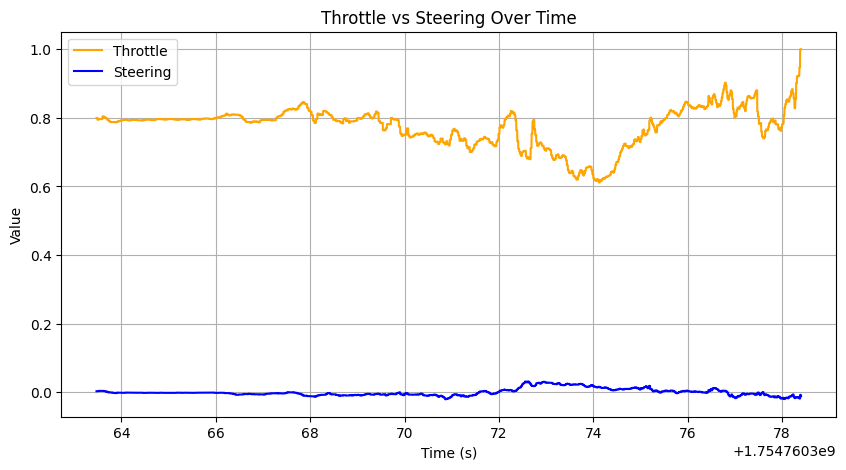

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV (change filename)
df = pd.read_csv("trajectory_log_ep2.csv")

# Column names (adjust to match your CSV)
time_col = "timestamp"  # or "frame"
throttle_col = "throttle"
steer_col = "steer"

# Plot both
plt.figure(figsize=(10,5))
plt.plot(df[time_col], df[throttle_col], label="Throttle", color="orange")
plt.plot(df[time_col], df[steer_col], label="Steering", color="blue")
plt.xlabel("Time (s)")
plt.ylabel("Value")
plt.title("Throttle vs Steering Over Time")
plt.legend()
plt.grid(True)
plt.show()


# Straight-video

In [ ]:
import carla
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
from PIL import Image
import time
import os
import random
import cv2
import gc
import imageio.v2 as imageio   # <-- for video writing


# ----------------- Model -----------------
class DrivingCNN(nn.Module):
    def __init__(self):
        super(DrivingCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 5, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, 5, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, 5, stride=2),
            nn.ReLU(),
        )
        self.fc1 = None
        self.fc2 = None

    def initialize(self, input_shape):
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            dummy_output = self.conv(dummy_input)
            fc_input_size = dummy_output.view(1, -1).shape[1]
        self.fc1 = nn.Linear(fc_input_size, 100)
        self.fc2 = nn.Linear(100, 3)

    def forward(self, x):
        if self.fc1 is None:
            raise RuntimeError("Call model.initialize((3, H, W)) first.")
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# ----------------- Image Preprocessing -----------------
def preprocess_image(image):
    transform = transforms.Compose([
        transforms.Resize((120, 160)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3),
    ])
    image = Image.fromarray(image)
    return transform(image).unsqueeze(0)


# ----------------- Single Episode -----------------
def run_episode(client, model, device, episode_num):
    print(f"\n=== Starting Episode {episode_num} ===")

    # Reload map
    world = client.load_world("Town05")
    time.sleep(2.0)

    blueprint_library = world.get_blueprint_library()
    vehicle_bp = blueprint_library.filter("model3")[0]
    spawn_point = random.choice(world.get_map().get_spawn_points())
    spawn_point.location.z += 0.5
    vehicle = world.spawn_actor(vehicle_bp, spawn_point)

    # Logging setup
    log_filename = f"trajectory_log_ep{episode_num}.csv"
    with open(log_filename, "w") as f:
        f.write("timestamp,steer,throttle,brake\n")

    image_dir = f"stmodelimages_ep{episode_num}"
    os.makedirs(image_dir, exist_ok=True)

    # Camera
    camera_bp = blueprint_library.find("sensor.camera.rgb")
    camera_bp.set_attribute("image_size_x", "800")#160
    camera_bp.set_attribute("image_size_y", "600")#120
    camera_bp.set_attribute("fov", "120")
    
    camera_transform = carla.Transform(carla.Location(x=-4.0, y=0.0, z=2.0), carla.Rotation(pitch=-5.0, yaw=0, roll=0)
    )
    camera = world.spawn_actor(camera_bp, camera_transform, attach_to=vehicle)

    # Collision sensor
    collision_bp = blueprint_library.find("sensor.other.collision")
    collision_sensor = world.spawn_actor(collision_bp, carla.Transform(), attach_to=vehicle)

    collision_count = 0
    collision_occurred = False
    start_time = time.time()

    def on_collision(event):
        nonlocal collision_count, collision_occurred
        collision_count += 1
        elapsed = time.time() - start_time
        print(f"[Episode {episode_num}] Collision #{collision_count} at {elapsed:.2f}s")
        collision_occurred = True

    collision_sensor.listen(on_collision)

    spectator = world.get_spectator()
    latest_image = None

    def camera_callback(image):
        nonlocal latest_image
        array = np.frombuffer(image.raw_data, dtype=np.uint8).reshape((image.height, image.width, 4))[:, :, :3]
        array = array[:, :, ::-1]  # BGR to RGB
        latest_image = array

    camera.listen(camera_callback)

    control = carla.VehicleControl()
    _map = world.get_map()
    start_location = None
    frame_count = 0

    try:
        while True:
            if latest_image is not None:
                filename = f"{image_dir}/{frame_count:06d}.png"
                cv2.imwrite(filename, cv2.cvtColor(latest_image, cv2.COLOR_RGB2BGR))
                frame_count += 1

                # Model prediction
                input_tensor = preprocess_image(latest_image).to(device)
                with torch.no_grad():
                    steer, throttle, brake = model(input_tensor)[0].cpu().numpy()



                steer = float(np.clip(steer, -1.0, 1.0))
                throttle = float(np.clip(throttle, 0.0, 1.0))
                brake = float(np.clip(brake, 0.0, 1.0))

                # Apply steering bias correction here:
                steering_bias = 0.002  # <-- tune this value as explained before
                steer += steering_bias

                # Clamp small values near zero to exactly zero (optional, helps reduce drift)
                if abs(steer) < 0.05:
                    steer = 0.0

                # if brake < 0.05:
                #     brake = 0.0

                control.steer, control.throttle, control.brake = steer, throttle, brake
                vehicle.apply_control(control)

                transform = vehicle.get_transform()
                location = transform.location
                rotation = transform.rotation

                waypoint = _map.get_waypoint(location)
                lane_offset = location.distance(waypoint.transform.location)

                timestamp = time.time()
                with open(log_filename, "a") as f:
                    f.write(f"{timestamp},{steer},{throttle},{brake}\n")

                if start_location is None:
                    start_location = location
                distance_traveled = location.distance(start_location)

                print(f"Steer: {steer:.3f}, Throttle: {throttle:.3f}, Brake: {brake:.3f}, LaneOffset: {lane_offset:.2f}")

                backward_vec = transform.get_forward_vector() * -6
                spectator_loc = location + backward_vec
                spectator_loc.z += 3
                spectator_rot = carla.Rotation(pitch=-15, yaw=rotation.yaw, roll=0)
                spectator.set_transform(carla.Transform(spectator_loc, spectator_rot))

                if collision_occurred:
                    print(f"[Episode {episode_num}] Ended after {distance_traveled:.2f}m")
                    break

    finally:
        camera.stop()
        camera.destroy()
        collision_sensor.stop()
        collision_sensor.destroy()
        vehicle.destroy()

        # Extra cleanup
        for actor in world.get_actors():
            if actor.is_alive and (actor.type_id.startswith('vehicle.') or actor.type_id.startswith('sensor.')):
                actor.destroy()
        gc.collect()

        print(f"=== Episode {episode_num} cleanup complete ===")

        # -------- Video creation per episode --------
        print(f"Generating video for Episode {episode_num}...")
        image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".png")])
        if image_files:
            output_video = f"output_drive_ep{episode_num}.mp4"
            fps = 40  # Adjust FPS if needed
            with imageio.get_writer(output_video, fps=fps) as writer:
                for img_file in image_files:
                    frame = imageio.imread(img_file)
                    writer.append_data(frame)
            print(f"Episode {episode_num} video saved as {output_video}")
        else:
            print(f"No images found for Episode {episode_num}, skipping video.")


# ----------------- Main -----------------
def main():
    os.environ["OMP_NUM_THREADS"] = "1"
    os.environ["MKL_NUM_THREADS"] = "1"
    torch.set_num_threads(1)

    client = carla.Client("localhost", 2000)
    client.set_timeout(10.0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = DrivingCNN()
    model.initialize((3, 120, 160))
    model.load_state_dict(torch.load("drive_sept_old.pth", map_location=device))
    model.to(device)
    model.eval()

    num_episodes = 3
    for ep in range(1, num_episodes + 1):
        run_episode(client, model, device, ep)


if __name__ == "__main__":
    main()


/tmp/ipykernel_1819044/635394043.py:226: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("drive_sept_old.pth", map_location=device))



=== Starting Episode 1 ===
Steer: 0.000, Throttle: 0.090, Brake: 0.597, LaneOffset: 0.53
Steer: 0.000, Throttle: 0.095, Brake: 0.596, LaneOffset: 0.50
Steer: 0.000, Throttle: 0.100, Brake: 0.607, LaneOffset: 0.46
Steer: 0.000, Throttle: 0.100, Brake: 0.632, LaneOffset: 0.36
Steer: 0.000, Throttle: 0.104, Brake: 0.658, LaneOffset: 0.31
Steer: 0.000, Throttle: 0.109, Brake: 0.676, LaneOffset: 0.25
Steer: 0.000, Throttle: 0.124, Brake: 0.664, LaneOffset: 0.12
Steer: 0.000, Throttle: 0.133, Brake: 0.644, LaneOffset: 0.04
Steer: 0.000, Throttle: 0.148, Brake: 0.611, LaneOffset: 0.00
Steer: 0.000, Throttle: 0.160, Brake: 0.551, LaneOffset: 0.04
Steer: 0.000, Throttle: 0.156, Brake: 0.485, LaneOffset: 0.08
Steer: 0.000, Throttle: 0.158, Brake: 0.461, LaneOffset: 0.07
Steer: 0.000, Throttle: 0.161, Brake: 0.443, LaneOffset: 0.07
Steer: 0.000, Throttle: 0.158, Brake: 0.456, LaneOffset: 0.06
Steer: 0.000, Throttle: 0.156, Brake: 0.461, LaneOffset: 0.06
Steer: 0.000, Throttle: 0.156, Brake: 0.46

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (800, 600) to (800, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


=== Episode 1 cleanup complete ===
Generating video for Episode 1...


In [6]:
# Your CNN model class (DrivingCNN) must be defined here or imported

import carla
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
from PIL import Image
import time
import os
import random
import imageio
import cv2
import imageio.v2 as imageio 
# Environment setup
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
torch.set_num_threads(1)


# ----------------- Model -----------------
class DrivingCNN(nn.Module):
    def __init__(self):
        super(DrivingCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 5, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, 5, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, 5, stride=2),
            nn.ReLU(),
        )
        self.fc1 = None
        self.fc2 = None

    def initialize(self, input_shape):
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            dummy_output = self.conv(dummy_input)
            fc_input_size = dummy_output.view(1, -1).shape[1]
        self.fc1 = nn.Linear(fc_input_size, 100)
        self.fc2 = nn.Linear(100, 3)

    def forward(self, x):
        if self.fc1 is None:
            raise RuntimeError("Call model.initialize((3, H, W)) first.")
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


def preprocess_image(image):
    transform = transforms.Compose(
        [
            transforms.Resize((120, 160)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3),
        ]
    )
    image = Image.fromarray(image)  # Convert numpy array (H,W,3) to PIL Image
    return transform(image).unsqueeze(0)  # Add batch dimension


def main():
    # Connect to CARLA
    client = carla.Client("localhost", 2000)
    client.set_timeout(10.0)
    world = client.get_world()

    _map = world.get_map()  # Get the map and waypoint

    blueprint_library = world.get_blueprint_library()
    vehicle_bp = blueprint_library.filter("model3")[0]  # Example Tesla Model 3

    # spawn_point = world.get_map().get_spawn_points()[0]

    spawn_points = world.get_map().get_spawn_points()
    spawn_point = random.choice(spawn_points)
    spawn_point.location.z += 0.5

    vehicle = world.spawn_actor(vehicle_bp, spawn_point)

    # Open a log file before the loop to write your trajectory
    log_filename = "trajectory_log_new.csv"
    with open(log_filename, "w") as f:
        f.write("timestamp,x,y,z,yaw,steer,throttle,brake,lane_offset\n")

    if not os.path.exists("model"):
        os.makedirs("model")

    # Setup camera sensor
    camera_bp = blueprint_library.find("sensor.camera.rgb")
    camera_bp.set_attribute("image_size_x", "160")
    camera_bp.set_attribute("image_size_y", "120")
    camera_bp.set_attribute("fov", "110")

    # camera_transform = carla.Transform(carla.Location(x=1.5, z=2.4))
    camera_transform = carla.Transform(
        carla.Location(x=-4.0, y=0.0, z=2.0), carla.Rotation(pitch=-5.0, yaw=0, roll=0)
    )
    camera = world.spawn_actor(camera_bp, camera_transform, attach_to=vehicle)

    # Setup collision sensor
    collision_bp = blueprint_library.find("sensor.other.collision")
    collision_sensor = world.spawn_actor(
        collision_bp, carla.Transform(), attach_to=vehicle
    )

    def on_collision(event):
        nonlocal collision_count, collision_occurred
        collision_count += 1
        collision_time = time.time()
        collision_times.append(collision_time)
        elapsed = collision_time - start_time
        print(f"Collision #{collision_count} detected at {elapsed:.2f} seconds")
        collision_occurred = True

    collision_sensor.listen(on_collision)

    spectator = world.get_spectator()

    collision_count = 0
    collision_times = []
    start_time = time.time()
    collision_occurred = False
    collision_time = None
    start_location = None

    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = DrivingCNN()
    model.initialize((3, 120, 160))
    model.load_state_dict(torch.load("drive_sept_old.pth", map_location=device))
    model.to(device)
    model.eval()

    control = carla.VehicleControl()

    # We use a variable to store latest image frame from camera sensor
    latest_image = None

    def camera_callback(image):
        nonlocal latest_image
        array = np.frombuffer(image.raw_data, dtype=np.uint8)
        array = array.reshape((image.height, image.width, 4))[:, :, :3]  # BGRA -> BGR
        array = array[:, :, ::-1]  # BGR -> RGB
        latest_image = array

    camera.listen(camera_callback)
    global deviations
    deviations = []
    frame_count = 0

    try:
        while True:
            if latest_image is not None:

                filename = f"model/{frame_count:06d}.png"
                cv2.imwrite(filename, cv2.cvtColor(latest_image, cv2.COLOR_RGB2BGR))
                frame_count += 1

                # Preprocess image
                input_tensor = preprocess_image(latest_image).to(device)

                # Model inference
                with torch.no_grad():
                    output = model(input_tensor)
                steer, throttle, brake = output[0].cpu().numpy()

                # Clamp controls to valid ranges
                steer = float(np.clip(steer, -1.0, 1.0))
                throttle = float(np.clip(throttle, 0.0, 1.0))
                brake = float(np.clip(brake, 0.0, 1.0))

                # Apply controls
                control.steer = steer
                control.throttle = throttle
                control.brake = brake
                vehicle.apply_control(control)

                # Now update spectator to follow vehicle from behind
                transform = vehicle.get_transform()
                location = transform.location
                rotation = transform.rotation

                # Get vehicle velocity and compute speed
                velocity = vehicle.get_velocity()
                speed = (velocity.x**2 + velocity.y**2 + velocity.z**2) ** 0.5
                print(f"Speed: {speed:.3f} m/s")

                # Get lane center offset
                waypoint = _map.get_waypoint(location)
                lane_center = waypoint.transform.location
                lane_offset = location.distance(lane_center)

                # Log to file
                timestamp = time.time()
                with open(log_filename, "a") as f:
                    f.write(
                        f"{timestamp},{location.x},{location.y},{location.z},{rotation.yaw},"
                        f"{steer},{throttle},{brake},{lane_offset}\n"
                    )

                deviations.append(lane_offset)
                # Distance from start
                if start_location is None:
                    start_location = location
                distance_traveled = location.distance(start_location)

                # Print or log control values and vehicle position
                print(
                    f"Pos: ({location.x:.2f}, {location.y:.2f}, {location.z:.2f}), "
                    f"Yaw: {rotation.yaw:.2f}, "
                    f"Steer: {steer:.3f}, Throttle: {throttle:.3f}, Brake: {brake:.3f}"
                )
                print(f"Distance from lane center: {lane_offset:.2f} meters")

                # Update spectator position
                backward_vec = transform.get_forward_vector() * -6
                spectator_loc = location + backward_vec
                spectator_loc.z += 3

                spectator_rot = carla.Rotation(pitch=-15, yaw=rotation.yaw, roll=0)

                spectator.set_transform(carla.Transform(spectator_loc, spectator_rot))

                # Stop if collision
                if collision_occurred:
                    total_duration = time.time() - start_time
                    collision_rate = (
                        collision_count / total_duration if total_duration > 0 else 0
                    )
                    print(f"Total collisions: {collision_count}")
                    print(f"Total duration: {total_duration:.2f} seconds")
                    print(f"Collision rate: {collision_rate:.4f} collisions per second")
                    print(
                        f"Final distance before collision: {distance_traveled:.2f} meters"
                    )
                    break

                # time.sleep(0.05)

    finally:
        camera.stop()
        camera.destroy()
        collision_sensor.stop()
        collision_sensor.destroy()
        vehicle.destroy()
        print("All actors destroyed.")

        print("Generating video output_drive.mp4 from saved frames...")

        


if __name__ == "__main__":
    main()

/tmp/ipykernel_1819894/2013607126.py:136: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("drive_sept_old.pth", map_location=device))


Speed: 1.250 m/s
Pos: (35.08, -154.97, 0.72), Yaw: -88.47, Steer: -0.031, Throttle: 0.129, Brake: 0.572
Distance from lane center: 0.72 meters
Speed: 1.250 m/s
Pos: (35.08, -154.97, 0.72), Yaw: -88.47, Steer: -0.031, Throttle: 0.129, Brake: 0.572
Distance from lane center: 0.72 meters
Speed: 1.250 m/s
Pos: (35.08, -154.97, 0.72), Yaw: -88.47, Steer: -0.031, Throttle: 0.129, Brake: 0.572
Distance from lane center: 0.72 meters
Speed: 1.250 m/s
Pos: (35.08, -154.97, 0.72), Yaw: -88.47, Steer: -0.031, Throttle: 0.129, Brake: 0.572
Distance from lane center: 0.72 meters
Speed: 1.528 m/s
Pos: (35.08, -154.97, 0.67), Yaw: -88.47, Steer: -0.031, Throttle: 0.129, Brake: 0.572
Distance from lane center: 0.67 meters
Speed: 1.528 m/s
Pos: (35.08, -154.97, 0.67), Yaw: -88.47, Steer: -0.031, Throttle: 0.129, Brake: 0.572
Distance from lane center: 0.67 meters
Speed: 1.528 m/s
Pos: (35.08, -154.97, 0.67), Yaw: -88.47, Steer: -0.031, Throttle: 0.129, Brake: 0.572
Distance from lane center: 0.67 meters

KeyboardInterrupt: 

In [6]:
import imageio.v2 as imageio
from natsort import natsorted
import os

image_folder = "model"
output_video = "output_drive.mp4"
fps = 80  # Adjust if your frames were saved faster/slower

# Collect and sort PNG frames
image_files = [
    os.path.join(image_folder, f)
    for f in os.listdir(image_folder)
    if f.endswith(".png")
]
image_files = natsorted(image_files)  # Natural sort: 1, 2, ..., 10, 11

if not image_files:
    print("No PNG frames found in model/ folder.")
else:
    print(f"Found {len(image_files)} frames. Creating video...")
    with imageio.get_writer(output_video, fps=fps, codec="libx264") as writer:
        for img_path in image_files:
            img = imageio.imread(img_path)
            writer.append_data(img)
    print(f"Video saved as: {output_video}")


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 120) to (160, 128) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Found 3296 frames. Creating video...
Video saved as: output_drive.mp4


# SUCCESS- model closed loop video

In [1]:
import carla
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
from PIL import Image
import time
import os
import random
import cv2
import gc
import imageio.v2 as imageio
import signal
import math

# Environment setup
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
torch.set_num_threads(1)


# ----------------- Model -----------------
class DrivingNet(nn.Module):
    def __init__(self, in_ch=3, n_stack=1, use_speed=True):
        super().__init__()
        C = in_ch * n_stack
        self.use_speed = use_speed
        self.conv = nn.Sequential(
            nn.Conv2d(C, 24, kernel_size=5, stride=2), nn.BatchNorm2d(24), nn.ReLU(),
            nn.Conv2d(24,36, kernel_size=5, stride=2), nn.BatchNorm2d(36), nn.ReLU(),
            nn.Conv2d(36,48, kernel_size=5, stride=2), nn.BatchNorm2d(48), nn.ReLU(),
            nn.Conv2d(48,64, kernel_size=3, stride=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64,64, kernel_size=3, stride=1), nn.BatchNorm2d(64), nn.ReLU()
        )
        self._feat = None
        self.fc = None
        self.speed_fc = nn.Sequential(nn.Linear(1, 16), nn.ReLU()) if use_speed else None

    def initialize(self, input_shape):
        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape, device=next(self.parameters()).device)
            out = self.conv(dummy)
            self._feat = int(out.view(1, -1).shape[1])
        fc_in = self._feat + (16 if self.use_speed else 0)
        self.fc = nn.Sequential(
            nn.Linear(fc_in, 100), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(100, 50), nn.ReLU()
        )
        self.steer_head = nn.Linear(50, 1)
        self.throttle_head = nn.Linear(50, 1)
        self.brake_head = nn.Linear(50, 1)

    def forward(self, x, aux=None):
        device = next(self.parameters()).device
        x = x.to(device)
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        if self.use_speed and aux is not None:
            aux = aux.to(device).float()
            if aux.dim() == 1:
                aux = aux.unsqueeze(1)
            aux = self.speed_fc(aux)
            x = torch.cat([x, aux], dim=1)
        x = self.fc(x)
        steer = torch.tanh(self.steer_head(x))
        throttle = torch.sigmoid(self.throttle_head(x))
        brake = torch.sigmoid(self.brake_head(x))
        return torch.cat([steer, throttle, brake], dim=1)


def preprocess_image_stack(frame_stack, device):
    """
    Preprocess a stack of 3 RGB frames for the model.
    Matches the exact preprocessing used during training.
    """
    if len(frame_stack) != 3:
        return None
    
    processed_frames = []
    
    # Process each frame individually first (as they would be during training)
    for frame in frame_stack:
        # Resize if needed (should already be 120x160)
        if frame.shape[:2] != (120, 160):
            frame = cv2.resize(frame, (160, 120))
        
        # Convert to float32 and normalize to [0, 1]
        frame = frame.astype(np.float32) / 255.0
        
        # Normalize to [-1, 1] range (standard ImageNet-style normalization)
        frame = (frame - 0.5) / 0.5
        
        processed_frames.append(frame)
    
    # Stack the processed frames along channel dimension
    # This creates a (120, 160, 9) array
    stacked = np.concatenate(processed_frames, axis=2)
    
    # Convert to CHW format for PyTorch (9, 120, 160)
    stacked = np.transpose(stacked, (2, 0, 1))
    
    # Convert to tensor and add batch dimension
    tensor = torch.from_numpy(stacked).float().unsqueeze(0)  # (1, 9, 120, 160)
    
    return tensor.to(device)


class ImprovedPIDController:
    """Enhanced PID controller with better tuning and safeguards"""
    
    def __init__(self):
        # PID gains - tuned for better lane keeping
        self.Kp = 0.8  # Increased proportional gain
        self.Ki = 0.02  # Reduced integral gain to prevent windup
        self.Kd = 0.15  # Increased derivative gain for stability
        
        # State variables
        self.integral = 0.0
        self.prev_error = 0.0
        self.prev_time = None
        
        # Anti-windup limits
        self.integral_limit = 0.5
        self.output_limit = 0.6  # Reduced steering limit
        
    def update(self, error, current_time):
        """Update PID controller with current error"""
        if self.prev_time is None:
            self.prev_time = current_time
            dt = 0.05  # Default dt
        else:
            dt = max(current_time - self.prev_time, 0.001)  # Prevent division by zero
            self.prev_time = current_time
        
        # Proportional term
        P = self.Kp * error
        
        # Integral term with anti-windup
        self.integral += error * dt
        self.integral = np.clip(self.integral, -self.integral_limit, self.integral_limit)
        I = self.Ki * self.integral
        
        # Derivative term with smoothing
        if dt > 0:
            derivative = (error - self.prev_error) / dt
            D = self.Kd * derivative
        else:
            D = 0.0
        
        self.prev_error = error
        
        # Combine and limit output
        output = P + I + D
        return np.clip(output, -self.output_limit, self.output_limit)
    
    def reset(self):
        """Reset PID controller state"""
        self.integral = 0.0
        self.prev_error = 0.0
        self.prev_time = None


class ClosedLoopEvaluator:
    def __init__(self, model_path, host="localhost", port=2000):
        self.model_path = model_path
        self.host = host
        self.port = port
        self.running = True

        # Enhanced control system
        self.pid_controller = ImprovedPIDController()
        self.throttle_smooth = 0.3
        self.steer_smooth = 0.0
        
        # Control smoothing parameters
        self.steer_alpha = 0.3  # Steering smoothing factor
        self.throttle_alpha = 0.2  # Throttle smoothing factor
        
        # Lane keeping parameters
        self.target_speed_kmh = 15  # Target speed in km/h
        self.max_lane_offset = 2.0  # Maximum allowed lane offset before correction
        
        # Statistics
        self.collision_count = 0
        self.collision_times = []
        self.deviations = []
        self.controls_history = []
        self.trajectory = []
        
        # Setup signal handler for graceful shutdown
        signal.signal(signal.SIGINT, self.signal_handler)

    def calculate_lane_error(self, vehicle_location, vehicle_rotation):
        """Calculate lateral error from lane center using CARLA waypoints"""
        try:
            # Get the nearest waypoint
            waypoint = self.map.get_waypoint(vehicle_location, project_to_road=True, lane_type=carla.LaneType.Driving)
            
            if waypoint is None:
                return 0.0
            
            # Calculate lateral offset
            lane_center = waypoint.transform.location
            
            # Vector from lane center to vehicle
            dx = vehicle_location.x - lane_center.x
            dy = vehicle_location.y - lane_center.y
            
            # Get lane direction (perpendicular to road direction)
            lane_yaw = math.radians(waypoint.transform.rotation.yaw)
            
            # Calculate cross-track error (positive = right of center, negative = left)
            cross_track_error = dx * math.sin(lane_yaw) - dy * math.cos(lane_yaw)
            
            # Calculate heading error (difference between vehicle and lane heading)
            vehicle_yaw = math.radians(vehicle_rotation.yaw)
            heading_error = vehicle_yaw - lane_yaw
            
            # Normalize heading error to [-pi, pi]
            while heading_error > math.pi:
                heading_error -= 2 * math.pi
            while heading_error < -math.pi:
                heading_error += 2 * math.pi
            
            # Combine cross-track and heading errors
            # Weight heading error more heavily for better stability
            total_error = cross_track_error + 0.5 * heading_error
            
            return total_error
            
        except Exception as e:
            print(f"Error calculating lane error: {e}")
            return 0.0

    def adaptive_speed_control(self, current_speed_mps, lane_offset, steering_magnitude):
        """Adaptive speed control based on lane position and steering input"""
        target_speed_mps = self.target_speed_kmh / 3.6
        
        # Reduce speed when far from lane center or steering heavily
        offset_factor = max(0.7, 1.0 - abs(lane_offset) / 3.0)  # Slow down if offset > 1.5m
        steering_factor = max(0.8, 1.0 - abs(steering_magnitude) / 0.5)  # Slow down during sharp turns
        
        adjusted_target = target_speed_mps * offset_factor * steering_factor
        
        # Simple speed controller
        speed_error = adjusted_target - current_speed_mps
        
        if speed_error > 0:
            throttle = min(0.7, 0.4 + speed_error * 0.3)
        else:
            throttle = max(0.2, 0.4 + speed_error * 0.2)
            
        return throttle

    def signal_handler(self, sig, frame):
        print("\nGraceful shutdown initiated...")
        self.running = False
        
    def connect_carla(self):
        """Connect to CARLA simulator"""
        self.client = carla.Client(self.host, self.port)
        self.client.set_timeout(10.0)
        self.world = self.client.get_world()
        # self.world = self.client.load_world("Town05")
        self.map = self.world.get_map()
        
        # Set synchronous mode for stable evaluation
        settings = self.world.get_settings()
        settings.synchronous_mode = True
        settings.fixed_delta_seconds = 0.05  # 20 FPS
        self.world.apply_settings(settings)
        
    def spawn_vehicle(self):
        """Spawn vehicle at random location"""
        blueprint_library = self.world.get_blueprint_library()
        
        # Use a standard vehicle
        vehicle_bp = blueprint_library.filter("vehicle.mercedes.coupe_2020")[0]
        if not vehicle_bp:
            vehicle_bp = blueprint_library.filter("vehicle.*")[0]
        
        # Get spawn point
        spawn_points = self.map.get_spawn_points()
        spawn_point = random.choice(spawn_points)
        spawn_point.location.z += 0.5
        
        self.vehicle = self.world.spawn_actor(vehicle_bp, spawn_point)
        print(f"Spawned vehicle at: ({spawn_point.location.x:.2f}, {spawn_point.location.y:.2f})")
        
        return spawn_point.location
        
    def setup_sensors(self):
        """Setup camera and collision sensors"""
        blueprint_library = self.world.get_blueprint_library()
        
        # Camera sensor (set exactly like CNN script: 800x600, fov 120, camera at x=-4 pitch=-5)
        camera_bp = blueprint_library.find("sensor.camera.rgb")
        camera_bp.set_attribute("image_size_x", "800")
        camera_bp.set_attribute("image_size_y", "600")
        camera_bp.set_attribute("fov", "120")
        
        camera_transform = carla.Transform(carla.Location(x=-4, y=0, z=2), carla.Rotation(pitch=-5))
        self.camera = self.world.spawn_actor(camera_bp, camera_transform, attach_to=self.vehicle)
        
        # Collision sensor
        collision_bp = blueprint_library.find("sensor.other.collision")
        self.collision_sensor = self.world.spawn_actor(
            collision_bp, carla.Transform(), attach_to=self.vehicle
        )
        
        # Setup callbacks
        self.latest_image = None
        self.new_image_available = False
        self.collision_occurred = False
        
        self.camera.listen(self.camera_callback)
        self.collision_sensor.listen(self.collision_callback)
        
    def camera_callback(self, image):
        """Process camera images (match CNN script format: RGB)"""
        array = np.frombuffer(image.raw_data, dtype=np.uint8)
        array = array.reshape((image.height, image.width, 4))[:, :, :3]  # BGRA -> BGR
        array = array[:, :, ::-1]  # BGR -> RGB
        self.latest_image = array
        self.new_image_available = True
        
    def collision_callback(self, event):
        """Handle collision events"""
        self.collision_count += 1
        collision_time = time.time() - self.start_time
        self.collision_times.append(collision_time)
        print(f"\n*** Collision #{self.collision_count} at {collision_time:.2f}s ***")
        print(f"    Impact with: {event.other_actor.type_id}")
        self.collision_occurred = True

        if self.collision_occurred:
            # Reset speed to 0 to stop the vehicle
            self.vehicle.set_velocity(carla.Vector3D(0, 0, 0))
            
            # Reset PID controller
            self.pid_controller.reset()
            
            # Neutralize steering for recovery
            control = carla.VehicleControl()
            control.steer = 0.0
            self.vehicle.apply_control(control)
            
            # Wait before continuing
            time.sleep(1)
            self.collision_occurred = False

    def load_model(self):
        """Load the trained model"""
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        # Initialize model
        self.model = DrivingNet(in_ch=3, n_stack=3, use_speed=True).to(self.device)
        self.model.initialize((9, 120, 160))
        self.model = self.model.to(self.device) 
        
        # Load weights
        if os.path.exists(self.model_path):
            checkpoint = torch.load(self.model_path, map_location=self.device, weights_only=False)
            self.model.load_state_dict(checkpoint)
            print(f"Model loaded successfully from {self.model_path}")
        else:
            raise FileNotFoundError(f"Model checkpoint not found at {self.model_path}")
            
        self.model.eval()
        
    def run_evaluation(self):
        """Main evaluation loop with enhanced lane keeping"""
        print("\n" + "="*60)
        print("ENHANCED CLOSED-LOOP EVALUATION STARTED")
        print("="*60)
        print("Press Ctrl+C to stop evaluation gracefully\n")
        
        # Initialize
        self.connect_carla()
        start_location = self.spawn_vehicle()
        self.setup_sensors()
        self.load_model()
        
        # Setup spectator
        spectator = self.world.get_spectator()
        
        # Initialize control
        control = carla.VehicleControl()
        control.manual_gear_shift = False
        
        # Wait for initial frames
        print("Warming up sensors...")
        for _ in range(10):
            self.world.tick()
            time.sleep(0.05)
        
        # Initialize variables
        frame_stack = []
        frame_count = 0
        self.start_time = time.time()
        last_log_time = time.time()
        
        # Open log file
        log_filename = f"enhanced_evaluation_log_{int(self.start_time)}.csv"
        log_file = open(log_filename, "w")
        log_file.write("timestamp,frame,x,y,z,yaw,speed_mps,speed_kmh,model_steer,final_steer,throttle,lane_error,distance_traveled\n")
        
        # Image directory for video frames (using CNN-style naming)
        image_dir = f"enhanced_eval_images_{int(self.start_time)}"
        os.makedirs(image_dir, exist_ok=True)
        
        print("Starting enhanced autonomous driving...\n")
        
        try:
            while self.running and not self.collision_occurred:
                # Update frame stack
                if self.new_image_available and self.latest_image is not None:
                    frame_stack.append(self.latest_image.copy())
                    if len(frame_stack) > 3:
                        frame_stack.pop(0)
                    self.new_image_available = False
                
                # Process when we have 3 frames
                if len(frame_stack) == 3:
                    # Get vehicle state
                    transform = self.vehicle.get_transform()
                    location = transform.location
                    rotation = transform.rotation
                    
                    # Calculate speed
                    velocity = self.vehicle.get_velocity()
                    speed_mps = np.sqrt(velocity.x**2 + velocity.y**2 + velocity.z**2)
                    speed_kmh = speed_mps * 3.6
                    
                    # Calculate lane error
                    lane_error = self.calculate_lane_error(location, rotation)
                    
                    # Preprocess frames for model
                    input_tensor = preprocess_image_stack(frame_stack, self.device)
                    
                    if input_tensor is not None:
                        # Prepare speed input
                        speed_normalized = min(speed_mps / 30.0, 1.0)
                        speed_tensor = torch.tensor([[speed_normalized]], dtype=torch.float32, device=self.device)
                        
                        # Model inference
                        with torch.no_grad():
                            output = self.model(input_tensor, aux=speed_tensor)
                        
                        # Extract model outputs
                        model_steer, model_throttle, model_brake = output[0].cpu().numpy()
                        
                        # Enhanced steering control combining model output and lane keeping
                        current_time = time.time()
                        
                        # Use PID controller to correct lane error
                        pid_correction = self.pid_controller.update(lane_error, current_time)
                        
                        # Combine model steering with PID correction
                        # Give more weight to PID when lane error is large
                        error_weight = min(abs(lane_error) / 1.0, 0.8)  # Max 80% PID weight
                        combined_steer = (1 - error_weight) * model_steer + error_weight * pid_correction
                        
                        # Apply steering smoothing
                        final_steer = (self.steer_alpha * combined_steer + 
                                     (1 - self.steer_alpha) * self.steer_smooth)
                        self.steer_smooth = final_steer
                        
                        # Clamp steering to safe limits
                        final_steer = np.clip(final_steer, -0.6, 0.6)
                        
                        # Adaptive throttle control
                        adaptive_throttle = self.adaptive_speed_control(speed_mps, lane_error, abs(final_steer))
                        
                        # Apply throttle smoothing
                        final_throttle = (self.throttle_alpha * adaptive_throttle + 
                                        (1 - self.throttle_alpha) * self.throttle_smooth)
                        self.throttle_smooth = final_throttle
                        
                        # Ensure minimum throttle to prevent stalling
                        final_throttle = max(final_throttle, 0.2)
                        final_throttle = min(final_throttle, 0.8)
                        
                        # Apply controls
                        control.steer = float(final_steer)
                        control.throttle = float(final_throttle)
                        control.brake = 0.0
                        control.hand_brake = False
                        self.vehicle.apply_control(control)
                        
                        # Save frame exactly like CNN script
                        try:
                            frame_filename = os.path.join(image_dir, f"{frame_count:06d}.png")
                            cv2.imwrite(frame_filename, cv2.cvtColor(self.latest_image, cv2.COLOR_RGB2BGR))
                        except Exception as e:
                            print(f"Warning: failed to save frame {frame_count}: {e}")
                    
                        # Calculate metrics
                        distance_traveled = location.distance(start_location)
                        
                        # Store data
                        self.deviations.append(abs(lane_error))
                        self.controls_history.append({
                            'frame': frame_count,
                            'model_steer': model_steer,
                            'final_steer': final_steer,
                            'throttle': final_throttle,
                            'speed': speed_mps,
                            'lane_error': lane_error
                        })
                        self.trajectory.append({
                            'x': location.x,
                            'y': location.y,
                            'z': location.z,
                            'yaw': rotation.yaw
                        })
                        
                        # Log to file
                        timestamp = time.time() - self.start_time
                        log_file.write(
                            f"{timestamp:.3f},{frame_count},{location.x:.2f},{location.y:.2f},{location.z:.2f},"
                            f"{rotation.yaw:.2f},{speed_mps:.3f},{speed_kmh:.1f},{model_steer:.4f},"
                            f"{final_steer:.4f},{final_throttle:.4f},{lane_error:.4f},{distance_traveled:.2f}\n"
                        )
                        log_file.flush()
                        
                        # Update spectator view (use CNN-style spectator follow: -6 and z=3, pitch=-15)
                        transform = self.vehicle.get_transform()
                        loc = transform.location
                        rot = transform.rotation
                        spectator.set_transform(carla.Transform(loc + transform.get_forward_vector()*-6 + carla.Location(z=3),
                                                                carla.Rotation(pitch=-15, yaw=rot.yaw)))
                        
                        # Print status every second
                        current_time = time.time()
                        if current_time - last_log_time >= 1.0:
                            print(f"[{timestamp:6.1f}s] Frame {frame_count:5d} | "
                                  f"Speed: {speed_kmh:5.1f} km/h | "
                                  f"Distance: {distance_traveled:6.1f}m | "
                                  f"Lane error: {lane_error:+.3f}m | "
                                  f"Steering (M/F): {model_steer:+.3f}/{final_steer:+.3f}")
                            last_log_time = current_time
                    
                    frame_count += 1
                
                # Tick the simulation
                self.world.tick()

        except Exception as e:
            print(f"\nError during evaluation: {e}")
            
        finally:
            # Close log file
            log_file.close()
            
            # Create video from saved frames (exact CNN-style logic)
            try:
                images = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".png")])
                if images:
                    out_video = f"enhanced_evaluation_video_{int(self.start_time)}.mp4"
                    with imageio.get_writer(out_video, fps=30) as writer:
                        for img in images:
                            writer.append_data(imageio.imread(img))
                    print(f"Enhanced evaluation video saved as {out_video}")
            except Exception as e:
                print(f"Warning: failed to create video: {e}")
            finally:
                try:
                    gc.collect()
                except:
                    pass
            
            # Print final statistics
            self.print_statistics(frame_count)
            
            # Cleanup
            self.cleanup()

    def print_statistics(self, frame_count):
        """Print enhanced evaluation statistics"""
        elapsed_time = time.time() - self.start_time
        
        print("\n" + "="*60)
        print("ENHANCED EVALUATION STATISTICS")
        print("="*60)
        
        print(f"Total frames processed: {frame_count}")
        print(f"Total time: {elapsed_time:.2f} seconds")
        print(f"Average FPS: {frame_count/elapsed_time:.2f}")
        print(f"Total collisions: {self.collision_count}")
        
        if len(self.deviations) > 0:
            print(f"\nLane keeping performance:")
            print(f"  Average offset: {np.mean(self.deviations):.3f} meters")
            print(f"  Std deviation: {np.std(self.deviations):.3f} meters")
            print(f"  Max offset: {np.max(self.deviations):.3f} meters")
            print(f"  95th percentile: {np.percentile(self.deviations, 95):.3f} meters")
            
            # Calculate percentage of time within lane bounds
            within_lane = np.sum(np.array(self.deviations) <= 1.5) / len(self.deviations) * 100
            print(f"  Time within 1.5m of lane center: {within_lane:.1f}%")
            
        if len(self.trajectory) > 0:
            first_pos = self.trajectory[0]
            last_pos = self.trajectory[-1]
            total_distance = np.sqrt(
                (last_pos['x'] - first_pos['x'])**2 + 
                (last_pos['y'] - first_pos['y'])**2
            )
            print(f"\nTotal distance traveled: {total_distance:.2f} meters")
            
        if len(self.controls_history) > 0:
            all_speeds = [c['speed'] for c in self.controls_history]
            all_lane_errors = [c['lane_error'] for c in self.controls_history]
            
            print(f"\nSpeed statistics:")
            print(f"  Average speed: {np.mean(all_speeds)*3.6:.2f} km/h")
            print(f"  Max speed: {np.max(all_speeds)*3.6:.2f} km/h")
            
            print(f"\nLane error statistics:")
            print(f"  Mean absolute error: {np.mean(np.abs(all_lane_errors)):.3f} meters")
            print(f"  RMS error: {np.sqrt(np.mean(np.array(all_lane_errors)**2)):.3f} meters")
                
        print("="*60)
        
    def cleanup(self):
        """Clean up CARLA actors and reset settings"""
        print("\nCleaning up...")
        
        # Reset to asynchronous mode
        if hasattr(self, 'world'):
            settings = self.world.get_settings()
            settings.synchronous_mode = False
            self.world.apply_settings(settings)
        
        # Destroy actors
        actors_to_destroy = []
        if hasattr(self, 'camera'):
            try:
                self.camera.stop()
            except:
                pass
            actors_to_destroy.append(self.camera)
        if hasattr(self, 'collision_sensor'):
            try:
                self.collision_sensor.stop()
            except:
                pass
            actors_to_destroy.append(self.collision_sensor)
        if hasattr(self, 'vehicle'):
            actors_to_destroy.append(self.vehicle)
            
        for actor in actors_to_destroy:
            if actor is not None:
                try:
                    actor.destroy()
                except:
                    pass
                
        print("Cleanup complete.")


def main():
    # Path to your trained model
    MODEL_PATH = "/home/robotuser/carla_0.9.12/PythonAPI/examples/checkpoints/new_best_model.pth"
    
    # Create evaluator and run
    evaluator = ClosedLoopEvaluator(model_path=MODEL_PATH)
    evaluator.run_evaluation()


if __name__ == "__main__":
    main()



ENHANCED CLOSED-LOOP EVALUATION STARTED
Press Ctrl+C to stop evaluation gracefully

Spawned vehicle at: (-113.40, -25.77)
Using device: cuda
Model loaded successfully from /home/robotuser/carla_0.9.12/PythonAPI/examples/checkpoints/new_best_model.pth
Warming up sensors...
Starting enhanced autonomous driving...

[   1.0s] Frame    44 | Speed:  14.0 km/h | Distance:    1.5m | Lane error: -0.048m | Steering (M/F): +0.020/+0.018
[   2.0s] Frame    94 | Speed:  12.7 km/h | Distance:   10.4m | Lane error: -0.201m | Steering (M/F): +0.002/-0.031
[   3.0s] Frame   145 | Speed:  13.2 km/h | Distance:   19.4m | Lane error: -0.092m | Steering (M/F): +0.021/+0.009
[   4.0s] Frame   196 | Speed:  13.2 km/h | Distance:   28.8m | Lane error: -0.120m | Steering (M/F): +0.018/+0.001
[   5.1s] Frame   248 | Speed:  13.2 km/h | Distance:   38.2m | Lane error: -0.133m | Steering (M/F): +0.014/+0.003

Graceful shutdown initiated...

ENHANCED EVALUATION STATISTICS
Total frames processed: 280
Total time: 5

# lane chane-11/10

In [3]:
import carla
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
from PIL import Image
import time
import os
import random
import cv2
import gc
import imageio.v2 as imageio
import signal
import math
import traceback

# Environment setup
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
torch.set_num_threads(1)


# ----------------- Model -----------------
class DrivingNet(nn.Module):
    def __init__(self, in_ch=3, n_stack=1, use_speed=True):
        super().__init__()
        C = in_ch * n_stack
        self.use_speed = use_speed
        self.conv = nn.Sequential(
            nn.Conv2d(C, 24, kernel_size=5, stride=2), nn.BatchNorm2d(24), nn.ReLU(),
            nn.Conv2d(24,36, kernel_size=5, stride=2), nn.BatchNorm2d(36), nn.ReLU(),
            nn.Conv2d(36,48, kernel_size=5, stride=2), nn.BatchNorm2d(48), nn.ReLU(),
            nn.Conv2d(48,64, kernel_size=3, stride=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64,64, kernel_size=3, stride=1), nn.BatchNorm2d(64), nn.ReLU()
        )
        self._feat = None
        self.fc = None
        self.speed_fc = nn.Sequential(nn.Linear(1, 16), nn.ReLU()) if use_speed else None

    def initialize(self, input_shape):
        with torch.no_grad():
            # create a dummy on cpu first (we'll move model to device outside)
            dummy = torch.zeros(1, *input_shape)
            out = self.conv(dummy)
            self._feat = int(out.view(1, -1).shape[1])
        fc_in = self._feat + (16 if self.use_speed else 0)
        self.fc = nn.Sequential(
            nn.Linear(fc_in, 100), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(100, 50), nn.ReLU()
        )
        self.steer_head = nn.Linear(50, 1)
        self.throttle_head = nn.Linear(50, 1)
        self.brake_head = nn.Linear(50, 1)

    def forward(self, x, aux=None):
        device = next(self.parameters()).device
        x = x.to(device)
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        if self.use_speed and aux is not None:
            aux = aux.to(device).float()
            if aux.dim() == 1:
                aux = aux.unsqueeze(1)
            aux = self.speed_fc(aux)
            x = torch.cat([x, aux], dim=1)
        x = self.fc(x)
        steer = torch.tanh(self.steer_head(x))
        throttle = torch.sigmoid(self.throttle_head(x))
        brake = torch.sigmoid(self.brake_head(x))
        return torch.cat([steer, throttle, brake], dim=1)


def preprocess_image_stack(frame_stack, device):
    """
    Preprocess a stack of 3 RGB frames for the model.
    Matches the exact preprocessing used during training.
    """
    if len(frame_stack) != 3:
        return None

    processed_frames = []

    # Process each frame individually first (as they would be during training)
    for frame in frame_stack:
        # Resize if needed (should already be 120x160)
        if frame.shape[:2] != (120, 160):
            frame = cv2.resize(frame, (160, 120))

        # Convert to float32 and normalize to [0, 1]
        frame = frame.astype(np.float32) / 255.0

        # Normalize to [-1, 1] range (standard ImageNet-style normalization)
        frame = (frame - 0.5) / 0.5

        processed_frames.append(frame)

    # Stack the processed frames along channel dimension
    # This creates a (120, 160, 9) array
    stacked = np.concatenate(processed_frames, axis=2)

    # Convert to CHW format for PyTorch (9, 120, 160)
    stacked = np.transpose(stacked, (2, 0, 1))

    # Convert to tensor and add batch dimension
    tensor = torch.from_numpy(stacked).float().unsqueeze(0)  # (1, 9, 120, 160)

    return tensor.to(device)


class ImprovedPIDController:
    """Enhanced PID controller with better tuning and safeguards"""

    def __init__(self):
        # PID gains - tuned for better lane keeping
        self.Kp = 0.8  # Increased proportional gain
        self.Ki = 0.02  # Reduced integral gain to prevent windup
        self.Kd = 0.15  # Increased derivative gain for stability

        # State variables
        self.integral = 0.0
        self.prev_error = 0.0
        self.prev_time = None

        # Anti-windup limits
        self.integral_limit = 0.5
        self.output_limit = 0.6  # Reduced steering limit

    def update(self, error, current_time):
        """Update PID controller with current error"""
        if self.prev_time is None:
            self.prev_time = current_time
            dt = 0.05  # Default dt
        else:
            dt = max(current_time - self.prev_time, 0.001)  # Prevent division by zero
            self.prev_time = current_time

        # Proportional term
        P = self.Kp * error

        # Integral term with anti-windup
        self.integral += error * dt
        self.integral = np.clip(self.integral, -self.integral_limit, self.integral_limit)
        I = self.Ki * self.integral

        # Derivative term with smoothing
        if dt > 0:
            derivative = (error - self.prev_error) / dt
            D = self.Kd * derivative
        else:
            D = 0.0

        self.prev_error = error

        # Combine and limit output
        output = P + I + D
        return np.clip(output, -self.output_limit, self.output_limit)

    def reset(self):
        """Reset PID controller state"""
        self.integral = 0.0
        self.prev_error = 0.0
        self.prev_time = None


class ClosedLoopEvaluator:
    def __init__(self, model_path, host="localhost", port=2000):
        self.model_path = model_path
        self.host = host
        self.port = port
        self.running = True

        # Enhanced control system
        self.pid_controller = ImprovedPIDController()
        self.throttle_smooth = 0.3
        self.steer_smooth = 0.0

        # Control smoothing parameters
        self.steer_alpha = 0.3  # Steering smoothing factor
        self.throttle_alpha = 0.2  # Throttle smoothing factor

        # Lane keeping parameters
        self.target_speed_kmh = 15  # Target speed in km/h
        self.max_lane_offset = 2.0  # Maximum allowed lane offset before correction

        # Lane change state
        self.lane_change_active = False
        self.lane_change_target_waypoints = []  # list of waypoints to follow when changing lane
        self.lane_change_start_time = None
        self.lane_change_duration = 2.5  # seconds over which we attempt lane change
        self.last_lane_change_time = 0.0
        self.lane_change_interval = random.uniform(15.0, 25.0)  # initial wait

        # Safety thresholds
        self.lane_change_min_gap = 10.0  # minimum meters ahead to plan lane change
        self.lane_change_finish_threshold = 0.25  # meters center after which it's considered complete

        # Statistics
        self.collision_count = 0
        self.collision_times = []
        self.deviations = []
        self.controls_history = []
        self.trajectory = []

        # CARLA placeholders
        self.client = None
        self.world = None
        self.map = None
        self.vehicle = None
        self.camera = None
        self.collision_sensor = None
        self.latest_image = None
        self.new_image_available = False
        self.collision_occurred = False
        self.start_time = None
        self.original_settings = None

        # Setup signal handler for graceful shutdown
        signal.signal(signal.SIGINT, self.signal_handler)

    def signal_handler(self, sig, frame):
        print("\nGraceful shutdown initiated...")
        self.running = False

    def connect_carla(self):
        """Connect to CARLA simulator"""
        self.client = carla.Client(self.host, self.port)
        self.client.set_timeout(10.0)
        self.world = self.client.get_world()
        # store original settings to restore later
        self.original_settings = self.world.get_settings()
        # self.world = self.client.load_world("Town05")
        self.map = self.world.get_map()

        # Set synchronous mode for stable evaluation
        settings = self.world.get_settings()
        settings.synchronous_mode = True
        settings.fixed_delta_seconds = 0.05  # 20 FPS
        self.world.apply_settings(settings)

    def spawn_vehicle(self):
        """Spawn vehicle at random location"""
        blueprint_library = self.world.get_blueprint_library()

        # Use a standard vehicle
        vehicles = blueprint_library.filter("vehicle.mercedes.coupe_2020")
        vehicle_bp = vehicles[0] if vehicles else None
        if vehicle_bp is None:
            all_vehicles = blueprint_library.filter("vehicle.*")
            if not all_vehicles:
                raise RuntimeError("No vehicle blueprints found in the world.")
            vehicle_bp = random.choice(all_vehicles)

        # Get spawn point
        spawn_points = self.map.get_spawn_points()
        if not spawn_points:
            raise RuntimeError("No spawn points available in the map.")
        spawn_point = random.choice(spawn_points)
        spawn_point.location.z += 0.5

        self.vehicle = self.world.spawn_actor(vehicle_bp, spawn_point)
        print(f"Spawned vehicle at: ({spawn_point.location.x:.2f}, {spawn_point.location.y:.2f})")

        return spawn_point.location

    def setup_sensors(self):
        """Setup camera and collision sensors"""
        blueprint_library = self.world.get_blueprint_library()

        # Camera sensor (set exactly like CNN script: 800x600, fov 120, camera at x=-4 pitch=-5)
        camera_bp = blueprint_library.find("sensor.camera.rgb")
        camera_bp.set_attribute("image_size_x", "800")
        camera_bp.set_attribute("image_size_y", "600")
        camera_bp.set_attribute("fov", "120")

        camera_transform = carla.Transform(carla.Location(x=-4, y=0, z=2), carla.Rotation(pitch=-5))
        self.camera = self.world.spawn_actor(camera_bp, camera_transform, attach_to=self.vehicle)

        # Collision sensor
        collision_bp = blueprint_library.find("sensor.other.collision")
        self.collision_sensor = self.world.spawn_actor(
            collision_bp, carla.Transform(), attach_to=self.vehicle
        )

        # Setup callbacks
        self.latest_image = None
        self.new_image_available = False
        self.collision_occurred = False

        self.camera.listen(self.camera_callback)
        self.collision_sensor.listen(self.collision_callback)

    def camera_callback(self, image):
        """Process camera images (match CNN script format: RGB)"""
        array = np.frombuffer(image.raw_data, dtype=np.uint8)
        try:
            array = array.reshape((image.height, image.width, 4))[:, :, :3]  # BGRA -> BGR
            array = array[:, :, ::-1]  # BGR -> RGB
            # As expected by preprocess: likely downsample to 120x160 later
            small = cv2.resize(array, (160, 120))
            self.latest_image = small
            self.new_image_available = True
        except Exception as e:
            print("Warning: failed to process incoming camera frame:", e)

    def collision_callback(self, event):
        """Handle collision events"""
        self.collision_count += 1
        collision_time = time.time() - (self.start_time or time.time())
        self.collision_times.append(collision_time)
        print(f"\n*** Collision #{self.collision_count} at {collision_time:.2f}s ***")
        # print collision partner if available
        try:
            print(f"    Impact with: {event.other_actor.type_id}")
        except:
            pass
        self.collision_occurred = True

        if self.collision_occurred:
            # Reset speed to 0 to stop the vehicle
            try:
                self.vehicle.set_velocity(carla.Vector3D(0, 0, 0))
            except:
                pass

            # Reset PID controller
            self.pid_controller.reset()

            # Neutralize steering for recovery
            try:
                control = carla.VehicleControl()
                control.steer = 0.0
                control.throttle = 0.0
                control.brake = 1.0
                self.vehicle.apply_control(control)
            except:
                pass

            # Wait briefly before continuing (non-blocking too long)
            time.sleep(1)
            self.collision_occurred = False

    def load_model(self):
        """Load the trained model"""
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        # Initialize model architecture and weights
        self.model = DrivingNet(in_ch=3, n_stack=3, use_speed=True)
        # initialize fc layers based on expected input shape
        self.model.initialize((9, 120, 160))
        self.model = self.model.to(self.device)

        # Load weights safely: support either a state_dict or a checkpoint dict
        if os.path.exists(self.model_path):
            loaded = torch.load(self.model_path, map_location=self.device)
            if isinstance(loaded, dict) and 'state_dict' in loaded:
                state = loaded['state_dict']
            elif isinstance(loaded, dict) and all(k.startswith('module.') or k in self.model.state_dict() for k in loaded.keys()):
                # likely a raw state dict
                state = loaded
            else:
                state = loaded  # fallback - might be a state dict
            try:
                # adapt key names if training used DataParallel / DistributedDataParallel
                model_state = self.model.state_dict()
                new_state = {}
                for k, v in state.items():
                    if k in model_state:
                        new_state[k] = v
                    elif k.startswith("module.") and k[7:] in model_state:
                        new_state[k[7:]] = v
                    else:
                        # unknown param - skip
                        pass
                model_state.update(new_state)
                self.model.load_state_dict(model_state)
                print(f"Model loaded successfully from {self.model_path}")
            except Exception as e:
                print("Failed to load model state dict cleanly. Attempting direct load (may fail).")
                try:
                    self.model.load_state_dict(state)
                    print("Model loaded with direct load.")
                except Exception as e2:
                    raise RuntimeError(f"Could not load model checkpoint: {e2}") from e2
        else:
            raise FileNotFoundError(f"Model checkpoint not found at {self.model_path}")

        self.model.eval()

    # -------------------- Lane-change helpers --------------------
    def can_initiate_lane_change(self, waypoint, direction):
        """Check if adjacent lane exists and is drivable"""
        try:
            if direction == "left":
                adj = waypoint.get_left_lane()
            else:
                adj = waypoint.get_right_lane()
            # If adj is None, no lane available
            if adj is None:
                return False
            # Ensure lane type is driving
            return adj.lane_type == carla.LaneType.Driving
        except Exception:
            return False

    def initiate_lane_change(self):
        """Attempt to start a lane change (randomly left or right)"""
        current_time = time.time()
        # time gating
        if self.lane_change_active:
            return
        if (current_time - self.last_lane_change_time) < self.lane_change_interval:
            return

        # get current waypoint
        vehicle_loc = self.vehicle.get_location()
        waypoint = self.map.get_waypoint(vehicle_loc, project_to_road=True, lane_type=carla.LaneType.Driving)
        if waypoint is None:
            return

        # pick direction
        direction = random.choice(["left", "right"])
        if not self.can_initiate_lane_change(waypoint, direction):
            # try the other side
            other = "left" if direction == "right" else "right"
            if not self.can_initiate_lane_change(waypoint, other):
                return
            direction = other

        # build target waypoint path in adjacent lane ahead of vehicle
        try:
            if direction == "left":
                target_wp = waypoint.get_left_lane()
            else:
                target_wp = waypoint.get_right_lane()
            if target_wp is None:
                return

            # Build a short path of waypoints ahead in that lane
            waypoints = []
            wp = target_wp
            # ensure we start from a waypoint that is sufficiently ahead; use next() to step forward a bit
            for _ in range(3):  # move a bit forward to avoid immediate lateral jerk
                nxt = wp.next(2.0)
                if nxt:
                    wp = nxt[0]
            # collect sequence
            waypoints.append(wp)
            for _ in range(20):
                nxt = wp.next(2.0)
                if not nxt:
                    break
                wp = nxt[0]
                waypoints.append(wp)

            # Only accept if we have a reasonable path length
            path_length_m = 2.0 * len(waypoints)
            if path_length_m < self.lane_change_min_gap:
                return

            # Activate lane change
            self.lane_change_active = True
            self.lane_change_target_waypoints = waypoints
            self.lane_change_start_time = current_time
            self.last_lane_change_time = current_time
            # randomize next interval
            self.lane_change_interval = random.uniform(12.0, 25.0)
            print(f"🚗 Initiating lane change to the {direction} lane, path length ~{path_length_m:.1f}m")
        except Exception as e:
            print("Failed to initiate lane change:", e)
            traceback.print_exc()

    def execute_lane_change_blend(self, vehicle_loc, vehicle_rot, final_steer, final_throttle):
        """
        Use target waypoints stored in self.lane_change_target_waypoints to compute a steer command
        which is blended with existing final_steer. Returns (final_steer, final_throttle, finished_bool)
        """
        try:
            if not self.lane_change_active or not self.lane_change_target_waypoints:
                return final_steer, final_throttle, True

            # pick a look-ahead waypoint from the planned path proportional to distance traveled
            # simplest approach: use a waypoint some steps ahead (index 4 or 6) if exists
            idx = min(6, len(self.lane_change_target_waypoints) - 1)
            target_wp = self.lane_change_target_waypoints[idx]
            tloc = target_wp.transform.location
            # compute yaw target
            target_yaw = math.radians(target_wp.transform.rotation.yaw)
            vehicle_yaw = math.radians(vehicle_rot.yaw)
            # yaw error measure (sin of angle difference gives signed lateral steering suggestion)
            yaw_diff = target_yaw - vehicle_yaw
            # normalize
            while yaw_diff > math.pi:
                yaw_diff -= 2 * math.pi
            while yaw_diff < -math.pi:
                yaw_diff += 2 * math.pi
            yaw_error = math.sin(yaw_diff)

            # Convert yaw_error to steer command using simple proportional gain
            steer_cmd = np.clip(1.0 * yaw_error, -0.6, 0.6)

            # Compute lateral offset to target path center (project vector to cross-track)
            # vector from vehicle to target
            vx = tloc.x - vehicle_loc.x
            vy = tloc.y - vehicle_loc.y
            # forward vector of vehicle
            fwd = vehicle_rot.get_forward_vector()
            # lateral error sign using cross product
            lateral_error = vx * fwd.y - vy * fwd.x

            # Blend: when error is large, more weight to lane-change steering cmd; otherwise keep PID/model
            error_weight = np.clip(abs(lateral_error) / 1.0, 0.0, 0.9)  # up to 90% weight
            blended_steer = (1 - error_weight) * final_steer + error_weight * steer_cmd

            # Smooth blending to avoid jerk
            blended_steer = 0.7 * blended_steer + 0.3 * final_steer

            # throttle: slightly increase to complete the maneuver earlier but limit
            blended_throttle = min(final_throttle + 0.05, 0.7)

            # Completion check: if we are near the center of the new lane and yaw aligned
            # compute lane error using main method; check small threshold
            lane_center_error = abs(self.calculate_lane_error(vehicle_loc, vehicle_rot))
            yaw_align = abs(yaw_diff)
            if lane_center_error < self.lane_change_finish_threshold and yaw_align < math.radians(8):
                # finish lane change
                self.lane_change_active = False
                self.lane_change_target_waypoints = []
                self.lane_change_start_time = None
                print("✅ Lane change complete (centered & aligned).")
                return blended_steer, blended_throttle, True

            # also finish if too much time passed (avoid stuck)
            if (time.time() - (self.lane_change_start_time or time.time())) > (self.lane_change_duration + 3.0):
                # timeout - finish attempt and reset
                self.lane_change_active = False
                self.lane_change_target_waypoints = []
                self.lane_change_start_time = None
                print("⚠️ Lane change timeout - aborting lane change attempt.")
                return blended_steer, blended_throttle, True

            return blended_steer, blended_throttle, False

        except Exception as e:
            print("Error during lane change execution:", e)
            traceback.print_exc()
            # reset on failure
            self.lane_change_active = False
            self.lane_change_target_waypoints = []
            self.lane_change_start_time = None
            return final_steer, final_throttle, True

    # -------------------- Main evaluation --------------------
    def adaptive_speed_control(self, current_speed_mps, lane_offset, steering_magnitude):
        """Adaptive speed control based on lane position and steering input"""
        target_speed_mps = self.target_speed_kmh / 3.6

        # Reduce speed when far from lane center or steering heavily
        offset_factor = max(0.7, 1.0 - abs(lane_offset) / 3.0)  # Slow down if offset > 1.5m
        steering_factor = max(0.8, 1.0 - abs(steering_magnitude) / 0.5)  # Slow down during sharp turns

        adjusted_target = target_speed_mps * offset_factor * steering_factor

        # Simple speed controller
        speed_error = adjusted_target - current_speed_mps

        if speed_error > 0:
            throttle = min(0.7, 0.4 + speed_error * 0.3)
        else:
            throttle = max(0.2, 0.4 + speed_error * 0.2)

        return throttle

    def calculate_lane_error(self, vehicle_location, vehicle_rotation):
        """Calculate lateral error from lane center using CARLA waypoints"""
        try:
            # Get the nearest waypoint
            waypoint = self.map.get_waypoint(vehicle_location, project_to_road=True, lane_type=carla.LaneType.Driving)

            if waypoint is None:
                return 0.0

            # Calculate lateral offset
            lane_center = waypoint.transform.location

            # Vector from lane center to vehicle
            dx = vehicle_location.x - lane_center.x
            dy = vehicle_location.y - lane_center.y

            # Get lane direction (road heading)
            lane_yaw = math.radians(waypoint.transform.rotation.yaw)

            # Calculate cross-track error (positive = right of center, negative = left)
            cross_track_error = dx * math.sin(lane_yaw) - dy * math.cos(lane_yaw)

            # Calculate heading error (difference between vehicle and lane heading)
            vehicle_yaw = math.radians(vehicle_rotation.yaw)
            heading_error = vehicle_yaw - lane_yaw

            # Normalize heading error to [-pi, pi]
            while heading_error > math.pi:
                heading_error -= 2 * math.pi
            while heading_error < -math.pi:
                heading_error += 2 * math.pi

            # Combine cross-track and heading errors
            # Weight heading error more heavily for better stability
            total_error = cross_track_error + 0.5 * heading_error

            return total_error

        except Exception as e:
            # print for debugging
            # print(f"Error calculating lane error: {e}")
            return 0.0

    def run_evaluation(self):
        """Main evaluation loop with enhanced lane keeping + lane changes"""
        print("\n" + "="*60)
        print("ENHANCED CLOSED-LOOP EVALUATION STARTED (with lane changes)")
        print("="*60)
        print("Press Ctrl+C to stop evaluation gracefully\n")

        # Initialize
        try:
            self.connect_carla()
            start_location = self.spawn_vehicle()
            self.setup_sensors()
            self.load_model()
        except Exception as e:
            print("Failed to initialize CARLA / model:", e)
            traceback.print_exc()
            return

        # Setup spectator
        spectator = self.world.get_spectator()

        # Initialize control
        control = carla.VehicleControl()
        control.manual_gear_shift = False

        # Wait for initial frames
        print("Warming up sensors...")
        for _ in range(10):
            self.world.tick()
            time.sleep(0.05)

        # Initialize variables
        frame_stack = []
        frame_count = 0
        self.start_time = time.time()
        last_log_time = time.time()

        # Open log file
        log_filename = f"enhanced_evaluation_log_{int(self.start_time)}.csv"
        log_file = open(log_filename, "w")
        log_file.write("timestamp,frame,x,y,z,yaw,speed_mps,speed_kmh,model_steer,final_steer,throttle,lane_error,distance_traveled\n")

        # Image directory for video frames (using CNN-style naming)
        image_dir = f"enhanced_eval_images_{int(self.start_time)}"
        os.makedirs(image_dir, exist_ok=True)

        print("Starting enhanced autonomous driving...\n")

        try:
            while self.running and not self.collision_occurred:
                # Update frame stack
                if self.new_image_available and self.latest_image is not None:
                    frame_stack.append(self.latest_image.copy())
                    if len(frame_stack) > 3:
                        frame_stack.pop(0)
                    self.new_image_available = False

                # Possibly initiate lane change (time-based)
                try:
                    if (time.time() - self.last_lane_change_time) > self.lane_change_interval:
                        self.initiate_lane_change()
                except Exception:
                    pass

                # Process when we have 3 frames
                if len(frame_stack) == 3:
                    # Get vehicle state
                    transform = self.vehicle.get_transform()
                    location = transform.location
                    rotation = transform.rotation

                    # Calculate speed
                    velocity = self.vehicle.get_velocity()
                    speed_mps = np.sqrt(velocity.x**2 + velocity.y**2 + velocity.z**2)
                    speed_kmh = speed_mps * 3.6

                    # Calculate lane error
                    lane_error = self.calculate_lane_error(location, rotation)

                    # Preprocess frames for model
                    input_tensor = preprocess_image_stack(frame_stack, self.device)

                    if input_tensor is not None:
                        # Prepare speed input
                        speed_normalized = min(speed_mps / 30.0, 1.0)
                        speed_tensor = torch.tensor([[speed_normalized]], dtype=torch.float32, device=self.device)

                        # Model inference
                        with torch.no_grad():
                            output = self.model(input_tensor, aux=speed_tensor)

                        # Extract model outputs
                        model_steer, model_throttle, model_brake = output[0].cpu().numpy()

                        # Enhanced steering control combining model output and lane keeping
                        current_time = time.time()

                        # Use PID controller to correct lane error
                        pid_correction = self.pid_controller.update(lane_error, current_time)

                        # Combine model steering with PID correction
                        # Give more weight to PID when lane error is large
                        error_weight = min(abs(lane_error) / 1.0, 0.8)  # Max 80% PID weight
                        combined_steer = (1 - error_weight) * model_steer + error_weight * pid_correction

                        # Apply steering smoothing
                        final_steer = (self.steer_alpha * combined_steer +
                                       (1 - self.steer_alpha) * self.steer_smooth)
                        self.steer_smooth = final_steer

                        # Clamp steering to safe limits
                        final_steer = np.clip(final_steer, -0.6, 0.6)

                        # Adaptive throttle control
                        adaptive_throttle = self.adaptive_speed_control(speed_mps, lane_error, abs(final_steer))

                        # Apply throttle smoothing
                        final_throttle = (self.throttle_alpha * adaptive_throttle +
                                          (1 - self.throttle_alpha) * self.throttle_smooth)
                        self.throttle_smooth = final_throttle

                        # Ensure minimum throttle to prevent stalling
                        final_throttle = max(final_throttle, 0.2)
                        final_throttle = min(final_throttle, 0.8)

                        # --- Lane Change Handling ---
                        if self.lane_change_active:
                            final_steer, final_throttle, done = self.execute_lane_change_blend(location, rotation, final_steer, final_throttle)
                            if done:
                                # already handled inside function
                                pass

                        # Apply controls
                        control.steer = float(final_steer)
                        control.throttle = float(final_throttle)
                        control.brake = 0.0
                        control.hand_brake = False
                        try:
                            self.vehicle.apply_control(control)
                        except Exception as e:
                            print("Warning: failed to apply control:", e)

                        # Save frame exactly like CNN script
                        try:
                            frame_filename = os.path.join(image_dir, f"{frame_count:06d}.png")
                            cv2.imwrite(frame_filename, cv2.cvtColor(self.latest_image, cv2.COLOR_RGB2BGR))
                        except Exception as e:
                            print(f"Warning: failed to save frame {frame_count}: {e}")

                        # Calculate metrics
                        distance_traveled = location.distance(start_location)

                        # Store data
                        self.deviations.append(abs(lane_error))
                        self.controls_history.append({
                            'frame': frame_count,
                            'model_steer': model_steer,
                            'final_steer': final_steer,
                            'throttle': final_throttle,
                            'speed': speed_mps,
                            'lane_error': lane_error
                        })
                        self.trajectory.append({
                            'x': location.x,
                            'y': location.y,
                            'z': location.z,
                            'yaw': rotation.yaw
                        })

                        # Log to file
                        timestamp = time.time() - self.start_time
                        log_file.write(
                            f"{timestamp:.3f},{frame_count},{location.x:.2f},{location.y:.2f},{location.z:.2f},"
                            f"{rotation.yaw:.2f},{speed_mps:.3f},{speed_kmh:.1f},{model_steer:.4f},"
                            f"{final_steer:.4f},{final_throttle:.4f},{lane_error:.4f},{distance_traveled:.2f}\n"
                        )
                        log_file.flush()

                        # Update spectator view (use CNN-style spectator follow: -6 and z=3, pitch=-15)
                        try:
                            transform = self.vehicle.get_transform()
                            loc = transform.location
                            rot = transform.rotation
                            spectator.set_transform(carla.Transform(loc + transform.get_forward_vector()*-6 + carla.Location(z=3),
                                                                    carla.Rotation(pitch=-15, yaw=rot.yaw)))
                        except Exception:
                            pass

                        # Print status every second
                        current_time = time.time()
                        if current_time - last_log_time >= 1.0:
                            print(f"[{timestamp:6.1f}s] Frame {frame_count:5d} | "
                                  f"Speed: {speed_kmh:5.1f} km/h | "
                                  f"Distance: {distance_traveled:6.1f}m | "
                                  f"Lane error: {lane_error:+.3f}m | "
                                  f"Steering (M/F): {model_steer:+.3f}/{final_steer:+.3f} | "
                                  f"LaneChangeActive: {self.lane_change_active}")
                            last_log_time = current_time

                    frame_count += 1

                # Tick the simulation
                self.world.tick()

        except Exception as e:
            print(f"\nError during evaluation: {e}")
            traceback.print_exc()

        finally:
            # Close log file
            try:
                log_file.close()
            except:
                pass

            # Create video from saved frames (exact CNN-style logic)
            try:
                images = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".png")])
                if images:
                    out_video = f"enhanced_evaluation_video_{int(self.start_time)}.mp4"
                    with imageio.get_writer(out_video, fps=30) as writer:
                        for img in images:
                            writer.append_data(imageio.imread(img))
                    print(f"Enhanced evaluation video saved as {out_video}")
            except Exception as e:
                print(f"Warning: failed to create video: {e}")
            finally:
                try:
                    gc.collect()
                except:
                    pass

            # Print final statistics
            try:
                self.print_statistics(frame_count)
            except:
                pass

            # Cleanup
            self.cleanup()

    def print_statistics(self, frame_count):
        """Print enhanced evaluation statistics"""
        elapsed_time = time.time() - (self.start_time or time.time())

        print("\n" + "="*60)
        print("ENHANCED EVALUATION STATISTICS")
        print("="*60)

        print(f"Total frames processed: {frame_count}")
        print(f"Total time: {elapsed_time:.2f} seconds")
        if elapsed_time > 0:
            print(f"Average FPS: {frame_count/elapsed_time:.2f}")
        print(f"Total collisions: {self.collision_count}")

        if len(self.deviations) > 0:
            print(f"\nLane keeping performance:")
            print(f"  Average offset: {np.mean(self.deviations):.3f} meters")
            print(f"  Std deviation: {np.std(self.deviations):.3f} meters")
            print(f"  Max offset: {np.max(self.deviations):.3f} meters")
            print(f"  95th percentile: {np.percentile(self.deviations, 95):.3f} meters")

            # Calculate percentage of time within lane bounds
            within_lane = np.sum(np.array(self.deviations) <= 1.5) / len(self.deviations) * 100
            print(f"  Time within 1.5m of lane center: {within_lane:.1f}%")

        if len(self.trajectory) > 0:
            first_pos = self.trajectory[0]
            last_pos = self.trajectory[-1]
            total_distance = np.sqrt(
                (last_pos['x'] - first_pos['x'])**2 +
                (last_pos['y'] - first_pos['y'])**2
            )
            print(f"\nTotal distance traveled: {total_distance:.2f} meters")

        if len(self.controls_history) > 0:
            all_speeds = [c['speed'] for c in self.controls_history]
            all_lane_errors = [c['lane_error'] for c in self.controls_history]

            print(f"\nSpeed statistics:")
            print(f"  Average speed: {np.mean(all_speeds)*3.6:.2f} km/h")
            print(f"  Max speed: {np.max(all_speeds)*3.6:.2f} km/h")

            print(f"\nLane error statistics:")
            print(f"  Mean absolute error: {np.mean(np.abs(all_lane_errors)):.3f} meters")
            print(f"  RMS error: {np.sqrt(np.mean(np.array(all_lane_errors)**2)):.3f} meters")

        print("="*60)

    def cleanup(self):
        """Clean up CARLA actors and reset settings"""
        print("\nCleaning up...")

        # Reset to original settings (asynchronous mode)
        try:
            if hasattr(self, 'world') and self.world is not None and self.original_settings is not None:
                self.world.apply_settings(self.original_settings)
        except Exception as e:
            print("Warning: failed to restore world settings:", e)

        # Destroy actors
        actors_to_destroy = []
        if hasattr(self, 'camera') and self.camera is not None:
            try:
                self.camera.stop()
            except:
                pass
            actors_to_destroy.append(self.camera)
        if hasattr(self, 'collision_sensor') and self.collision_sensor is not None:
            try:
                self.collision_sensor.stop()
            except:
                pass
            actors_to_destroy.append(self.collision_sensor)
        if hasattr(self, 'vehicle') and self.vehicle is not None:
            actors_to_destroy.append(self.vehicle)

        for actor in actors_to_destroy:
            if actor is not None:
                try:
                    actor.destroy()
                except:
                    pass

        print("Cleanup complete.")


def main():
    # Path to your trained model
    MODEL_PATH = "/home/robotuser/carla_0.9.12/PythonAPI/examples/checkpoints/new_best_model.pth"

    # Create evaluator and run
    evaluator = ClosedLoopEvaluator(model_path=MODEL_PATH)
    evaluator.run_evaluation()


if __name__ == "__main__":
    main()



ENHANCED CLOSED-LOOP EVALUATION STARTED (with lane changes)
Press Ctrl+C to stop evaluation gracefully

Spawned vehicle at: (-67.05, -68.69)
Using device: cuda
Model loaded successfully from /home/robotuser/carla_0.9.12/PythonAPI/examples/checkpoints/new_best_model.pth
Warming up sensors...


/tmp/ipykernel_2097371/3142346965.py:356: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded = torch.load(self.model_path, map_location=self.device)


Starting enhanced autonomous driving...

🚗 Initiating lane change to the left lane, path length ~42.0m
[   1.0s] Frame    62 | Speed:  10.5 km/h | Distance:    4.7m | Lane error: +0.797m | Steering (M/F): +0.008/+0.027 | LaneChangeActive: True
[   2.0s] Frame   129 | Speed:   9.0 km/h | Distance:   12.9m | Lane error: +1.115m | Steering (M/F): +0.018/+0.006 | LaneChangeActive: True
✅ Lane change complete (centered & aligned).
[   3.0s] Frame   202 | Speed:  13.2 km/h | Distance:   23.4m | Lane error: -0.282m | Steering (M/F): +0.011/-0.100 | LaneChangeActive: False
[   4.0s] Frame   263 | Speed:  12.5 km/h | Distance:   31.7m | Lane error: -0.198m | Steering (M/F): +0.009/-0.017 | LaneChangeActive: False
[   5.0s] Frame   324 | Speed:  10.7 km/h | Distance:   40.5m | Lane error: -0.327m | Steering (M/F): +0.010/-0.074 | LaneChangeActive: False
[   6.0s] Frame   384 | Speed:  11.8 km/h | Distance:   48.7m | Lane error: -0.249m | Steering (M/F): +0.012/-0.045 | LaneChangeActive: False
[ 

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 120) to (160, 128) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).



Graceful shutdown initiated...
Enhanced evaluation video saved as enhanced_evaluation_video_1760217751.mp4

ENHANCED EVALUATION STATISTICS
Total frames processed: 1116
Total time: 19.33 seconds
Average FPS: 57.72
Total collisions: 0

Lane keeping performance:
  Average offset: 0.258 meters
  Std deviation: 0.282 meters
  Max offset: 1.254 meters
  95th percentile: 1.070 meters
  Time within 1.5m of lane center: 100.0%

Total distance traveled: 160.71 meters

Speed statistics:
  Average speed: 11.69 km/h
  Max speed: 14.61 km/h

Lane error statistics:
  Mean absolute error: 0.258 meters
  RMS error: 0.382 meters

Cleaning up...
Cleanup complete.


In [1]:
import carla
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
from PIL import Image
import time
import os
import random
import cv2
import gc
import imageio.v2 as imageio
import signal
import math

# Environment setup
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
torch.set_num_threads(1)


# ----------------- Model -----------------
class DrivingNet(nn.Module):
    def __init__(self, in_ch=3, n_stack=1, use_speed=True):
        super().__init__()
        C = in_ch * n_stack
        self.use_speed = use_speed
        self.conv = nn.Sequential(
            nn.Conv2d(C, 24, kernel_size=5, stride=2), nn.BatchNorm2d(24), nn.ReLU(),
            nn.Conv2d(24,36, kernel_size=5, stride=2), nn.BatchNorm2d(36), nn.ReLU(),
            nn.Conv2d(36,48, kernel_size=5, stride=2), nn.BatchNorm2d(48), nn.ReLU(),
            nn.Conv2d(48,64, kernel_size=3, stride=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64,64, kernel_size=3, stride=1), nn.BatchNorm2d(64), nn.ReLU()
        )
        self._feat = None
        self.fc = None
        self.speed_fc = nn.Sequential(nn.Linear(1, 16), nn.ReLU()) if use_speed else None

    def initialize(self, input_shape):
        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape, device=next(self.parameters()).device)
            out = self.conv(dummy)
            self._feat = int(out.view(1, -1).shape[1])
        fc_in = self._feat + (16 if self.use_speed else 0)
        self.fc = nn.Sequential(
            nn.Linear(fc_in, 100), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(100, 50), nn.ReLU()
        )
        self.steer_head = nn.Linear(50, 1)
        self.throttle_head = nn.Linear(50, 1)
        self.brake_head = nn.Linear(50, 1)

    def forward(self, x, aux=None):
        device = next(self.parameters()).device
        x = x.to(device)
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        if self.use_speed and aux is not None:
            aux = aux.to(device).float()
            if aux.dim() == 1:
                aux = aux.unsqueeze(1)
            aux = self.speed_fc(aux)
            x = torch.cat([x, aux], dim=1)
        x = self.fc(x)
        steer = torch.tanh(self.steer_head(x))
        throttle = torch.sigmoid(self.throttle_head(x))
        brake = torch.sigmoid(self.brake_head(x))
        return torch.cat([steer, throttle, brake], dim=1)


def preprocess_image_stack(frame_stack, device):
    """
    Preprocess a stack of 3 RGB frames for the model.
    Matches the exact preprocessing used during training.
    """
    if len(frame_stack) != 3:
        return None
    
    processed_frames = []
    
    for frame in frame_stack:
        if frame.shape[:2] != (120, 160):
            frame = cv2.resize(frame, (160, 120))
        
        frame = frame.astype(np.float32) / 255.0
        frame = (frame - 0.5) / 0.5
        
        processed_frames.append(frame)
    
    stacked = np.concatenate(processed_frames, axis=2)
    stacked = np.transpose(stacked, (2, 0, 1))
    tensor = torch.from_numpy(stacked).float().unsqueeze(0)
    
    return tensor.to(device)


class ImprovedPIDController:
    """Enhanced PID controller with better tuning and safeguards"""
    
    def __init__(self):
        self.Kp = 0.8
        self.Ki = 0.02
        self.Kd = 0.15
        
        self.integral = 0.0
        self.prev_error = 0.0
        self.prev_time = None
        
        self.integral_limit = 0.5
        self.output_limit = 0.6
        
    def update(self, error, current_time):
        """Update PID controller with current error"""
        if self.prev_time is None:
            self.prev_time = current_time
            dt = 0.05
        else:
            dt = max(current_time - self.prev_time, 0.001)
            self.prev_time = current_time
        
        P = self.Kp * error
        
        self.integral += error * dt
        self.integral = np.clip(self.integral, -self.integral_limit, self.integral_limit)
        I = self.Ki * self.integral
        
        if dt > 0:
            derivative = (error - self.prev_error) / dt
            D = self.Kd * derivative
        else:
            D = 0.0
        
        self.prev_error = error
        
        output = P + I + D
        return np.clip(output, -self.output_limit, self.output_limit)
    
    def reset(self):
        """Reset PID controller state"""
        self.integral = 0.0
        self.prev_error = 0.0
        self.prev_time = None


class SimpleLaneChanger:
    """Very simple lane changer - just tracks target lane"""
    
    def __init__(self):
        self.target_lane_id = None  # Target lane we want to be in
        self.last_check_time = 0
        self.check_interval = 10.0  # Check every 10 seconds
        
    def update_target_lane(self, current_waypoint, current_time):
        """Decide which lane to target"""
        # Only check periodically
        if current_time - self.last_check_time < self.check_interval:
            return
        
        self.last_check_time = current_time
        
        if current_waypoint is None or current_waypoint.is_junction:
            return
        
        # 20% chance to change lane
        if random.random() < 0.2:
            # Try right lane first
            right_lane = current_waypoint.get_right_lane()
            if right_lane and right_lane.lane_type == carla.LaneType.Driving:
                self.target_lane_id = right_lane.lane_id
                print(f"\n>>> Target lane changed to RIGHT (lane {self.target_lane_id}) >>>")
                return
            
            # Try left lane
            left_lane = current_waypoint.get_left_lane()
            if left_lane and left_lane.lane_type == carla.LaneType.Driving:
                self.target_lane_id = left_lane.lane_id
                print(f"\n>>> Target lane changed to LEFT (lane {self.target_lane_id}) >>>")
                return


class ClosedLoopEvaluator:
    def __init__(self, model_path, host="localhost", port=2000):
        self.model_path = model_path
        self.host = host
        self.port = port
        self.running = True

        self.pid_controller = ImprovedPIDController()
        self.lane_changer = SimpleLaneChanger()
        self.throttle_smooth = 0.3
        self.steer_smooth = 0.0
        
        self.steer_alpha = 0.3
        self.throttle_alpha = 0.2
        
        self.target_speed_kmh = 15
        self.max_lane_offset = 2.0
        
        self.collision_count = 0
        self.collision_times = []
        self.deviations = []
        self.controls_history = []
        self.trajectory = []
        
        signal.signal(signal.SIGINT, self.signal_handler)

    def calculate_lane_error(self, vehicle_location, vehicle_rotation):
        """Calculate lateral error from lane center using CARLA waypoints"""
        try:
            waypoint = self.map.get_waypoint(vehicle_location, project_to_road=True, lane_type=carla.LaneType.Driving)
            
            if waypoint is None:
                return 0.0, None
            
            # If we have a target lane, get waypoint in that lane
            if self.lane_changer.target_lane_id is not None:
                if waypoint.lane_id != self.lane_changer.target_lane_id:
                    # Try to get waypoint in target lane
                    if self.lane_changer.target_lane_id > waypoint.lane_id:
                        # Target is to the right
                        right_wp = waypoint.get_right_lane()
                        if right_wp and right_wp.lane_type == carla.LaneType.Driving:
                            waypoint = right_wp
                    else:
                        # Target is to the left
                        left_wp = waypoint.get_left_lane()
                        if left_wp and left_wp.lane_type == carla.LaneType.Driving:
                            waypoint = left_wp
                else:
                    # We reached target lane
                    print(f">>> Reached target lane {self.lane_changer.target_lane_id} >>>")
                    self.lane_changer.target_lane_id = None
            
            lane_center = waypoint.transform.location
            
            dx = vehicle_location.x - lane_center.x
            dy = vehicle_location.y - lane_center.y
            
            lane_yaw = math.radians(waypoint.transform.rotation.yaw)
            cross_track_error = dx * math.sin(lane_yaw) - dy * math.cos(lane_yaw)
            
            vehicle_yaw = math.radians(vehicle_rotation.yaw)
            heading_error = vehicle_yaw - lane_yaw
            
            while heading_error > math.pi:
                heading_error -= 2 * math.pi
            while heading_error < -math.pi:
                heading_error += 2 * math.pi
            
            total_error = cross_track_error + 0.5 * heading_error
            
            return total_error, waypoint
            
        except Exception as e:
            print(f"Error calculating lane error: {e}")
            return 0.0, None

    def adaptive_speed_control(self, current_speed_mps, lane_offset, steering_magnitude):
        """Adaptive speed control based on lane position and steering input"""
        target_speed_mps = self.target_speed_kmh / 3.6
        
        offset_factor = max(0.7, 1.0 - abs(lane_offset) / 3.0)
        steering_factor = max(0.8, 1.0 - abs(steering_magnitude) / 0.5)
        
        adjusted_target = target_speed_mps * offset_factor * steering_factor
        
        speed_error = adjusted_target - current_speed_mps
        
        if speed_error > 0:
            throttle = min(0.7, 0.4 + speed_error * 0.3)
        else:
            throttle = max(0.2, 0.4 + speed_error * 0.2)
            
        return throttle

    def signal_handler(self, sig, frame):
        print("\nGraceful shutdown initiated...")
        self.running = False
        
    def connect_carla(self):
        """Connect to CARLA simulator"""
        self.client = carla.Client(self.host, self.port)
        self.client.set_timeout(10.0)
        self.world = self.client.get_world()
        self.map = self.world.get_map()
        
        settings = self.world.get_settings()
        settings.synchronous_mode = True
        settings.fixed_delta_seconds = 0.05
        self.world.apply_settings(settings)
        
    def spawn_vehicle(self):
        """Spawn vehicle at random location"""
        blueprint_library = self.world.get_blueprint_library()
        
        vehicle_bp = blueprint_library.filter("vehicle.mercedes.coupe_2020")[0]
        if not vehicle_bp:
            vehicle_bp = blueprint_library.filter("vehicle.*")[0]
        
        spawn_points = self.map.get_spawn_points()
        spawn_point = random.choice(spawn_points)
        spawn_point.location.z += 0.5
        
        self.vehicle = self.world.spawn_actor(vehicle_bp, spawn_point)
        print(f"Spawned vehicle at: ({spawn_point.location.x:.2f}, {spawn_point.location.y:.2f})")
        
        return spawn_point.location
        
    def setup_sensors(self):
        """Setup camera and collision sensors"""
        blueprint_library = self.world.get_blueprint_library()
        
        camera_bp = blueprint_library.find("sensor.camera.rgb")
        camera_bp.set_attribute("image_size_x", "800")
        camera_bp.set_attribute("image_size_y", "600")
        camera_bp.set_attribute("fov", "120")
        
        camera_transform = carla.Transform(carla.Location(x=-4, y=0, z=2), carla.Rotation(pitch=-5))
        self.camera = self.world.spawn_actor(camera_bp, camera_transform, attach_to=self.vehicle)
        
        collision_bp = blueprint_library.find("sensor.other.collision")
        self.collision_sensor = self.world.spawn_actor(
            collision_bp, carla.Transform(), attach_to=self.vehicle
        )
        
        self.latest_image = None
        self.new_image_available = False
        self.collision_occurred = False
        
        self.camera.listen(self.camera_callback)
        self.collision_sensor.listen(self.collision_callback)
        
    def camera_callback(self, image):
        """Process camera images (match CNN script format: RGB)"""
        array = np.frombuffer(image.raw_data, dtype=np.uint8)
        array = array.reshape((image.height, image.width, 4))[:, :, :3]
        array = array[:, :, ::-1]
        self.latest_image = array
        self.new_image_available = True
        
    def collision_callback(self, event):
        """Handle collision events"""
        self.collision_count += 1
        collision_time = time.time() - self.start_time
        self.collision_times.append(collision_time)
        print(f"\n*** Collision #{self.collision_count} at {collision_time:.2f}s ***")
        print(f"    Impact with: {event.other_actor.type_id}")
        self.collision_occurred = True

        if self.collision_occurred:
            self.vehicle.set_velocity(carla.Vector3D(0, 0, 0))
            self.pid_controller.reset()
            control = carla.VehicleControl()
            control.steer = 0.0
            self.vehicle.apply_control(control)
            time.sleep(1)
            self.collision_occurred = False

    def load_model(self):
        """Load the trained model"""
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        self.model = DrivingNet(in_ch=3, n_stack=3, use_speed=True).to(self.device)
        self.model.initialize((9, 120, 160))
        self.model = self.model.to(self.device) 
        
        if os.path.exists(self.model_path):
            checkpoint = torch.load(self.model_path, map_location=self.device, weights_only=False)
            self.model.load_state_dict(checkpoint)
            print(f"Model loaded successfully from {self.model_path}")
        else:
            raise FileNotFoundError(f"Model checkpoint not found at {self.model_path}")
            
        self.model.eval()
        
    def run_evaluation(self):
        """Main evaluation loop with simple lane changing"""
        print("\n" + "="*60)
        print("SIMPLE LANE CHANGING EVALUATION")
        print("="*60)
        print("Press Ctrl+C to stop evaluation gracefully\n")
        
        self.connect_carla()
        start_location = self.spawn_vehicle()
        self.setup_sensors()
        self.load_model()
        
        spectator = self.world.get_spectator()
        
        control = carla.VehicleControl()
        control.manual_gear_shift = False
        
        print("Warming up sensors...")
        for _ in range(10):
            self.world.tick()
            time.sleep(0.05)
        
        frame_stack = []
        frame_count = 0
        self.start_time = time.time()
        last_log_time = time.time()
        
        log_filename = f"evaluation_log_{int(self.start_time)}.csv"
        log_file = open(log_filename, "w")
        log_file.write("timestamp,frame,x,y,z,yaw,speed_mps,speed_kmh,model_steer,final_steer,throttle,lane_error,distance_traveled\n")
        
        image_dir = f"eval_images_{int(self.start_time)}"
        os.makedirs(image_dir, exist_ok=True)
        
        print("Starting autonomous driving with simple lane changes...\n")
        
        try:
            while self.running and not self.collision_occurred:
                if self.new_image_available and self.latest_image is not None:
                    frame_stack.append(self.latest_image.copy())
                    if len(frame_stack) > 3:
                        frame_stack.pop(0)
                    self.new_image_available = False
                
                if len(frame_stack) == 3:
                    transform = self.vehicle.get_transform()
                    location = transform.location
                    rotation = transform.rotation
                    
                    velocity = self.vehicle.get_velocity()
                    speed_mps = np.sqrt(velocity.x**2 + velocity.y**2 + velocity.z**2)
                    speed_kmh = speed_mps * 3.6
                    
                    # Calculate lane error (will use target lane if set)
                    lane_error, current_waypoint = self.calculate_lane_error(location, rotation)
                    
                    # Update lane change target periodically
                    current_time = time.time()
                    self.lane_changer.update_target_lane(current_waypoint, current_time)
                    
                    input_tensor = preprocess_image_stack(frame_stack, self.device)
                    
                    if input_tensor is not None:
                        speed_normalized = min(speed_mps / 30.0, 1.0)
                        speed_tensor = torch.tensor([[speed_normalized]], dtype=torch.float32, device=self.device)
                        
                        with torch.no_grad():
                            output = self.model(input_tensor, aux=speed_tensor)
                        
                        model_steer, model_throttle, model_brake = output[0].cpu().numpy()
                        
                        current_time = time.time()
                        
                        # Use PID to correct lane error (includes lane change when target is set)
                        pid_correction = self.pid_controller.update(lane_error, current_time)
                        
                        # Combine model steering with PID correction
                        error_weight = min(abs(lane_error) / 1.0, 0.8)
                        combined_steer = (1 - error_weight) * model_steer + error_weight * pid_correction
                        
                        # Apply steering smoothing
                        final_steer = (self.steer_alpha * combined_steer + 
                                     (1 - self.steer_alpha) * self.steer_smooth)
                        self.steer_smooth = final_steer
                        
                        final_steer = np.clip(final_steer, -0.6, 0.6)
                        
                        adaptive_throttle = self.adaptive_speed_control(speed_mps, lane_error, abs(final_steer))
                        
                        final_throttle = (self.throttle_alpha * adaptive_throttle + 
                                        (1 - self.throttle_alpha) * self.throttle_smooth)
                        self.throttle_smooth = final_throttle
                        
                        final_throttle = max(final_throttle, 0.2)
                        final_throttle = min(final_throttle, 0.8)
                        
                        control.steer = float(final_steer)
                        control.throttle = float(final_throttle)
                        control.brake = 0.0
                        control.hand_brake = False
                        self.vehicle.apply_control(control)
                        
                        try:
                            frame_filename = os.path.join(image_dir, f"{frame_count:06d}.png")
                            cv2.imwrite(frame_filename, cv2.cvtColor(self.latest_image, cv2.COLOR_RGB2BGR))
                        except Exception as e:
                            print(f"Warning: failed to save frame {frame_count}: {e}")
                    
                        distance_traveled = location.distance(start_location)
                        
                        self.deviations.append(abs(lane_error))
                        self.controls_history.append({
                            'frame': frame_count,
                            'model_steer': model_steer,
                            'final_steer': final_steer,
                            'throttle': final_throttle,
                            'speed': speed_mps,
                            'lane_error': lane_error
                        })
                        self.trajectory.append({
                            'x': location.x,
                            'y': location.y,
                            'z': location.z,
                            'yaw': rotation.yaw
                        })
                        
                        timestamp = time.time() - self.start_time
                        log_file.write(
                            f"{timestamp:.3f},{frame_count},{location.x:.2f},{location.y:.2f},{location.z:.2f},"
                            f"{rotation.yaw:.2f},{speed_mps:.3f},{speed_kmh:.1f},{model_steer:.4f},"
                            f"{final_steer:.4f},{final_throttle:.4f},{lane_error:.4f},{distance_traveled:.2f}\n"
                        )
                        log_file.flush()
                        
                        transform = self.vehicle.get_transform()
                        loc = transform.location
                        rot = transform.rotation
                        spectator.set_transform(carla.Transform(loc + transform.get_forward_vector()*-6 + carla.Location(z=3),
                                                                carla.Rotation(pitch=-15, yaw=rot.yaw)))
                        
                        current_time = time.time()
                        if current_time - last_log_time >= 1.0:
                            target_info = f" [Target: lane {self.lane_changer.target_lane_id}]" if self.lane_changer.target_lane_id else ""
                            print(f"[{timestamp:6.1f}s] Frame {frame_count:5d} | "
                                  f"Speed: {speed_kmh:5.1f} km/h | "
                                  f"Distance: {distance_traveled:6.1f}m | "
                                  f"Lane error: {lane_error:+.3f}m | "
                                  f"Steering: {final_steer:+.3f}{target_info}")
                            last_log_time = current_time
                    
                    frame_count += 1
                
                self.world.tick()

        except Exception as e:
            print(f"\nError during evaluation: {e}")
            import traceback
            traceback.print_exc()
            
        finally:
            log_file.close()
            
            try:
                images = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".png")])
                if images:
                    out_video = f"evaluation_video_{int(self.start_time)}.mp4"
                    with imageio.get_writer(out_video, fps=30) as writer:
                        for img in images:
                            writer.append_data(imageio.imread(img))
                    print(f"Video saved as {out_video}")
            except Exception as e:
                print(f"Warning: failed to create video: {e}")
            finally:
                try:
                    gc.collect()
                except:
                    pass
            
            self.print_statistics(frame_count)
            self.cleanup()

    def print_statistics(self, frame_count):
        """Print evaluation statistics"""
        elapsed_time = time.time() - self.start_time
        
        print("\n" + "="*60)
        print("EVALUATION STATISTICS")
        print("="*60)
        
        print(f"Total frames processed: {frame_count}")
        print(f"Total time: {elapsed_time:.2f} seconds")
        print(f"Average FPS: {frame_count/elapsed_time:.2f}")
        print(f"Total collisions: {self.collision_count}")
        
        if len(self.deviations) > 0:
            print(f"\nLane keeping performance:")
            print(f"  Average offset: {np.mean(self.deviations):.3f} meters")
            print(f"  Std deviation: {np.std(self.deviations):.3f} meters")
            print(f"  Max offset: {np.max(self.deviations):.3f} meters")
            print(f"  95th percentile: {np.percentile(self.deviations, 95):.3f} meters")
            
            within_lane = np.sum(np.array(self.deviations) <= 1.5) / len(self.deviations) * 100
            print(f"  Time within 1.5m of lane center: {within_lane:.1f}%")
            
        if len(self.trajectory) > 0:
            first_pos = self.trajectory[0]
            last_pos = self.trajectory[-1]
            total_distance = np.sqrt(
                (last_pos['x'] - first_pos['x'])**2 + 
                (last_pos['y'] - first_pos['y'])**2
            )
            print(f"\nTotal distance traveled: {total_distance:.2f} meters")
            
        if len(self.controls_history) > 0:
            all_speeds = [c['speed'] for c in self.controls_history]
            all_lane_errors = [c['lane_error'] for c in self.controls_history]
            
            print(f"\nSpeed statistics:")
            print(f"  Average speed: {np.mean(all_speeds)*3.6:.2f} km/h")
            print(f"  Max speed: {np.max(all_speeds)*3.6:.2f} km/h")
            
            print(f"\nLane error statistics:")
            print(f"  Mean absolute error: {np.mean(np.abs(all_lane_errors)):.3f} meters")
            print(f"  RMS error: {np.sqrt(np.mean(np.array(all_lane_errors)**2)):.3f} meters")
                
        print("="*60)
        
    def cleanup(self):
        """Clean up CARLA actors and reset settings"""
        print("\nCleaning up...")
        
        if hasattr(self, 'world'):
            settings = self.world.get_settings()
            settings.synchronous_mode = False
            self.world.apply_settings(settings)
        
        actors_to_destroy = []
        if hasattr(self, 'camera'):
            try:
                self.camera.stop()
            except:
                pass
            actors_to_destroy.append(self.camera)
        if hasattr(self, 'collision_sensor'):
            try:
                self.collision_sensor.stop()
            except:
                pass
            actors_to_destroy.append(self.collision_sensor)
        if hasattr(self, 'vehicle'):
            actors_to_destroy.append(self.vehicle)
            
        for actor in actors_to_destroy:
            if actor is not None:
                try:
                    actor.destroy()
                except:
                    pass
                
        print("Cleanup complete.")


def main():
    MODEL_PATH = "/home/robotuser/carla_0.9.12/PythonAPI/examples/checkpoints/new_best_model.pth"
    
    evaluator = ClosedLoopEvaluator(model_path=MODEL_PATH)
    evaluator.run_evaluation()


if __name__ == "__main__":
    main()


SIMPLE LANE CHANGING EVALUATION
Press Ctrl+C to stop evaluation gracefully

Spawned vehicle at: (-493.53, 225.45)
Using device: cuda
Model loaded successfully from /home/robotuser/carla_0.9.12/PythonAPI/examples/checkpoints/new_best_model.pth
Warming up sensors...
Starting autonomous driving with simple lane changes...

[   1.0s] Frame    24 | Speed:   3.2 km/h | Distance:    0.8m | Lane error: -0.690m | Steering: -0.386
[   2.1s] Frame    50 | Speed:  11.5 km/h | Distance:    3.4m | Lane error: -0.026m | Steering: -0.001
[   3.1s] Frame    79 | Speed:   9.2 km/h | Distance:    7.9m | Lane error: +0.517m | Steering: +0.212
[   4.1s] Frame   104 | Speed:  11.8 km/h | Distance:   11.2m | Lane error: +0.066m | Steering: +0.008
[   5.1s] Frame   128 | Speed:  11.0 km/h | Distance:   15.4m | Lane error: -0.432m | Steering: -0.145
[   6.1s] Frame   154 | Speed:  10.7 km/h | Distance:   19.0m | Lane error: -0.220m | Steering: -0.034
[   7.1s] Frame   182 | Speed:  12.8 km/h | Distance:   24.

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (800, 600) to (800, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video saved as evaluation_video_1765150525.mp4

EVALUATION STATISTICS
Total frames processed: 320
Total time: 14.85 seconds
Average FPS: 21.55
Total collisions: 0

Lane keeping performance:
  Average offset: 0.290 meters
  Std deviation: 0.191 meters
  Max offset: 0.700 meters
  95th percentile: 0.700 meters
  Time within 1.5m of lane center: 100.0%

Total distance traveled: 46.99 meters

Speed statistics:
  Average speed: 10.65 km/h
  Max speed: 13.80 km/h

Lane error statistics:
  Mean absolute error: 0.290 meters
  RMS error: 0.348 meters

Cleaning up...
Cleanup complete.
